## ReadMe 
This is the notebook for the final NLP DeepLearning project. In this notebook we will investigate the stability of word embeddings before and after debiasing data. Recent research has shown that debiasing data can lead to improved models, but there is little to no literature analyzing how the stability of embeddings change with a debiased dataset. I intend to cover that gap in this notebook.

## ___Introduction___  
Machine Learning has become a ubiquitous tool in industry, academia, and beyond to solve complex problems. The abundance of data generated every day continues to fuel the power and capabilities of machine learning. Often one uses machine learning to make predictions about the future, however, there is an instability problem in machine learning when we consider word embeddings. 

In order to stay up-to-date, many machine learning models need to be retrained to take advantage of new streaming data or simply to improve with more data (M. Leszczynski). There is, however, a minor issue. Machine retraining can lead to widely different results when training on word embeddings. This makes machine learning models sensitive to changes.

Word embeddings are low dimensional word vectors $\vec{w} \in \mathbb{R^d} $ that is a powerful tool used in several Natural Language Processing (NLP) tasks. They are easily trained and work well for transfer learning. These embeddings themselves, however, are a source of instability for machine learning models. Retraining on different corpora, different data sizes, or different algorithms can lead to significantly different representations of each word. This can lead to further problems on downstream tasks that rely on word embeddings and could leave results that do not account for this instability to have invalid conclusions. While there has been research into identifying and mitigating the instability of word embeddings, there is seldom if any research to my knowledge of word embedding stability in debiased data sets.

Until recently, most researchers did not focus on the implications of a biased dataset (Bolukbasi, et.al). Data sets that do not account for the stereotypes and biases that plague our texts and literature will perpetuate them in the machine learning models. An example of how these biases can plague a model is when we consider word similarities using word embeddings of gendered words. Consider the prominent example of these similar word distances:


$$\vec{man} - \vec{woman} \approx \vec{king} - \vec{queen}$$
These are examples of acceptable _gender specific_ word similarities. However, an example of inappropriate word similarities occurs when we consider relationships like the following:
$$\vec{man} - \vec{woman} \approx \vec{computer programmer} - \vec{homemaker}$$

Debiasing a dataset means that relationships like the one above will not appear when training the word embeddings. Since word relationships are more likely to be neutral after debiasing there is a possibility of leading them to be more stable. 

Further examples of extreme gendered biased word relationships that come up in un-debiased word corpus are: _she words:_ homemaker, nurse, receptionist, and _he words:_ boss, magician, and captain to name a few. These biases left untreated plague the learning models and even amplify them. It is important to note that word embeddings do not reveal properties of language itself but of the corpus that it is trained on. Since training data is sourced from people, their biases -unconscious or not- will be present in the data used by others. Stereotypes are a generally believed set of biases by a population or culture and can easily seep into training data. To combat these we will use debiasing algorithms on different word embeddings and then compare their stability using different metrics.  

Previous work [3] suggests that we should not rely on a single word embedding to evaluate a change of distances so we will use an ensemble of different embeddings and compare them. 


## Word Embeddings and Stability


Word Embeddings are low-dimensional vector representation of vocabulary words that contain semantic and relational information of other similar words. There are several types of Word Embedding Methods (WEMs) such as Word2Vec, GloVe, fastText, TF-IDF, Bert embeddings, and many more. Given a corpus $C_i$ and different WEMs $W_{j,k}$ where the subscript ${j,k}$ indicates that there are different WEMs $j$ with different parameters $k$ at play (for example, the size of the dimension), we can generate an embedding space $E_{C_i,W_{j,k}}$ which we will condense to the following notation: $E_{ijk}$. 

Given a word $w \in C$, the embedding it takes on an embedding space will be denoted as $E_{ijk}(w)$. While there are several evaluation methods to formalize the notion of stability **###[[ Include References HERE ###]]]**, N. Griffis [6] concludes that nearest neighbor information alone is sufficient to capture most of the performance benefits derived from using pre-trained word embeddings. Thus, we get to our definition of stability: Given a word $w \in C$ and two embedding spaces $E_{ijk} , E_{i'j'k'}$, the _stability_ $S$ of a word $w$ is given as the overlap between nearest neighbors in the two embedding spaces: $$ S(w) = \frac{| KNN(\vec{w})_{E_{ijk}} \cap KNN(\vec{w})_{E_{i'j'k'}} |}{ k }$$ where $k$ is the number of k-nearest neighbors. We will use k=10 for the rest of the paper as ten is found in various other NLP tasks [7,8] as serves as a reputable metric number.

The 10-Nearest-Neighbors will be computed with the popular word embedding distance metric, _cosine similarities_ as it will make our results more consistant and compatible with other research even though other metrics like $l^1$ norm, $l^2$ norm and other give similar results [4]. 

## Getting the data

In [23]:
#import tools for project
#!xcode-select --install
#!brew install --build-from-source gcc@10
#!pip install glove_python
import nltk
from matplotlib import pyplot as plt
import pandas as pd
import math
from nltk.corpus import brown
import numpy as np
#nltk.download()
data_size = len(brown.words())
nltk.download('stopwords')
print(f"The size of the brown corpus is {data_size} words")

The size of the brown corpus is 1161192 words


In [140]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

#Seperate data into three size sets: 100%, 99%, and 98%
all_but_1percent = int(data_size - .01*data_size//1)
all_but_2percent = int(data_size - .02*data_size//1)

data   = brown.words()
data99 = data[:all_but_1percent]
data98 = data[:all_but_2percent]

print("data size:",len(data))
print("data 99 size:",len(data99))
print("data 98 size:",len(data98))
punc = list(string.punctuation) + ["``", "''", "--"]
stop_words = set(stopwords.words('english'))

#create a frequency dictionary for each corpus
freq_data = {}
for word in data:
    if word not in freq_data and word not in stop_words:
        freq_data[word] = 1
    elif word not in stop_words and word not in punc:
        freq_data[word] += 1
        
freq_data99 = {}
for word in data99:
    if word not in freq_data99 and word not in stop_words :
        freq_data99[word] = 1
    elif word not in stop_words and word not in punc: 
        freq_data99[word] += 1

freq_data98 = {}
for word in data98:
    if word not in freq_data98 and word not in stop_words:
        freq_data98[word] = 1
    elif word not in stop_words and word not in punc:
        freq_data98[word] += 1

In [32]:
#download pretrained glove embeddings
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

## GloVe Pretrained Embeddings

In [34]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

punc = list(string.punctuation) + ["``", "''", "--"] + ['The','This','A','It','In','like','could','I']
stop_words = set(stopwords.words('english'))
  
"""for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
 """
#Get and download data into embeddings_index; each word is a 300 dimensional vector
embeddings_index = dict()
f = open('/Users/alejandropelcastre/w266/debiaswe_tutorial/debiaswe/embeddings/w2v_gnews_small.txt')

for line in f:
    values = line.split()
    #prevents adding stop words
    if values[0] in stop_words:
        continue
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 26290 word vectors.


In [210]:
from stability import mostSimilar,stability
#mostSimilar(embeddings_index,'man',topn=10)
stability("woman",embeddings_index,embeddings_index,same=True)

KeyboardInterrupt: 

woman = 2.6984692752415818
man = 2.6984692752415818
man = "man"
home = "home"
king = "king"
ball = "ball"
#print(f"the stability of {} is:", stability("",embeddings_index,embeddings_index))

In [27]:
import gensim.downloader
#import w2v google news
w2v_gnews_vectors = gensim.downloader.load('word2vec-google-news-300')
gnews_man = w2v_gnews_vectors.most_similar('man')

In [37]:
glove_wiki300_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
wiki_man = glove_wiki300_vectors.most_similar('man')

In [38]:
gnews_man = w2v_gnews_vectors.most_similar('man')
wiki_man = glove_wiki300_vectors.most_similar('man')

In [250]:
w2v_gnews_vectors.most_similar('man')


[('woman', 0.7664012908935547),
 ('boy', 0.6824871301651001),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903203964233),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585118532180786),
 ('Robbery_suspect', 0.5584409832954407),
 ('teen_ager', 0.5549196004867554),
 ('men', 0.5489763021469116)]

In [249]:
glove_wiki300_vectors.most_similar('man')

[('woman', 0.6998662948608398),
 ('person', 0.6443442106246948),
 ('boy', 0.620827853679657),
 ('he', 0.5926738381385803),
 ('men', 0.5819568634033203),
 ('himself', 0.5810033082962036),
 ('one', 0.5779521465301514),
 ('another', 0.5721587538719177),
 ('who', 0.5703631639480591),
 ('him', 0.5670831203460693)]

In [272]:
(glove_wiki300_vectors[1])

array([-2.5539e-01, -2.5723e-01,  1.3169e-01, -4.2688e-02,  2.1817e-01,
       -2.2702e-02, -1.7854e-01,  1.0756e-01,  5.8936e-02, -1.3854e+00,
        5.8509e-01,  3.6501e-02, -1.9846e-01,  1.9613e-01,  4.0929e-01,
        1.5702e-01, -1.5305e-01,  5.0447e-02,  3.0045e-01, -1.1295e-01,
       -1.7043e-02,  1.8593e-01,  1.9982e-01,  2.0053e-01, -6.3141e-01,
       -1.2622e-01,  2.9510e-01, -2.6282e-01, -1.5831e-01,  1.2383e-03,
        1.1784e-02,  5.8758e-01, -1.5914e-01,  2.7731e-01, -8.2343e-01,
       -2.1134e-01,  1.3414e-02,  1.9637e-01, -4.1470e-01,  1.0276e-03,
        1.3422e-01, -1.4205e-01,  5.1545e-02,  3.4993e-01, -2.9868e-01,
       -3.2090e-01,  1.9566e-01,  4.7886e-01,  1.0744e-01,  1.0004e-02,
        1.8503e-01,  8.0694e-02,  2.0739e-01, -9.7365e-02, -3.9448e-02,
        2.0151e-02, -1.7378e-01,  2.5679e-01,  2.4198e-01, -3.5100e-01,
        1.8759e-01,  6.3857e-03,  1.8395e-01, -1.3929e-01,  8.1855e-03,
       -6.3109e-01,  2.9832e-01,  3.1731e-01,  1.3022e-01, -3.22

In [257]:
#given two 10 most similar words of a word compute how many similar neighbors are in both lists
def knn_similarity(word, list_of_words=None):
    scores = []
    if list_of_words:
        for wordx in list_of_words:
            try:
                scores.append(knn_similarity(wordx))
            except KeyError:
                continue
        return scores
    
    words = []
    total = 0
    for word1 in w2v_gnews_vectors.most_similar(word):
        words.append(word1[0])
    
    for word2 in glove_wiki300_vectors.most_similar(word):
        if word2[0] in words:
            total += 1
            
    total = total/10
    return total

#knn_similarity('nation')



In [259]:
knn_similarity('man',list_of_words)

[0.5,
 0.7,
 0.4,
 0.1,
 0.8,
 0.5,
 0.5,
 0.3,
 0.4,
 0.1,
 0.3,
 0.6,
 0.4,
 0.4,
 0.3,
 0.5,
 0.4,
 0.6,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.2,
 0.2,
 0.2,
 0.6,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.1,
 0.3,
 0.3,
 0.0,
 0.4,
 0.5,
 0.6,
 0.5,
 0.5,
 0.3,
 0.4,
 0.5,
 0.8,
 0.3,
 0.5,
 0.1,
 0.7,
 0.3,
 0.6,
 0.1,
 0.3,
 0.2,
 0.4,
 0.5,
 0.5,
 0.5,
 0.5,
 0.7,
 0.6,
 0.5,
 0.5,
 0.3,
 0.3,
 0.1,
 0.7,
 0.7,
 0.4,
 0.3,
 0.7,
 0.7,
 0.8,
 0.4,
 0.4,
 0.3,
 0.0,
 0.2,
 0.2,
 0.2,
 0.3,
 0.3,
 0.6,
 0.9,
 0.7,
 0.4,
 0.7,
 0.7,
 0.4,
 0.5,
 0.6,
 0.5,
 0.4,
 0.5,
 0.4,
 0.5,
 0.5,
 0.7,
 0.4,
 0.5,
 0.1,
 0.1,
 0.4,
 0.3,
 0.6,
 0.5,
 0.1,
 0.0,
 0.6,
 0.4,
 0.3,
 0.3,
 0.0,
 0.5,
 0.6,
 0.6,
 0.6,
 0.7,
 0.4,
 0.5,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.2,
 0.5,
 0.3,
 0.2,
 0.4,
 0.3,
 0.3,
 0.3,
 0.2,
 0.2,
 0.1,
 0.4,
 0.4,
 0.5,
 0.6,
 0.2,
 0.3,
 0.5,
 0.1,
 0.4,
 0.4,
 0.3,
 0.2,
 0.5,
 0.1,
 0.3,
 0.2,
 0.4,
 0.3,
 0.3,
 0.5,
 0.3,
 0.4,
 0.2,
 0.7,
 0.5,
 0.1,
 0.2,
 0.4,
 0.4,
 0.0,
 0.2

In [209]:
list_of_words = ['he','one','said','time','two','may','first','man','made','new','woman','doctor','teacher',
                 'nurse','friend','king','queen','team','sport','cook','cooking','animal','friend','books',
                 'library','math','student','professor','computer','programmer','artist','musician','health']

male_words = ['guy','spokesman','chairman',"men's",'men','him',"he's",'his','boy','boyfriend','boyfriends',
              'boys','brother','brothers','dad','dads','dude','father','fathers','fiance','gentleman','gentlemen',
              'god','grandfather','grandpa','grandson','groom','he','himself','husband','husbands','king','male',
              'man','mr','nephew','nephews','priest','prince','son','sons','uncle','uncles','waiter','widower',
              'widowers']

female_words = ['heroine','spokeswoman','chairwoman',"women's",'actress',
                'women',"she's",'her','aunt','aunts','bride','daughter','daughters','female',
                'fiancee','girl','girlfriend','girlfriends','girls','goddess','granddaughter','grandma',
                'grandmother','herself','ladies','lady','lady','mom','moms','mother','mothers','mrs','ms',
                'niece','nieces','priestess','princess','queens','she','sister','sisters','waitress','widow',
                'widows','wife','wives','woman']

more_words = ['builder','game','commit','subject','dress','firms','ill','buddy','beard','football','plant','plants',
             'sun','moon','cold','hot','outside','day','stress','job','school','home','love','tired','company','color',
             'play','coffee','cafe','beverage','cats','dog','dream','feeling','lamp','movie','door','fear','emotion',
             'screen','trash','chore','rain','weather','running','extra','sauce','food','salt','season','water',
             'drink','alcohol','pet','fantasy','visit','family','smart','funny','tall','short','crowd','money',
             'happy','beach','fast','picture','online','people','nation','textbook','science','myth','truth']

hundred    = ['gender','identity','wallet','each','equality','property','neutral','table','algorithm','remove','meaning',
             'bed','sleep','bias','one','two','three','four','five','six','seven','eight','nine','ten','hundred','thousand',
             'million','billion','internet','stocks','bench','fan','fans','drums','piano','guitar','rhythm','song',
             'instrument','tool','hammer','nail','nuts','berry','super','famous','actor','dance','country','community',
             'show','shows','stranger','things','too','handle','ecosystem','biology','evolution','earth','ocean','flow',
             'stop','erupt','island','private','boat','sky','flying','fly','real','eyes','eye','know','you','kid','children',
             'kindness','heart','hands','many','few','all','team','beat','feet','shoes','gloves','hat','final','clothes',
             'cloud','good','pretty','beauty','flower','nature','bug','bugs','pillow']

list_of_words = list_of_words + male_words + female_words + more_words + hundred
len(list_of_words)


300

In [214]:
#remove duplicates from list_of_words
final_list = list(dict.fromkeys(list_of_words))
print(len(final_list))

291


In [48]:
stabilities = []
for word in list_of_words:
    try:
        e1 = glove_wiki300_vectors.most_similar(word)
        e2 = w2v_gnews_vectors.most_similar(word)
        stabilities.append(knn_similarity(word, e1, e2))
    except KeyError:
        continue


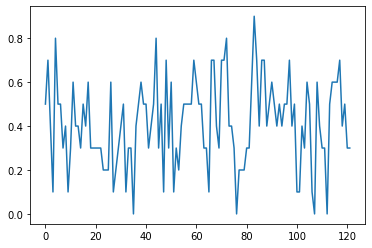

In [49]:
plt.plot(stabilities)

In [260]:
test = [0.5,
 0.0,
 0.1,
 0.2,
 0.4,
 0.7,
 0.3,
 0.4,
 0.4,
 0.1,
 0.4,
 0.1,
 0.1,
 0.2,
 0.1,
 0.3]

def avg_stabilitya(list):
    return (sum(list)/len(list))

#list of 10, 20,30,...,290
sizes = [10*i for i in range(1,30)]

avg_stabilitya(test)

0.26875

In [261]:
y_stability = []
for size in sizes:
    test = list_of_words[:size]
    y_stability.append(knn_similarity('man',test))

In [267]:
#average the lists in y_Stab to a number
y = []
for L in y_stability:
    y.append(avg_stabilitya(L))

Text(0.5, 1.0, 'unbiased: stability vs. # of words')

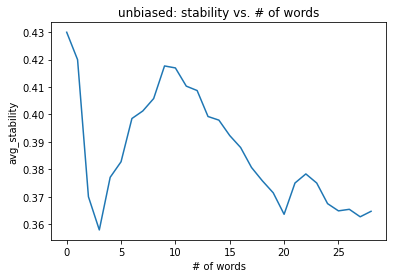

In [268]:
plt.plot(y)
plt.xlabel('# of words')
plt.ylabel('avg_stability')
plt.title('unbiased: stability vs. # of words')

## With Debiased!!

In [273]:
def knn_similarity_debias(list1, list2):
    words = []
    total = 0
    for word1 in list1:
        words.append(word1[0])
    
    for word2 in list2:
        if word2[0] in words:
            total += 1
            
    total = total/10
    return total

In [276]:
stab_debias = []
for word in list_of_words:
    #find the 10 most similar words
    try:
        knn1 = mostSimilar(final_embeddings,word,10)
        knn2 = [i[0] for i in w2v_gnews_vectors.most_similar(word)]
        stab_debias.append(knn_similarity_debias(knn1,knn2))
    except KeyError:
        continue


Text(0.5, 1.0, 'unbiased: stability vs. # of words')

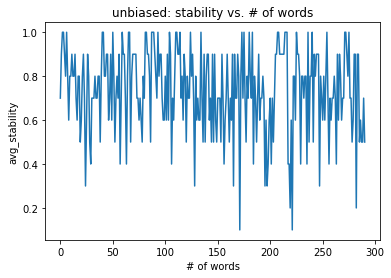

In [277]:
plt.plot(stab_debias)
plt.xlabel('# of words')
plt.ylabel('avg_stability')
plt.title('unbiased: stability vs. # of words')

In [288]:
thousand_words = brown.words()[:3000]
thousand = list(dict.fromkeys(thousand_words))
test_thousand = [i.lower() for i in thousand]


1084
1084


In [292]:
real_final_list_of_words = thousand + final_list
final_list1 = list(dict.fromkeys(real_final_list_of_words))
the_final_word_list = [i.lower() for i in final_list1]
print(len(the_final_word_list))

1331


In [ ]:
final_stability_debias = []
for word in the_final_word_list:
    #find the 10 most similar words
    try:
        knn1 = mostSimilar(final_embeddings,word,10)
        knn2 = [i[0] for i in w2v_gnews_vectors.most_similar(word)]
        final_stability_debias.append(knn_similarity_debias(knn1,knn2))
    except KeyError:
        continue


## Turn the Text file to a dictionary

In [21]:
path = '/Users/alejandropelcastre/w266/debiaswe_tutorial/debiaswe/Embeddings_debias copy.txt'
f = open('/Users/alejandropelcastre/w266/debiaswe_tutorial/debiaswe/Embeddings_debias','r')
total = 0
for line in f.read(1000):
    if line == ' ':
        total = total + 1
print(total)
f.close()

83


In [145]:
#Loads all the data, takes a while
f = open('/Users/alejandropelcastre/w266/debiaswe_tutorial/debiaswe/Embeddings_debias','r')
data = []
with open('/Users/alejandropelcastre/w266/debiaswe_tutorial/debiaswe/Embeddings_debias', 'r+') as f:
    words_text = []
    for line in f:
        data = data + line.split()
        #print(line)
        alphabet = 'abcdefghijklmnopqrstuvwxyz'
        word = ""
        if str(line).lower() in alphabet:
            word = word + str(line).lower()
            words_text.append(word)
f.close()
#print(data)

In [165]:
print((data[:1000]))

['in', '0.048795298', '0.061338425', '0.064000554', '0.04731439', '0.052902717', '-0.08277755', '-0.06107805', '-0.116573505', '0.010907113', '0.10105001', '-0.086370975', '-0.028051285', '0.051557314', '0.058861695', '-0.07344971', '-0.073564075', '0.033252176', '0.0740957', '-0.046355512', '-0.027050924', '-0.033800412', '0.033630908', '-0.09324775', '-0.050789386', '0.0020634583', '0.029761236', '-0.0030950103', '0.0880673', '0.044401318', '0.043697383', '0.059637707', '-0.056094598', '-0.020293882', '0.03896462', '-0.06748451', '0.04776284', '-0.0969133', '-0.024104083', '0.07259643', '0.13078956', '0.079343446', '-0.025325192', '-0.037664555', '-0.008255062', '0.025634758', '0.07700493', '0.02142084', '-0.020123646', '-0.0020364767', '0.08450311', '0.046993658', '0.06791854', '0.026451137', '-0.015698567', '-0.07463729', '2.2298753e-05', '-0.03822672', '0.024888063', '0.06324936', '-0.08541546', '-0.06627336', '0.023118922', '-0.10975223', '-0.18130703', '-0.047150474', '0.0397454

In [176]:
words = []
for i in data:
    try:
        float(i)
    except ValueError: 
        words.append(i)
print(words)

['in', 'for', 'that', 'is', 'on', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'have', 'he', 'will', 'has', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', 'had', 'year', 'were', 'we', 'more', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out', 'can', 'all', 'also', 'two', 'after', 'first', 'do', 'time', 'than', 'when', 'over', 'last', 'new', 'other', 'her', 'people', 'into', 'our', 'there', 'she', 'could', 'just', 'years', 'some', 'three', 'million', 'them', 'what', 'so', 'no', 'like', 'if', 'only', 'percent', 'get', 'did', 'him', 'game', 'back', 'because', 'now', 'before', 'company', 'any', 'team', 'against', 'off', 'most', 'made', 'through', 'make', 'second', 'state', 'well', 'day', 'season', 'says', 'week', 'where', 'while', 'down', 'being', 'government', 'your', 'home', 'going', 'my', 'good', 'should', 'many', 'way', 'those', 'four', 'during', 'such', 'may', 'very', 'how', 'since', 'work', 'take', 'including', 'high',

In [168]:
"""point = 0
real_words = []
numbers    = []
word = ""
num = ''
alphabet = 'abcdefghijklmnopqrstuvwxyz'
while point < len(data) - 1:
    if data[point] in alphabet:
        i = 0
        #word = word + data[point]
        while data[point + i] in alphabet:
            word = word + data[point+i]
            i = i + 1
        real_words.append(word)
        word = ""
        while data[point + 1] in alphabet:
            point += 1
                
    #######################

    point += 1
print(real_words)
"""

['no', 's', 'e', 'i', 'de', 'n', 'm', 'v', 'b', 't', 'c', 'x', 'd', 'p', 'k', 'o', 'def', 'w', 'l', 'u', 'f', 'y', 'r', 'g', 'h', 'st', 'hi', 'mn', 'op']


In [122]:
"""#turn numbers to floats
n = 0
float_numbers = []
for digit in numbers:
    count = 0
    while n < len(data)/10:
        if digit[n] == '-' and type(digit[n-1] != 'e'):
            float_numbers.append(float(digit[n:n+7]))
            n += 12
        
        else:
            float_numbers.append(float(digit[n:n+8]))
            n += 11
        print(float_numbers)
print(float_numbers)"""

"""n = 0
float_numbers = []
for digit in numbers:
    point = 0
    while n < len(data)/10:
        float_numbers.append(float(digit[n:n+9]))
    
print(float_numbers)"""

'n = 0\nfloat_numbers = []\nfor digit in numbers:\n    point = 0\n    while n < len(data)/10:\n        float_numbers.append(float(digit[n:n+9]))\n    \nprint(float_numbers)'

In [163]:
#Turn the whole file into a string
res = ""
with open('/Users/alejandropelcastre/w266/debiaswe_tutorial/debiaswe/Embeddings_debias', 'r+') as f:
    words_text = []
    for line in f.read(100005):
        res = res + line
        #print(line)
        alphabet = 'abcdefghijklmnopqrstuvwxyz'
        word = ""
        if str(line).lower() in alphabet:
            word = word + str(line).lower()
            words_text.append(word)

print(words_text)

['i', 'n', 'e', 'e', 'f', 'o', 'r', 't', 'h', 'a', 't', 'i', 's', 'o', 'n', 'w', 'i', 't', 'h', 'e', 's', 'a', 'i', 'd', 'e', 'w', 'a', 's', 't', 'h', 'e', 'a', 't', 'n', 'o', 't', 'e', 'a', 's', 'i', 't', 'e', 'b', 'e', 'f', 'r', 'o', 'm', 'e', 'b', 'y', 'a', 'r', 'e', 'h', 'a', 'v', 'e', 'h', 'e', 'e', 'w', 'i', 'l', 'l', 'h', 'a', 's', 'e', 'e', 'e', 'h', 'i', 's', 'a', 'n', 'e', 't', 'h', 'i', 's', 'o', 'r', 'e', 't', 'h', 'e', 'i', 'r', 'e', 'w', 'h', 'o', 't', 'h', 'e', 'y']


In [178]:
words

['in',
 'for',
 'that',
 'is',
 'on',
 'with',
 'said',
 'was',
 'the',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'are',
 'have',
 'he',
 'will',
 'has',
 'his',
 'an',
 'this',
 'or',
 'their',
 'who',
 'they',
 'but',
 'had',
 'year',
 'were',
 'we',
 'more',
 'up',
 'been',
 'you',
 'its',
 'one',
 'about',
 'would',
 'which',
 'out',
 'can',
 'all',
 'also',
 'two',
 'after',
 'first',
 'do',
 'time',
 'than',
 'when',
 'over',
 'last',
 'new',
 'other',
 'her',
 'people',
 'into',
 'our',
 'there',
 'she',
 'could',
 'just',
 'years',
 'some',
 'three',
 'million',
 'them',
 'what',
 'so',
 'no',
 'like',
 'if',
 'only',
 'percent',
 'get',
 'did',
 'him',
 'game',
 'back',
 'because',
 'now',
 'before',
 'company',
 'any',
 'team',
 'against',
 'off',
 'most',
 'made',
 'through',
 'make',
 'second',
 'state',
 'well',
 'day',
 'season',
 'says',
 'week',
 'where',
 'while',
 'down',
 'being',
 'government',
 'your',
 'home',
 'going',
 'my',
 'good',
 'should',
 'many

In [195]:
len(embedding_numbers)
len(b)

8219

In [197]:
len(words)

26422

In [200]:
#split the new string of the file into elements and turn the number strings to floats
a = data
b = [float(x) for x in a if x not in words]

#now add the numbers and it's word to an embedding space (dict)
embedding_numbers = []
number = []
for num in b:
    number.append(num)
    if len(number) == 300:
        embedding_numbers.append(number)
        number = []
        
count = 0
final_embeddings = {}
while count < len(words) - 2 :
    word = words[count]
    final_embeddings[word] = np.array(embedding_numbers[count])
    count += 1
    
#do not print full     
#print(final_embeddings)

In [202]:
print(len(final_embeddings))

26420


In [83]:
#force way to do this
in_embedding = '0.048795298 0.061338425 0.064000554 0.04731439 0.052902717 -0.08277755 -0.06107805 -0.116573505 0.010907113 0.10105001 -0.086370975 -0.028051285 0.051557314 0.058861695 -0.07344971 -0.073564075 0.033252176 0.0740957 -0.046355512 -0.027050924 -0.033800412 0.033630908 -0.09324775 -0.050789386 0.0020634583 0.029761236 -0.0030950103 0.0880673 0.044401318 0.043697383 0.059637707 -0.056094598 -0.020293882 0.03896462 -0.06748451 0.04776284 -0.0969133 -0.024104083 0.07259643 0.13078956 0.079343446 -0.025325192 -0.037664555 -0.008255062 0.025634758 0.07700493 0.02142084 -0.020123646 -0.0020364767 0.08450311 0.046993658 0.06791854 0.026451137 -0.015698567 -0.07463729 2.2298753e-05 -0.03822672 0.024888063 0.06324936 -0.08541546 -0.06627336 0.023118922 -0.10975223 -0.18130703 -0.047150474 0.03974546 0.045886893 0.14208445 0.046388447 0.06565141 0.09513312 -0.027776707 0.018031688 0.13546486 -0.019547002 -0.017916061 0.08886239 0.02142617 -0.07091062 0.054329816 0.00024051158 -0.06073229 0.04962426 -0.015539766 -0.047900923 -0.09656766 -0.048403807 0.06487078 -0.046029128 0.016755098 0.057783015 -0.03178178 -0.025829805 -0.13914777 -0.054567862 0.01428808 0.07233343 -0.04805735 -0.0093628485 0.0013984668 0.0074330233 -0.121028155 -0.012732925 0.0024789735 -0.008300195 -0.05901725 -0.016683478 -0.06877093 0.0027787243 -0.013155843 -0.009225157 0.0726526 -0.10200683 -0.061789624 -0.023671463 0.042402036 0.10156164 0.083419144 0.09059449 0.062768005 -0.0031822333 0.03414185 -0.108344585 -0.0014952058 -0.085805796 -0.043092974 0.0532497 -0.06878929 -0.022140892 0.09323303 0.060277876 -0.069326125 -0.12343845 -0.054842096 0.017128628 -0.05764277 0.0044792434 -0.12598105 -0.07426715 0.023508044 0.02945995 -0.010952258 0.07684909 0.05009688 -0.033691425 0.052352708 -0.03918082 0.02135636 -0.12745945 0.06539794 0.073423184 0.0039313524 0.04648505 0.03687563 -0.018271266 -0.025986165 -0.046821497 -0.0027113443 0.07132345 0.03134338 0.009274471 -0.031615898 -0.0054878057 0.08400786 0.015472034 0.10914462 0.060291536 0.0016766259 0.0013536483 -0.06909566 -0.10722621 -0.042405512 -0.037672166 -0.097614385 -0.10688908 -0.017461214 -0.017367827 0.026581388 0.07859253 8.08299e-05 -0.017830888 0.0006885653 -0.084700346 0.06286549 -0.09687725 -0.013964265 -0.004045402 0.08250224 0.061043583 0.034388065 0.017900417 0.014728826 0.06462691 0.018648537 -0.08358561 0.008049917 -0.012039727 -0.026531436 -0.023841107 -0.12278436 0.07114877 -0.014753248 0.003333555 -0.027984476 -0.03671966 -0.051213637 -0.018024787 -0.02071383 -0.0018660007 -0.03943955 -0.041168924 0.06899935 -0.05498354 0.010956437 -0.060093425 -0.021960272 0.027481515 -0.015042512 -0.041140463 -0.008578284 0.034945365 0.023095703 0.018784935 -0.057542447 -0.009919303 0.010564822 -0.003820147 0.02825563 0.020560745 0.013148638 0.02513168 -0.13540873 0.085961595 0.05621259 -0.030033909 -0.008098467 0.03425231 -0.0071151783 0.09211952 0.046949152 -0.037592933 -0.026211245 -0.0044057146 -0.0358542 0.03542601 -0.03639359 0.050296508 0.0017717 -0.00719747 -0.033465434 0.05592961 -0.009493192 0.052515704 0.0038524133 0.054759264 -0.031576443 0.002047332 0.03453144 -0.049202945 0.007273745 0.0012338468 0.014978638 0.052060094 0.12822919 0.13111137 0.040668387 0.06794748 -0.026289575 0.037629846 -0.029708935 0.033074316 0.051546637 0.035146616 -0.035464175 0.03960527 -0.10002906 -0.019469613 -0.027218737 -0.044152256 -0.041165195 0.09182401 -0.063304245 -0.011361147 0.09235595 0.00021656971 0.046888888 -0.080065385 -0.109532624 -0.033627283 0.02427263 -0.12682712 -0.06801415 -0.061922327 0.046823323 0.04613094 -0.034738354 -0.04004009 -0.0314562 0.013703692 -0.046752855'.split()
in_em = [float(x) for x in in_embedding]
embeddings_debias = {}
embeddings_debias['in'] = np.array(in_em)

were_e = '-0.04514706 -0.010922127 0.041703917 -0.022019733 -0.016097046 -0.10473793 -0.015865564 0.021582345 0.018377589 0.05516907 -0.0069601317 -0.11445911 -0.002140752 0.09948875 -0.0017493077 -0.057669833 -0.014414122 0.12692814 -0.075691506 0.08627242 -0.05680689 -0.059332497 -0.02685495 0.02278974 0.14085054 0.040636715 -0.0708322 0.0517541 0.0062352824 -0.06758332 -0.040651754 -0.061435297 -0.04228652 0.018390214 0.11635721 0.04157087 0.023023047 -0.03217801 0.010260925 0.0008600758 0.113768786 -0.010932577 0.031354044 0.017914515 0.048708767 -0.038708016 -0.0041220896 -0.014486204 -0.034640986 0.039641865 -0.010267876 -0.0039277063 -0.019087764 0.027514586 0.00602669 0.003831671 0.107053824 0.032844715 -0.042579636 0.039399806 -0.0594614 0.09966926 -0.010947148 -0.04942969 -0.052569337 -0.03366725 -0.04724137 0.05956183 -0.014544463 0.030588338 -0.02483768 0.04896367 0.02900723 0.07872884 -0.08376992 0.03501128 0.049499318 -0.0092051765 0.024687774 0.05240758 0.056939665 -0.029036822 -0.007967811 -0.013151745 -0.008880688 0.006309478 -0.09153793 -0.024410786 -0.04698346 -0.004207871 -0.010602792 0.07413129 0.015977632 -0.005440347 0.029701434 -0.004729724 -0.034430273 0.083717525 -0.011288072 -0.020104373 0.08104202 -0.06506909 -0.041166484 0.08682254 0.039038125 -0.050483268 0.0054945447 -0.027286641 0.07835011 0.007585262 -0.023004115 0.078842014 0.019438513 -0.0069890576 -0.07291635 0.004899889 0.12143134 -0.058473658 0.05373738 0.042336214 -0.025522832 0.11619378 -0.0542078 -0.059030645 -0.004811295 0.024253663 0.025994947 -0.05777147 0.040467843 0.008294774 0.07087771 -0.086817406 -0.010562794 -0.050794296 0.011833956 0.044944614 0.07872765 -0.05380082 -0.037624814 -0.0073485896 -0.04115171 0.0113047315 0.15587191 0.0044788606 -0.042851813 0.07550783 -0.013435194 -0.10458905 -0.12406623 0.010021398 -0.10093546 0.038796008 -0.033953313 0.017842902 0.020573711 -0.03492688 -0.07129338 -0.11232141 0.032630432 0.07690645 -0.040502626 0.020509992 0.023214182 0.038530223 0.00918452 -0.01791351 -0.04218875 0.025985844 0.070530474 -0.021829091 -0.19180676 -0.11977618 -0.08765536 -0.09117093 -0.01852393 -0.0971938 -0.032717038 0.038209476 0.09687118 0.019944433 0.0009934148 0.035202473 0.01502019 0.039673388 0.087994315 -0.018231481 0.008703601 0.009190863 0.025366833 0.039365973 0.033944946 -0.0777685 0.015904574 0.03914182 -0.0919683 0.06584643 0.07477539 -0.11264925 -0.010886528 -0.0629911 0.06871864 -0.00091901416 -0.035626017 -0.030940654 -0.03021684 0.015460758 -0.051736724 -0.034632586 0.046483617 -0.005328447 0.03523122 -0.109248094 0.045822315 0.06649685 -0.036414854 -0.029144675 0.05345719 -0.041644555 -0.15335879 -0.07533443 -0.06689379 -0.0068118456 0.01758168 -0.09912656 0.032533277 -0.004347413 -0.00070478005 0.09830688 -0.026283154 0.014063175 0.12770751 0.030710602 -0.05019203 0.02111776 0.10120729 -0.04465358 0.007782661 -0.009719903 0.035246115 -0.010177397 0.028048106 0.09561415 0.01551417 0.026665155 0.020913724 0.04041207 -0.018634873 0.11623751 -0.08257238 0.07000048 0.009888509 -0.04116524 0.08003854 0.009010263 -0.021701384 -0.033535004 0.040794887 0.050584663 0.05671343 -0.08407811 0.062177315 -0.017586216 -0.0102123115 0.14529681 0.0043435115 0.158535 -0.073034026 0.02137387 0.066907816 0.006029025 0.09553638 0.053500623 0.025050212 0.093109205 0.11784684 0.069617175 -0.040827494 -0.07791799 0.0013189496 -0.03597338 0.06343322 -0.0021777116 -0.014856657 -0.05978201 0.0077409795 -0.01325489 -0.07044159 0.016568815 0.055329002 0.04219617 -0.041183893 -0.045734394 -0.02327611 0.024970338 0.008697021 0.08491583 -0.07679582 -0.06579607 0.11696676 0.001826706'.split()
were_em = [float(x) for x in were_e]

embeddings_debias['were'] = np.array(were_em)

#add embedding to dictionary given a string
def add_embedding(string, embedding_dict=embeddings_debias):
    string = string.split()
    word = string[0]
    string = string[1:]
    vector = [float(x) for x in string]
    embedding_dict[word] = np.array(vector)
    
add_embedding('we -0.017293736 0.0451361 0.019513877 0.118519954 -0.037624344 -0.060988747 0.020667443 -0.023773124 -0.10434518 0.031071777 -0.07071765 -0.075493515 0.0063125333 -0.002670109 -0.097344846 0.024785226 0.05801792 -0.018966658 0.05092232 0.0047657816 -0.027135503 0.0051392787 0.11309056 -0.06252493 0.022746215 0.11380516 0.011203649 -0.07122905 0.03503694 -0.04866965 -0.022062931 0.05997216 0.021672728 -0.053630173 -0.027763566 -0.025422145 0.026807886 -0.02258327 0.06114625 0.036886834 0.044620004 -0.044693604 0.11800065 0.022721658 0.040005352 0.015378887 0.02192992 -0.034195572 0.016311022 0.0018638109 0.11090112 0.03253068 -0.014193612 -0.009588677 -0.036555484 -0.059082344 -0.015660174 0.009220514 0.03885832 -0.016499475 -0.013678263 0.06008234 -0.044989046 -0.0752829 0.023133438 -0.012464706 -0.028040726 0.11381753 -0.051020414 0.03296516 -0.011693513 0.012814146 0.025709987 -0.07298943 -0.10800585 -0.04817264 0.055210732 0.0497201 0.047597487 0.085773006 -0.033440456 -0.085073814 0.04583079 -0.021159707 -0.044725075 -0.07150356 4.5127843e-05 0.10149054 -0.030919323 0.08232911 0.05959869 0.0107732015 -0.045999076 0.029714612 -0.08414657 -0.053612214 -0.0137902675 0.035163302 0.016767057 -0.05724176 -0.045058735 -0.047966234 0.031645633 0.0971706 -0.10780267 -0.031933956 -0.12107402 0.0047483128 -0.018483024 -0.017373994 -0.10442023 -0.011525743 -0.022760233 0.032774445 -0.040694997 -0.045873966 0.036000423 -0.10440142 0.054641943 -0.041383646 -0.022941833 -0.07788431 -0.0013808059 0.06822736 -0.088891 -0.0031094113 -0.069557056 -0.052199256 -0.020066224 0.07426531 -0.041650947 -0.09966116 -0.1468818 -0.075497776 -0.022170812 -0.07428815 0.07400126 0.07190842 0.09764815 0.04965042 0.0075799874 -0.018860308 0.08840007 0.0044789505 0.05856806 0.047055673 -0.07680541 -0.1249794 0.0050136084 0.0045947656 0.07440691 0.06268858 -0.10344076 0.043362003 -0.03712629 0.01716236 -0.015487466 -0.028390083 -0.06248849 0.050882373 0.0071136206 0.0726469 -0.013992725 0.086270414 0.036282647 -0.12105077 0.029143041 -0.0014962176 0.043059397 -0.040121637 -0.10042183 0.055216413 0.05611962 -0.08072834 0.043179456 -0.013978988 0.07867046 -0.038930357 0.0074565457 0.029295778 -0.020998085 0.04505795 0.046895623 -0.03407647 0.014207122 -0.012993799 -0.07299013 0.049130276 0.07154939 0.092565194 -0.052290604 0.05711655 0.011667009 -0.03975938 -0.033648763 -0.007768438 0.0031324022 0.038529303 -0.055542264 -0.033252798 0.014999302 0.06376942 0.04904739 0.012542483 0.03506569 0.041920602 -0.066876434 -0.06813776 -0.0397293 0.07672942 0.049360003 0.07247759 -0.049429227 0.019226091 -0.088327155 -0.05663949 0.16357082 0.024948977 -0.023881398 0.06942218 -0.08421825 0.057290472 -0.021721834 -0.02009715 0.043144044 -0.10581181 0.11121218 0.053454496 -0.05746388 -0.006883714 -0.058260165 -0.004757273 0.035027117 -0.0117134005 0.026796328 -0.036439314 -0.09471991 0.03439686 0.1149262 0.04268861 -0.04715273 0.091894574 0.002049764 0.007508215 -0.027751908 -0.0541032 0.003949491 0.09046246 -0.04968181 -0.013740666 0.059344754 -0.025991732 -0.028538939 0.019285034 -0.03499549 -0.060621366 0.039319895 -0.12617841 -0.035804655 -0.13260123 -0.025728036 -0.07359539 -0.01891998 0.03771005 0.03554635 0.05988299 0.034167968 -0.026197072 -0.10167861 0.0773548 0.022931434 0.12848692 0.091488585 0.15420322 -0.019134732 0.02903355 -0.031499006 -0.09100584 -0.0572642 -0.029792266 -0.07095336 -0.036610793 0.03319337 -0.0048733484 0.0150605505 0.030958014 0.026402995 -0.10604043 -0.004824932 0.070178695 -0.038536567 0.04513064 -0.062044796 -0.0047552623 0.03096657 0.023024995 0.022759482 -0.00583358 0.07495704 -0.054215893')
add_embedding('more 0.032150753 -0.13116784 -0.043411978 0.07732203 -0.041563235 0.019737925 -0.018528704 -0.05987524 0.02086555 0.0010182038 -0.0010173136 -0.037887704 0.012879496 0.03440617 0.021210227 -0.009531343 -0.08478501 0.04399312 -0.052926227 0.06086334 0.008717347 -0.059846856 0.02390168 -0.04245363 -0.15355386 0.02889313 -0.061199628 0.008275186 0.06855596 0.05804456 0.009732979 0.07129958 -0.10423997 -0.06290681 0.022066148 -0.05685733 0.029738601 -0.016842695 0.070101604 0.12845299 0.0857601 -0.12208091 -0.06858292 0.05762137 -0.02248978 0.043555256 -0.0021584264 0.09692975 0.009324376 -0.016684415 0.1458514 0.003483999 -0.036525276 -0.098163925 0.0085994 -0.012060723 -0.027646387 -0.052741725 0.004844147 -0.08827147 -0.05177675 -0.047357555 -0.06433962 -0.019739175 -0.041485935 0.027280198 -0.027310403 0.05392073 -0.007870445 0.004722826 0.0125432 0.0066744764 0.044756174 -0.029116865 -0.014492591 -0.0642875 0.077860266 0.05236328 0.0073640477 -0.030272728 -0.013743242 -0.032958783 -0.017442008 0.00080786325 -0.17037134 -0.05914041 -0.02861784 0.03738835 0.11297163 0.012972019 0.11066492 0.016989367 -0.10428017 -0.065420635 -0.035622973 -0.12089859 0.032912437 0.06612111 -0.0111172255 0.047614623 0.008986311 -0.05781548 -0.034142267 0.07752869 -0.104935445 -0.013504711 -0.036538545 -0.08209315 -0.0017886919 -0.009224399 0.09974706 0.07319048 0.036802944 0.025424529 0.067902505 0.036865175 0.009651748 -0.020019101 0.09666257 0.1105096 -0.068055086 0.097800486 0.0009507547 0.044745427 -0.035551917 -0.02741567 0.039586414 -0.016306944 -0.038565814 0.041968998 0.010150411 -0.047869958 -0.015859913 -0.024609834 0.013788206 -0.02184953 0.08595985 -0.07571505 -0.011130667 0.021025505 0.046108443 -0.12118374 0.020596338 -0.013158432 0.096565224 -0.026005633 -0.072079234 -0.024996422 -0.107412085 0.024086565 -0.057013594 -0.076950744 -0.13291752 0.0070893643 -0.051847994 0.004490978 -0.054411836 0.01638765 -0.07843982 0.044229086 0.06932725 0.0754872 -0.042869538 0.04468428 0.0044698976 0.011653174 0.0026477103 0.04106539 0.062828675 0.014003419 -0.10854528 0.027655784 -0.019182773 -0.039021745 -0.0030964601 -0.057594173 -0.12280394 -0.0024148424 -0.028616484 -0.06709892 -0.10033587 -0.008440063 0.02367247 -0.021837156 -0.04949425 -0.019672116 -0.0046686335 -0.028408771 0.018972425 0.0009008787 0.018821493 -0.10561684 -0.06439953 -0.085678 -0.028394768 -0.0546171 -0.016671836 0.0574831 0.004704304 -0.057490636 -0.10434864 0.09313964 -0.07039751 0.079542525 0.014793975 -0.05325198 -0.01550997 -0.061387647 -0.02508649 0.07420866 0.05232467 0.04433484 0.056743976 0.10565671 0.024569036 0.05010919 -0.00759268 0.099856935 -0.09730681 0.060496744 0.021520894 0.011355976 -0.0153476745 -0.029836612 0.14215726 -0.058605522 0.009893965 0.04052291 0.0005059308 0.005495448 0.0039296006 -0.020794997 0.110150695 0.0029934146 -0.039288852 -0.03747511 -0.07707016 -0.15180036 0.036825854 -0.015466564 0.04022651 0.028066635 0.006252238 -0.06940424 0.04890337 0.07702905 0.0065056244 0.11563753 -0.053604845 0.029528672 0.06188079 0.02021204 -0.03469835 0.01697198 0.005655916 0.01695714 -9.082327e-05 0.03202052 -0.06912412 0.027921764 -0.02297529 0.03933814 -0.10592829 -0.0012649946 -0.04462368 0.033753395 -0.016315222 -0.004166665 -0.087260865 0.050857097 0.07627123 0.030836856 0.097563654 0.014968216 0.07514566 -0.030838847 -0.1129179 0.01820461 -0.0028190834 0.077053145 0.048010316 0.09062797 0.009744505 -0.023667002 -0.0070490837 0.060927752 -0.05682972 -0.05825889 0.06560912 0.083533406 0.009040721 0.048497498 0.019927133 0.086512595 -0.054365188 -0.024941534 0.06336195 0.014566763 0.033504926 0.03171102')
add_embedding('up 0.055017956 -0.012806524 0.09849249 0.07053189 -0.10440173 -0.04609584 0.030164 -0.043887064 -0.03193322 0.07963961 0.001958971 -0.060150366 0.033255216 -0.051747553 -0.039897054 -0.0651513 0.012888541 0.05174151 -0.035344902 -0.08630863 0.015313609 0.049733803 0.0062603415 0.0025724915 0.07962448 0.013356381 -0.05025827 -0.03967542 0.00066015497 0.023729537 -0.001378571 -0.0065309177 -0.047712367 -0.11529784 -0.057284344 0.028144965 -0.10049467 -0.05033887 0.013829863 0.10455374 0.11689833 -0.1307293 0.02759634 -0.07269281 -0.07851031 -0.0057380362 -0.008534142 0.05896666 0.06463923 -0.019902796 0.06800189 -0.06983752 -0.03465564 -0.010349504 -0.09758708 -0.0433032 -0.015954347 0.010618169 0.023423323 -0.091658056 -0.07647288 0.056635123 0.0036417746 -0.134989 -0.10354536 0.031509764 -0.08187923 0.04336221 0.049405534 0.11913849 0.08812206 0.05551346 0.11788936 0.1446929 -0.091468304 0.00066047296 0.010127613 0.07928215 -0.04819064 -0.020841181 0.047178693 -0.049869824 -0.053933438 0.020911025 0.06832344 -0.021878215 -0.09063083 0.03093895 0.0012133857 -0.010277149 0.049090434 0.041611522 -0.0310219 -0.15171234 -0.03546301 0.03996788 0.011999849 -0.019064138 -0.074585475 -0.08493124 -0.10933675 -0.099081665 -0.007979788 0.022012625 -0.053223465 -0.0151579445 -0.0011859618 -0.019678267 -0.035550144 0.04697023 0.0119779715 0.07582005 0.025774546 -0.0017630267 0.037639197 -0.02235066 0.041448712 0.12447578 -0.0004922402 0.037056774 -0.043515455 -0.048787832 -0.052159313 0.020868927 0.020312643 0.02759541 -0.06979824 0.036841087 0.0033030543 0.030430978 -0.10682036 0.0003293541 0.05884853 -0.02800539 0.052544814 0.09869773 0.019294873 -0.041135356 -0.09846343 0.0069330414 0.006843004 0.010872331 -0.0257513 0.07905095 -0.09698176 0.006327875 0.014809901 -0.046659376 0.011655996 0.075291686 0.034848902 0.009479804 -0.0598467 0.013614621 0.022180766 0.080615036 -0.124088936 -0.07638842 -0.0060664653 0.06347522 0.004334193 0.07905012 -0.046656743 0.048886985 0.029600672 -0.0707813 0.013688253 -0.06809161 0.019955685 -0.12976173 -0.13518575 -0.021701768 -0.03103542 -0.011291082 -0.113141485 -0.024142083 0.018658929 -0.0065633515 -0.026024811 0.04339133 -0.002998241 -0.017251471 0.06387441 0.058418956 -0.074352995 -0.023264866 -0.043628663 0.058006965 0.09767464 -0.023571247 0.0518965 0.013821995 0.05525602 -0.0166575 -0.031741 -0.03816346 0.01701614 -0.00032961214 -0.10318789 -0.089100435 0.06304272 0.06590852 0.039897706 -0.05345399 0.06174413 0.054893356 -0.067069106 -0.0031622371 0.09211134 0.031068772 -0.012156973 0.0059867403 -0.027214132 0.10305046 0.012766672 0.09166478 -0.014667293 0.034485295 -0.01945858 0.02903596 -0.057679813 0.081652485 0.010080977 -0.04503405 -0.06304823 -0.041311383 -0.028310092 0.08422335 0.022957152 0.028807314 0.010838918 -0.052437376 -0.033121116 -0.06593842 -0.044227716 0.019518822 0.03230598 0.0441628 0.028821968 0.080993235 -0.051863495 0.0095763 -0.05347234 0.042234726 -0.035632 -0.038297027 0.03897774 0.06577915 -0.0020769609 -0.0402657 -0.063986585 -0.026481317 -0.033929966 0.080126785 -0.01186203 0.0076240925 0.07768971 0.0006980924 0.010437034 -0.035695244 -0.03217811 0.044051405 -0.11035 -0.042479 0.009326825 0.06187918 -0.058277145 0.006979108 -0.026980404 0.015884835 -0.02792549 0.019901756 0.06410567 -0.011702557 0.028976953 -0.08179259 0.04493745 -0.114774294 0.010260779 0.031169347 0.057420455 -0.017457765 -0.06316112 -0.04364959 0.031293813 0.039177973 -0.03884337 0.021707019 0.021598719 -0.0014878787 0.16760837 0.03845604 -0.121329315 0.034811188 -0.040434003 0.0002921547 -0.055649094 0.1142579 -0.14060546 0.0060214307')
add_embedding('are -0.041255277 -0.01008803 0.040920094 0.014212881 -0.10893528 0.025166936 0.0110549955 -0.0040674037 0.026175845 0.026531594 -0.041986525 0.009810666 -0.008496739 0.098309726 -0.02045429 0.007342146 -0.03223844 0.16837868 -0.092898235 0.05254182 -0.090235814 -0.060695168 -0.0041653086 0.008781698 0.12630671 0.050195094 -0.068940334 0.031856276 -0.036195125 -0.08746951 -0.044257443 -0.031299796 -0.061614137 0.015298602 0.08648635 0.034714308 -0.013781771 -0.013508296 0.040295776 -0.01514653 0.14451605 0.01571202 -0.0033444082 0.047481284 0.051642288 -0.06383592 -0.00024045167 0.025297647 -0.054181155 -0.049702857 -0.005575615 0.08304046 -0.061895113 -0.016971475 0.06850141 -0.014433651 0.0937879 -0.008199226 0.007348553 0.051106416 -0.053754207 0.06603187 -0.07185779 -0.024648 -0.030664993 -0.048426464 -0.05744809 0.107877254 -0.091082245 0.012885291 0.008625593 0.06309482 0.015851673 -0.008527263 -0.027711317 -0.042843893 0.020692354 0.0053834133 0.0042034197 0.12134119 0.02086221 -0.07044286 0.041398183 -0.07838306 0.049113628 0.030917369 -0.11150966 -0.018170455 0.05372203 0.011152179 0.0026058785 0.047363047 -0.0066000326 -0.063800074 0.0384343 -0.03315355 0.045338135 0.010875308 0.066598974 0.024555616 0.038034808 -0.03699362 -0.019976903 0.06752787 0.003136929 -0.058251426 0.027212769 -0.0069364393 0.07268944 0.009102215 0.018269196 -0.0014305467 -0.0024700023 0.040639456 -0.057576727 0.055630174 0.06872995 -0.0864231 0.047680963 0.018385598 0.017026689 0.07950012 -0.03169313 0.008036764 0.02833317 -0.002192897 -0.067798294 0.021654421 0.027886165 0.0038943705 0.09053675 -0.09216808 0.029055156 -0.07026517 0.009422563 0.0045941276 0.13192788 -0.023117997 0.04341236 0.0064965915 0.009267152 0.008555155 0.14494523 0.013020927 -0.019566016 0.03767742 0.054319803 -0.058018703 -0.02591735 -0.009863684 -0.07986851 0.04096627 -0.019190101 -0.041187286 0.01207404 -0.007918938 -0.048762087 -0.10276152 0.0013555005 0.025658209 -0.04463014 0.098151416 -0.012344214 0.0132108135 0.064048365 -0.03205313 -0.058299363 -0.006173845 0.0735543 -0.004110767 -0.20595473 -0.15361637 -0.04981074 -0.04283211 0.017401814 -0.060289007 -0.081285544 0.030874154 0.068194464 0.029605703 -0.054035563 -0.031080393 0.030969284 0.004349918 0.01010564 -0.030652555 -0.014789698 0.038528323 0.05619461 0.063816406 0.021407083 -0.01803597 -0.0043307617 -0.054218344 -0.12355175 0.06255292 0.023641413 -0.09273702 -0.0400077 -0.031735953 0.078760065 0.009025466 -0.044561908 -0.028664988 -0.15285039 0.044829328 -0.029451825 -0.09589901 -0.008356782 0.06699086 0.041907668 -0.065151975 0.049485676 0.035285126 -0.03653535 0.06593286 0.06428676 -0.050820015 -0.11656113 -0.030582257 -0.042720553 -0.103085466 -0.087308615 -0.08033703 0.049109798 0.009444724 -0.05426973 0.025088223 -0.055700134 0.036131985 0.05472994 0.0061188214 -0.03613066 0.09646415 0.08496793 0.014628164 -0.03535723 0.005113397 0.005007049 0.017162345 0.02818908 0.07348574 0.019087436 0.008930544 0.026506625 0.054271072 0.005351112 0.10281354 -0.08808465 0.034052417 -0.027632102 -0.035339154 0.07511976 0.035415903 -0.007164358 -0.012415354 0.023144556 0.07198903 0.0032324323 0.024265837 0.048961543 -0.036406804 -0.027502753 0.12580809 -0.008257121 0.18496771 -0.11571434 0.010433535 -0.006528622 -0.05085092 0.07284009 0.15678783 0.033693768 0.108203165 0.04157968 0.06678565 -0.009179407 -0.12038969 -0.024675403 -0.044535913 0.034566633 -0.08445208 -0.005388914 -0.056442123 0.024559632 0.029956207 -0.07671358 -0.018655363 0.06390932 0.04181056 0.0105156405 -0.05416868 0.014422163 0.018247277 0.014313923 0.0918655 -0.026446465 -0.010415499 0.09375938 0.060486052')
add_embedding('have -0.0847988 -0.026103312 -0.03363766 0.10070952 -0.01956973 -0.015513479 0.0033397055 -0.04706885 -0.0030645973 0.18382376 -0.051721748 -0.082210615 -0.061701823 0.032004096 0.0011657886 -0.0012483976 0.115567915 0.045035534 -0.090874895 -0.021658896 -0.056864493 -0.04316716 0.08353042 -0.13235591 0.07205254 0.044345316 -0.06418876 -0.064588375 0.01452241 -0.014344469 -0.004965856 0.0349727 -0.070860095 0.01690571 0.09598042 -0.02562469 0.073973134 -0.10325956 -0.033789217 0.06761138 0.07723405 0.10605282 -0.0037950615 -0.030003764 -0.02765586 -0.074714154 -0.007458061 0.02028645 0.06896167 -0.02886338 -0.026390962 -0.008233698 -0.080137335 -0.025247533 -0.028033549 0.029063886 0.013963455 -0.026943255 0.03388005 -0.06768761 -0.020396203 0.07985914 -0.010404779 0.010605928 0.009187739 -0.055137288 -0.0089981165 0.095801644 -0.038942754 0.029268533 -0.010991812 0.074007325 0.0029039837 0.06922802 -0.052750498 -0.0061346395 0.10286814 0.10201074 -0.026609614 0.048622344 0.026457073 -0.028827172 0.050373435 0.026205886 -0.03776806 -0.029183906 -0.15038122 0.015796056 -0.08485569 -0.004792031 -0.0061586224 0.06424085 -0.03315925 -0.07595582 -0.011286538 -0.057628486 0.005371452 0.04421134 -0.034638517 -0.01067311 0.091231674 -0.13706735 0.03679472 0.017745854 -0.03196221 -0.027106227 -0.07191105 -0.056433603 0.09900095 -0.04009014 -0.11282319 0.040731482 -0.019974714 -0.040188435 0.020662956 -0.025445173 0.057707068 -0.05005331 0.013622169 -0.014449189 -0.048592065 -0.020940129 -0.05075892 0.07186266 -0.107714556 -0.07125071 -0.011563237 -0.05911627 0.013029948 -0.03876929 0.06260231 -0.07793801 -0.119839065 -0.056534275 0.0031310276 -0.05411998 0.071451895 -0.023211416 -0.028555628 -0.01653058 -0.02537038 -0.030199884 0.016827764 -0.0007283026 0.012473371 0.019943276 -0.019760102 -0.056408335 -0.11984315 0.00065393385 -0.042481788 -0.053563207 -0.115270704 -0.055350844 0.039494846 0.0024092002 -0.08255248 -0.08109475 -0.009858245 0.053098124 0.030123787 0.05862931 -0.026630517 0.059635367 0.049543846 -0.08707328 -0.055683646 -0.097599134 -0.004253946 -0.05211533 -0.10363704 -0.022646371 -0.1421633 -0.041714367 -0.0142731555 -0.105795585 -0.04253235 -0.049006935 0.029949486 -0.031677157 -0.02626168 -0.07642817 0.081623 0.053747877 0.021574054 -0.12132563 -0.020610925 -0.032913726 0.055066887 0.06852197 0.0025953203 0.02427927 0.021847399 -0.014605332 -0.024017619 -0.059019744 0.07247945 0.0003179282 0.02057676 -0.101135984 0.06195804 0.08412333 -0.041178603 -0.0068780654 -0.01654293 -0.09897533 -0.044076703 -0.066906795 0.0558727 0.011135389 -0.023418475 -0.044545617 0.0325488 0.05422338 -0.07025015 0.008826934 0.062363982 -0.04426696 -0.05478775 -0.025781006 -0.03800014 -0.0017170196 -0.015964245 -0.0145539455 0.016032727 -0.01202179 0.06524175 0.010936688 0.017464412 -0.016757784 0.056762207 -0.08693805 0.022071546 0.03520839 0.057073925 0.009877793 -0.028096585 -0.06371101 0.04753285 -0.08053274 -0.048005354 0.041644905 0.073782176 -0.0009810883 0.05826401 0.08269419 0.036972277 0.042867966 -0.087266594 0.012571482 -0.020030415 0.0512091 0.06660741 0.026122557 -0.015376598 -0.0108166 0.01905379 0.14431539 -0.040262938 -0.07153768 0.03634119 -0.020960798 -0.009559415 0.12015622 0.023447316 0.13431157 -0.047523245 0.08266513 0.04678589 0.0017138985 0.12019135 0.13535646 0.07072693 0.05115065 -0.04486468 -0.013281177 0.011169132 -0.10744848 0.028338583 -0.12103271 -0.011592883 0.02577862 0.08671427 0.0351749 0.026932575 -0.0017986412 -0.040909648 0.009535505 0.018121086 0.10974534 -0.026567176 0.033810563 0.04309142 0.04621338 0.043273002 -0.024496192 -0.03314822 -0.058872525 0.003140106 -0.039791502')
add_embedding('he 0.12480234 0.078641795 -0.006789329 -0.019598126 0.030561997 -0.047259208 -0.047345463 -0.023764538 0.0842708 -0.026982795 0.017465418 -0.08740221 0.034668066 -0.035486452 -0.16453558 0.024660997 -0.010180541 0.046743456 0.051205914 -0.025143951 0.0009020181 0.08052965 0.021780487 0.009381943 -0.033997748 -0.10398286 -0.056349367 -0.016210653 0.10690338 0.023234688 0.010410267 0.088834144 -0.0028063657 0.016781798 0.06468936 -0.0044068885 0.083845325 -0.019238953 0.031110281 0.016670827 0.16325538 -0.03188728 0.16713405 0.006619441 0.03251859 0.07831883 -0.06800251 0.01695445 0.01625218 0.025371807 0.06421582 0.05269907 -0.032414187 -0.08381385 -0.008682569 -0.0031796668 -0.005674223 -0.034518234 -0.02003884 -0.073313445 0.11594399 0.1232496 -0.0060600326 0.0071763066 0.035394665 0.044832125 -0.033548325 -0.058889195 -0.018479595 0.052076094 0.031891353 -0.005840533 0.010637951 0.026859567 -0.07697401 -0.074060954 0.08024035 0.06664641 0.03634681 0.0030706304 0.081299655 -0.08411181 0.030849082 -0.07483294 -0.025111193 -0.06396478 -0.011158637 0.08378613 -0.031444985 -0.05168808 -0.061308995 0.071545355 -0.01638993 -0.040799886 -0.070068784 -0.043850247 0.052275043 0.022295205 -0.0014862671 -0.09065842 -0.09737051 -0.043905515 0.014274095 0.013322256 -0.04203495 -0.010697025 0.009760869 -0.043636236 2.8828277e-05 -0.05856037 -0.07640237 0.013310063 -0.014248175 -0.042789888 0.02226062 -0.029156232 -0.06817906 -0.07188792 0.08709077 -0.009843194 -0.115967564 -0.010389972 -0.022308117 0.026720082 -0.12588643 -0.094404414 0.042986 -0.025081145 0.0011820352 -0.03809724 -0.0846013 -0.06314034 -0.07831303 -0.10777768 -0.070594445 -0.051018517 -0.03794651 0.13159646 -0.007590068 0.12237881 0.016998397 0.0065359813 0.02690146 0.005260171 0.01265489 0.004158922 -0.067645185 -0.08350427 -0.081964456 0.085126735 0.026779186 0.07056178 -0.15119617 0.014915849 -0.029849162 0.013418877 -0.051581286 -0.08568009 0.046037946 0.022432817 0.017601697 0.04142597 0.06656052 0.05741565 -0.053024694 -0.008805786 0.02914475 0.0020742754 0.12829407 -0.061968196 0.020595105 -0.0109927505 -0.09355732 -0.07073345 -0.008434457 -0.005027442 0.034438785 -0.081491 0.012150391 -0.010881428 -0.059863016 0.014998547 0.03368843 -0.019805577 -0.0122008715 -0.016061516 0.014310387 0.0863259 0.063902736 -0.046934377 0.026879316 0.12352339 0.013502707 0.113362916 0.02543638 -0.024322119 -0.085438006 -0.020312237 -0.04201336 -0.09020108 -0.073899694 -0.00080473354 0.05315154 -0.009985865 0.10956495 -0.06778123 -0.010188014 0.036179326 -0.016435215 -0.05436371 0.030804878 -0.10418573 0.014389214 -0.056026462 -0.12859105 0.00057330175 0.018600715 0.02502243 -0.084523685 -0.012734179 0.031288918 -0.00922034 -0.018995365 -0.022338929 0.18588668 -0.048468865 0.06620661 0.060659442 0.049698178 -0.02565165 0.018332465 -0.03641944 0.044548206 -0.06409449 0.09657144 0.005481908 -0.11434523 -0.007858633 0.017521497 -0.064828016 0.0020131825 -0.023096789 -0.06335991 -0.013073116 -0.014586376 -0.017684354 -0.0074614123 -0.006376979 0.06556451 0.016258707 0.055149827 0.00027870192 -0.032454945 -0.0059906007 0.0629163 0.07354195 0.030385384 -0.020801593 -0.08676567 -0.02681155 0.033951815 -0.0138349775 -0.10195556 0.042456828 0.07532689 0.043832276 0.011614514 0.007493206 0.0102367755 -0.0077236807 0.08366745 -0.0053409305 0.071249284 -0.0056870696 -0.046065103 -0.048173606 0.00538938 -0.09350216 -0.010013536 -0.057592895 0.04743698 -0.011916061 0.095971726 0.07561226 -0.01318133 -0.0006357544 -0.0015859995 -0.03573286 0.027235812 0.0458025 -0.037206795 -0.019643484 -0.06740262 -0.0047162385 -0.076531686 0.03561127 -0.0012344645 -0.09629392 0.05854678 -0.076715544')
add_embedding('will 0.018252708 0.076384604 0.0799783 0.0432443 -0.02973664 -0.018477246 0.06486764 -0.017521905 0.0128486985 0.020527795 -0.068528876 0.07312145 0.047521245 -0.015404461 0.011972867 0.037517298 0.024285473 0.108930014 0.053526737 0.0061662695 -0.097833246 -0.023117825 0.08802913 0.054336302 -0.017870303 -0.030202832 -0.07324377 0.027813567 -0.02875905 0.017944684 0.0076624732 -0.010628689 -0.07006421 -0.02723796 0.05413285 0.019311016 -0.018057596 0.019028494 0.024487168 -0.11949411 0.032173175 -0.07955299 0.08540586 0.016061136 0.0099429535 -0.10652377 0.06293682 0.03541921 0.010061516 -0.10411527 -0.04972722 0.061509043 0.021845719 0.08856476 0.08437849 0.009051153 -0.006029848 -0.012553282 0.07735505 0.0023848212 0.0042796596 0.010944062 -0.08314914 -0.040437378 -0.030343784 0.008141482 0.020674236 0.18574888 0.03940726 -0.0031319952 0.04593548 0.035467412 0.090198226 0.03179817 -0.02051852 -0.07218036 0.11210237 0.12396053 -0.009935219 -0.0085021965 0.054537833 -0.10516633 0.031736165 0.01213816 -0.02311228 0.006806012 -0.06005097 0.027964955 0.091331825 0.13231418 0.058783617 -0.12811464 0.022573441 -0.11673388 -0.020868594 -0.09524172 -0.013906142 0.019787561 0.014338649 0.07892269 0.051045347 0.00095288706 -0.03748371 0.022929985 -0.120939516 -0.031742852 -0.06445699 -0.08025952 0.01905773 -0.0003824909 -0.040955167 -0.053646863 -0.014383795 -0.012353641 0.037562907 0.028651126 -0.013986159 -0.0077767707 0.05715257 0.043601222 0.050748337 -0.017370734 0.0030266503 -0.0018473839 -0.010318177 -0.07550177 -0.047478832 0.020358717 -0.026436772 0.010725576 -0.022682725 0.0518149 -0.048502617 -0.014050439 -0.050083432 -0.0687057 0.058959443 -0.068775125 0.08891073 0.048978895 -0.0086942185 -0.065134905 0.07138252 -0.07395262 0.03805838 0.042885438 0.06758184 -0.08305401 0.048732955 -0.09408471 -0.072572365 0.09335907 0.08405645 0.00018973295 0.05011203 0.041625936 0.028198833 0.018701175 -0.08564151 -0.045598134 0.044029016 -0.01047725 0.002093212 0.027403202 0.03975232 -0.025345445 0.04757879 0.07076402 0.017897278 -0.059347197 -0.051934037 -0.052859206 -0.022659887 -0.021397803 0.03931397 -0.07091257 -0.015380046 0.07608203 0.021222126 0.09181642 -0.06399797 0.048673127 -0.03349635 0.057200562 -0.04828241 -0.0447912 0.03228647 -0.050027866 0.18007144 0.04778019 0.023762548 0.05489749 -0.0034596727 -0.07524711 -0.018455492 0.03583743 0.008292948 -0.044028908 -0.080725566 -0.08424376 0.049532756 0.036388684 0.014568304 0.024223067 -0.099722184 0.069475435 -0.031355813 0.050982144 0.13779 0.014400601 -0.073403835 0.027930763 0.02472688 0.043663476 -0.015357685 0.051656947 0.11174098 -0.08989558 -0.08968531 0.00046553486 0.006668736 -0.084860966 -0.07949417 -0.07158814 -0.034185227 -0.05153561 0.021265954 0.04986816 -0.04882407 -0.0060126064 0.0069724103 -0.0031942108 -0.012839767 0.06565739 0.07658559 0.0035619803 -0.037543 -0.017814528 0.04858279 0.09026704 0.013609071 -0.026748357 0.098890446 -0.083059564 -0.040545493 -0.04159096 0.004261214 -0.04843063 0.04343887 -0.041500784 -0.055933136 -0.06800727 0.09789502 -0.02881821 0.03985869 0.054881535 0.09426791 0.07318176 -0.078482255 0.027669122 -0.011350183 0.007324806 -0.0041255136 0.08176277 0.06683987 0.04816445 -0.029172447 0.028479885 -0.004382926 0.0025174846 0.18883862 0.044950254 0.018145327 0.051975936 0.08112267 0.027392097 0.035604972 0.026191311 -0.02915957 0.04509799 -0.059124876 -0.05455559 -0.015209595 0.0018830627 0.04666695 -0.06951167 0.038647093 0.0051279175 0.15694903 0.019924643 -0.071296446 -0.008872904 -0.033554476 0.028053852 0.082013 0.09253916 0.008837542 -0.10676662 -0.00094316894 -0.046557467')
add_embedding('has -0.032918096 -0.025613895 -0.004479902 -0.0027777322 0.045355506 0.014661033 -0.045941252 -0.120751604 -0.040443514 0.11699123 -0.09682807 -0.08384864 0.039063737 -0.031922463 0.083500884 0.050206874 0.067923635 0.025280714 -0.08836287 0.005998388 -0.016424304 0.12705284 0.07145496 -0.10417961 -0.024620542 -0.026269354 -0.044066988 0.0062393057 0.01646224 0.010299234 0.07023668 0.055114366 -0.0591324 0.10232231 0.14302267 -0.045622908 -0.04544487 -0.08714397 -0.0028274413 -0.019318786 0.054109648 0.082252204 -0.0768549 -0.004275239 0.017592426 0.0018278396 -0.013689049 0.04047304 0.14558847 -0.056891255 -0.00044967828 -0.08513259 -0.013279856 -0.0018126566 -0.028232524 0.09972746 -0.029037101 -0.07851103 0.011103444 -0.07201625 9.394568e-05 0.13794108 -0.014996135 -0.039100878 -0.017012132 -0.011174312 0.052272096 -0.015939828 -0.035514645 0.029874614 0.020772645 0.019196684 -0.0056151277 0.12333571 0.040848434 0.057337526 0.08786267 0.11109262 -8.9882844e-05 0.064927414 0.057842955 -0.023168001 0.03357484 0.004252383 -0.003192695 -0.083776906 -0.14433779 0.03194793 -0.016147532 -0.016950445 -0.015277813 -0.030337224 0.001376158 -0.073359475 -0.04331261 -0.038655505 -0.068323545 -0.0022539385 0.030267691 0.023945332 0.09099408 -0.05574002 -0.006766005 0.021732885 -0.089890145 -0.0013817113 -0.03523951 0.00046180043 0.003916834 -0.080326244 -0.06984271 -0.05516716 -0.07252999 -0.058136653 0.01802372 -0.028480679 -0.08194674 0.015542783 0.13830489 0.0051128366 -0.02662796 -0.00032744065 -0.11624511 0.057979837 -0.09531812 -0.029838512 0.08726484 -0.005542525 0.06248158 5.3941036e-05 0.0023061566 0.018405633 -0.12611698 -0.09530307 -0.03876871 0.00053886534 0.08839285 0.014105114 -0.03122336 -0.06903196 0.028260525 0.008200661 0.04755149 0.054458406 -0.034112953 0.038522657 -0.07891012 0.0072005005 -0.084184594 -0.0065869754 0.038752303 -0.05709169 0.014987735 -0.017206118 -0.010486164 0.07109168 0.03437938 -0.031306855 -0.0044281906 -0.057599403 0.09742525 0.04657579 0.05239706 0.10951232 -0.041308008 -0.021899961 -0.024052478 -0.13506068 -0.0036718212 -0.052596882 0.04429605 0.072615765 -0.061758377 -0.010789598 0.014898997 -0.07357797 -0.057477448 -0.076867506 0.06573537 -0.073664084 -0.0021554474 -0.04711722 0.082208976 -0.002338559 0.08426803 -0.07300822 -0.008306047 -0.019096622 0.03152091 0.04383676 0.02348717 0.09015249 -0.021907642 0.029470025 0.003115322 -0.0036394973 -0.055564128 0.030678937 0.03922688 -0.054415178 -0.012824061 -0.001962306 0.018134745 -0.0015645394 -0.014840747 -0.040823437 -0.032918252 0.020418115 0.052716747 0.020379758 -0.0014493716 -0.057631 -0.00083158404 0.07399444 -0.031901058 0.09584952 0.09731973 -0.012339287 0.006153951 0.08875344 -0.013801342 0.08772543 0.05287967 0.029955078 0.040919926 -0.015686328 0.010340106 -0.0058917585 0.023745134 -0.0052751624 -0.06353209 -0.087708734 0.027642068 0.037375174 -0.011761044 -0.03942708 -0.012590738 -0.090602204 0.017248465 -0.03809995 -0.07196717 -0.02255854 0.14714691 -0.055976707 0.06800298 0.04678808 0.05797491 -0.013366165 0.047712147 -0.00409573 -0.029266156 -0.06970721 0.004097742 0.0030640746 0.008910093 0.04729046 0.008119429 0.09160242 -0.055084415 -0.012381536 0.06562507 -0.008680629 0.030068155 0.054662216 0.09986703 0.16207321 -0.069796704 -0.00096702337 0.0731489 0.0019441134 0.03903394 0.086482614 0.03179002 -0.04034783 -0.07904259 0.026913453 -0.0123672215 -0.07483035 0.017445123 -0.16106057 -0.03855667 0.04489038 0.014671325 0.048305385 0.12536417 0.0010737095 -0.025696397 -0.0075020515 0.07282125 0.051149216 -0.14260025 -0.031743277 -0.057684608 0.08946858 0.034608383 0.011536213 0.024552513 0.017221445 -0.036980808 -0.00687527')
add_embedding('his 0.15895602 0.08875556 0.03630098 -0.01409699 0.0015306622 -0.024820812 -0.03143503 -0.072494835 -0.0088415 -0.08694828 0.02634149 -0.07382437 0.010515875 0.05242186 -0.17963861 0.01910847 0.07717144 0.096999764 0.030425513 -0.008505297 -0.034958843 0.09642441 -0.005315991 0.030628178 -0.06369816 -0.09886278 -0.030035894 0.027124947 0.08250159 0.042313416 0.07601968 0.016221538 -0.001806099 0.059199415 0.03697667 -0.012907445 0.0725837 0.018413657 0.015522009 -0.04024753 0.07411818 -0.063154146 0.124724396 0.020557722 0.08458103 0.07616643 -0.042934973 0.03253714 0.11035223 0.022889953 0.07576025 0.060849845 -0.00426742 -0.03381431 -0.017794672 0.06314098 -0.045514636 -0.06377964 0.018440284 -0.05215746 0.03652675 0.08082574 0.0462981 -0.028195914 0.03499742 0.061729204 0.015846627 -0.124965966 -0.026390187 0.07500357 0.05887331 -0.019224234 -0.003207502 0.051322732 -0.057276204 -0.06350447 0.020859014 0.045635305 0.06542147 -0.013330195 0.007957438 -0.10901864 -0.006457895 -0.04942516 0.044096667 -0.01046348 -0.025194472 0.022836182 -0.096013725 0.05326382 -0.030207781 0.02843366 0.037448633 0.0011887751 -0.0058106165 -0.013276212 0.023042414 0.023321196 0.0017503528 -0.042987444 -0.053102434 -0.061072577 -0.023153007 -0.07257828 0.016909935 -0.014419412 0.077824704 0.10295427 0.048454493 -0.06604682 -0.061380845 -0.0023842063 -0.018838473 -0.0010847654 0.008333752 -0.03373296 -0.080098085 -0.078435145 0.042519446 0.040958047 -0.104666814 -0.021594912 -0.0050013857 0.01501472 -0.07525758 -0.13450886 0.01885669 -0.031430706 -0.0604244 -0.0157246 -0.091868736 -0.019595126 -0.024230689 -0.029097486 -0.05299014 -0.031750895 -0.07982054 0.10719854 -0.02919405 0.12378446 0.02925039 0.050670445 -0.033869784 -0.011684592 0.00050531793 -0.0034695677 -0.02275518 -0.021137297 -0.014142208 0.0775967 0.06224982 0.027273243 -0.044934344 0.025481347 -0.037724733 0.046905246 -0.018908756 -0.048242778 0.08932361 -0.031254794 -0.021685315 -0.028193241 0.07575426 0.08754204 -0.07170342 -0.059256934 0.06468536 -0.04386253 0.084372394 -0.06912787 0.029112117 -0.047919415 -0.09194033 -0.098298855 -0.083944865 0.03277804 0.0056701265 -0.054108277 0.00708211 0.016976452 -0.030257195 0.09240578 -0.0067811003 -0.023091115 -0.044982567 0.041630216 -0.013977122 0.039651114 0.13550675 -0.048347894 0.011037158 0.09636529 0.004712861 0.059500836 -0.039431296 -0.037814215 -0.07003696 -0.0020405166 -0.029400185 -0.096337095 -0.1312754 -0.060811315 0.012526106 0.030376447 0.12660734 -0.007822548 -0.009480566 0.068473876 -0.014704518 -0.042853024 -0.02866598 -0.05275603 0.008755606 -0.042794492 -0.07584442 -0.023697512 0.009510353 0.01598965 -0.1686652 0.014549772 0.034107894 -0.03614083 0.01073252 -0.06583561 0.16311154 -0.036215 -0.04816978 0.09655225 0.06899074 -0.069333054 0.0805532 -0.0961891 0.050599746 -0.005056262 0.019282658 0.011452351 -0.07578523 -0.028589249 -0.06824853 -0.08208755 -0.01730737 -0.05249846 -0.016048498 -0.047434967 0.0027421936 0.034225803 0.0014852267 0.035023667 0.05504287 0.046150483 0.017277002 -0.042715814 -0.060610406 0.018593442 0.02941734 0.029545669 0.07238564 -0.034357175 -0.061310582 0.05507573 0.020189853 0.051219165 -0.07319704 -0.010663917 0.15276735 0.11486825 0.007314395 0.038957193 -0.012437753 -0.038692705 -0.008542189 -0.010192595 -0.009762779 -0.049117055 -0.046283737 -0.02011788 0.05324417 -0.030399462 0.03365685 -0.05973935 0.08039602 -0.063687146 0.069437675 0.07803229 -0.0073776264 0.08260132 0.001717803 0.067551844 -0.045835443 -0.047625177 -0.051374618 0.013001826 -0.070925854 -0.05542682 -0.11623626 -0.051077217 0.006058581 -0.06627932 0.01614909 -0.00030433177')
add_embedding('this 0.06162426 0.081390865 -0.023977578 0.105095975 -0.0438613 0.008788653 -0.0012792733 -0.054063603 -0.038963985 0.03805108 -0.053134073 -0.014985864 -0.0054417355 0.023206504 -0.024336427 -0.018472457 0.071677566 -0.048436556 0.03465116 -0.047423456 -0.023582146 0.05766922 -0.031975687 -0.08153044 0.089357615 0.05674122 0.059421632 0.0460144 -0.006312801 0.10112423 -0.046312217 0.048704527 0.016675148 -0.0049986737 0.0020800768 -0.0062224423 -0.1326931 -0.0504406 0.053606026 0.046893694 0.07055484 -0.010365616 0.015412104 0.026464865 0.038791772 -0.00904989 0.002866384 0.06979247 -0.006457204 -0.019012434 0.10931799 0.027180675 0.04898428 0.0603634 0.0045433585 0.00876591 0.014114962 -0.025121367 0.054911073 -0.040704485 -0.055428248 0.060870674 0.007161587 -0.08146887 0.031144261 -0.01566062 0.019678064 0.08958185 0.010331388 0.09388873 0.018285954 -0.03488888 0.053217 -0.03836573 0.017799098 0.040146638 0.07978662 0.0580364 0.03946774 0.12517864 0.03101923 -0.12633869 0.016391162 -0.029246703 -0.088426046 -0.06629867 -0.016299196 0.14756352 -0.032203488 0.020236768 0.07389879 -0.042727124 -0.079624996 -0.13995063 -0.03833403 -0.07077936 0.078117564 0.0045992276 -0.0506059 0.037668936 -0.033535823 -0.050860323 0.018053545 -0.03773247 -0.092359915 0.05075999 -0.12369416 -0.12333261 -0.057642862 -0.09788898 -0.03777188 -0.025871633 -0.0012838712 0.040215213 0.03957934 -0.003202591 0.10235226 -0.028079508 0.082588 0.06119194 -0.020977715 -0.0589526 -0.089450836 0.01309059 -0.059913665 0.026411358 -0.01241066 -0.015769904 -0.022220554 0.0055145123 -0.12029773 -0.055807047 -0.12909676 -0.08349541 0.040931713 -0.07954605 0.041469496 -0.0046992926 0.026148802 0.08780901 0.0431395 -0.06449045 0.06264921 -0.07549797 0.013875654 -0.0064225057 -0.03110644 -0.001918999 -0.022640528 -0.044496175 0.03748674 -0.04593002 -0.08744183 0.050727785 -0.026107542 0.0432536 0.11443763 -0.11139568 -0.004566866 -0.0551286 -0.045158695 0.027296472 -0.020380327 0.06181626 0.043313965 -0.077350855 0.1229815 -0.039499503 -0.027401356 0.06863 -0.023673758 -0.050276045 -0.0037413961 -0.075827315 -0.011700105 -0.048799664 0.06482768 -0.029439198 0.03432065 -0.029579185 -0.018052865 0.037356474 -0.07564265 0.0318181 0.00075850263 -0.028215814 -0.124923475 -0.02785041 0.13497423 0.11091725 0.00031409145 0.042417172 0.0027810337 0.009061761 0.005004112 -0.009383115 0.020770624 0.085823745 -0.0029942626 -0.05512514 0.0080761155 0.041461676 -0.06186407 0.11842376 -0.06944471 0.010448647 0.007894845 -0.006583509 0.07270443 0.04235605 0.0358031 0.09591832 0.06531231 0.027230432 -0.12938084 0.0014450958 0.09904014 -0.032803807 -0.051633757 -0.009713008 -0.032106947 -0.0019273624 -0.08661391 -0.028101223 0.115861654 -0.05782043 0.06995896 0.020405376 0.03284357 0.071303956 -0.057518102 -0.066906385 0.096698046 0.035277702 -0.021399437 -0.052806683 -0.020607831 0.05446301 0.07189812 0.10044018 -0.006409831 -0.012762735 -0.01503243 -0.05237352 -0.043099202 0.006409759 0.06065113 0.018176096 -0.023119638 0.008277196 -0.052064627 0.004971174 0.011608702 0.018314684 0.0025925017 0.004273283 0.1345324 -0.0066673867 -0.08469931 -0.061378866 0.06214264 0.013636101 -0.037295394 -0.004050201 0.045113012 0.08584046 0.07516088 -0.019210892 -0.09165302 0.00029930638 0.08830923 0.1303911 0.06610792 0.042828124 0.05943823 -0.013829885 0.01989272 -0.043096945 0.025886837 -0.03793323 -0.026432348 0.04643663 0.020914529 0.09283455 0.07067169 -0.019814717 -0.0834885 -0.095967785 -0.03641088 -0.02079326 -0.040049903 0.00076236273 0.0045731966 0.036926366 0.009517975 -0.046673834 0.009878942 0.012608685 0.080697894 -0.1127367')
add_embedding('their 0.039222866 0.102862015 0.0009842747 0.07419218 -0.10527155 -0.023899041 0.02488062 -0.032751076 -0.05759658 0.0132974805 -0.0043840134 -0.018597832 -0.019475201 0.14448035 -0.17106722 -0.018327482 0.122263394 0.10760233 -0.015680343 0.025450496 -0.069341406 -0.073597506 -0.06846294 0.011109656 0.05772415 0.036054686 -0.0093754465 0.019777192 -0.014909817 -0.08342742 0.047695678 0.008468783 -0.059790447 -0.032251738 0.03115852 -0.009293719 0.046625182 -0.024414577 0.06092219 -0.043654267 0.021669725 -0.021851718 0.061804194 0.0057687876 0.06965547 -0.021133004 0.0028913189 0.11772655 0.058015533 0.08199368 0.072135314 0.10959707 -0.022561261 0.06517582 -0.045329362 0.013120807 -0.061817136 -0.04941937 0.033414077 0.053047135 0.012337872 0.040651605 0.0021048205 -0.0319339 -0.014655967 -0.020397794 0.016093154 0.054467913 -0.012749183 0.05628078 -0.0034108122 0.064845696 0.019759022 -0.0044975732 -0.027414199 -0.075163424 0.05186291 0.06404338 0.03762983 0.025793739 -0.076742604 -0.12919942 -0.023917563 0.02424325 -0.02263004 0.014587585 -0.072564475 -0.07234383 -0.1052598 0.12812844 -0.02046621 0.01617514 -0.0204471 -0.09018165 0.020623421 0.022244886 -0.016305098 0.014046568 -0.01053427 -0.021350095 0.048792746 -0.12673311 -0.0626853 -0.000187683 0.013806897 -0.052069552 0.007992531 0.05131445 0.13229808 -0.044384345 -0.08084479 0.035665773 -0.03968017 0.02620074 0.021294992 0.04516566 0.075311884 -0.0097819865 -0.033878572 -0.016778404 -0.076968804 -0.038285464 -0.0016575513 0.0019333108 -0.035776485 -0.019912193 -0.12562576 -0.09669192 -0.03014575 0.044861473 0.0062785246 -0.045871377 -0.056435276 0.012595077 -0.041524287 -0.03884891 -0.041144427 -0.06683325 -0.07062968 -0.020289978 -0.023308862 -0.050980277 0.020717125 -0.05093347 0.026739378 0.012965391 0.02443756 -0.04775457 -0.04167777 0.038939197 0.001256081 -0.01052819 -0.06429115 -0.06304503 -0.05636557 -0.008676049 -0.06552742 -0.03481867 0.015468381 0.018426185 -0.06417627 0.0040030438 -0.019747684 0.0692886 0.0120901 -0.07408407 -0.023882205 0.0071948213 0.026807584 -0.08361499 -0.14866608 -0.12705918 -0.08422225 -0.052609418 -0.02448972 0.01395948 0.040196568 0.009808278 -0.023442857 0.030102424 -0.03358796 0.061276738 0.04102878 -0.081458464 -0.031267446 -0.080566905 -0.08467453 -0.02537267 0.13221619 -0.03002888 0.00039953232 -0.06363664 0.01756941 -0.061880738 -0.098763615 -0.04926026 0.017139666 0.08314558 -0.056895033 -0.11494959 -0.0021941676 -0.025965348 0.037088163 -0.016527971 0.0467989 0.050629053 -0.019660216 -0.0036804632 -9.87613e-05 -0.027404875 0.003004 0.03130216 -0.05023562 0.001759927 -0.018982302 -0.03421643 0.080123276 -0.017735302 -0.19309191 0.003669835 -0.03952986 -0.010274028 -0.017609809 -0.118244216 -0.014942287 -0.027345322 -0.08750628 0.04566833 0.03902933 -0.060019765 0.09023377 -0.074466184 0.04085818 0.07770771 0.01815672 -0.011301654 -0.014104339 -0.018555256 -0.051827926 -0.041529078 -0.05011308 -0.056218933 -0.034117986 -0.045239445 0.037154946 0.037538864 0.023240497 0.13047998 -0.10883492 0.03111556 0.018073697 0.0073802858 0.026478034 -0.0047381134 -0.018962875 -0.09803847 0.07780606 0.011915571 0.015280016 0.06315615 -0.036386892 0.0814808 -0.09392831 0.12748581 0.118684076 0.08527463 -0.10984036 0.12619755 0.0105173895 -0.051752057 0.014092836 0.12538227 0.0014598636 0.096012965 -0.011181529 -0.04805347 -0.01955985 -0.01705454 -0.0129076615 -0.00868128 0.04171747 -0.08805046 0.07299487 0.02269461 -0.012308894 0.0716475 0.007174398 0.12468424 -0.019131985 -0.04615298 0.00023927237 0.03821146 -0.028793698 -0.061708137 -0.093431704 -0.027836947 0.0029546379 0.0064530764 0.03421767 0.029815178')
add_embedding('or 0.01707506 -0.08132352 0.09823878 0.13044053 -0.06077204 0.04968964 0.07760247 0.027710466 0.029459147 0.019003235 -0.093255356 -0.07503103 -0.059805956 -0.06351426 -0.005807238 0.025582967 0.004653424 0.06612609 0.044885207 -0.06923275 -0.08521863 -0.06907487 -0.09201759 -0.048806258 -0.03319836 0.02418921 -0.0942197 0.051989663 0.038296342 0.047750164 0.033696458 -0.057594758 -0.07663022 -0.06486971 -0.11432584 0.018048333 -0.025568735 -0.027161768 -0.03607122 -0.036244348 0.024396252 -0.045670148 0.08469351 -0.0622004 0.060455322 0.0269705 0.031135352 0.035521448 0.01705986 -0.01250378 -0.034160353 0.109401375 0.020616965 0.05896857 -0.018057415 0.037726056 0.04022478 -0.029834757 0.072533056 0.01619292 0.00063877256 0.02419898 -0.032012966 -0.03650959 -0.048048165 -0.031338356 -0.033487454 0.0461828 -0.07581266 0.03459935 0.046838403 0.030494198 -0.015436865 0.052221213 -0.108011 -0.12030812 0.03534375 0.044796925 0.02959439 0.030164413 -0.059700713 -0.060929056 -0.0335993 0.11476662 -0.02902317 -0.021847557 0.029384393 0.0062631187 -0.010208823 0.061669882 0.021055711 0.07300453 -0.034385122 -0.12418934 0.08998236 -0.06754811 0.142009 0.0142357135 -0.035377644 0.05832269 0.058355443 -0.06577694 -0.027483486 0.072721615 -0.12115148 -0.062131986 0.010015461 0.0074807354 0.038536362 -0.027675971 -0.029035693 -0.05728196 -0.009991594 -0.014298783 0.021053417 0.07283412 0.014699147 0.011986298 0.07661959 0.04714936 -0.0407979 0.028653814 -0.0054281563 0.041794028 -0.012988744 0.030076819 0.0122823715 0.064263284 0.04138115 0.03364479 -0.03463398 -0.05653842 -0.030879179 0.08343726 0.046629895 -0.09292674 -0.079553634 -0.07311036 0.03621767 0.04535823 0.10611281 -0.07552636 0.0006619562 0.058444962 0.19196637 -0.030170416 -0.058450166 -0.11119768 -0.065623045 0.08667431 0.09171642 -0.050637577 -0.04910329 -0.016439501 -0.05982461 -0.027024217 -0.0602889 0.026755756 -0.064733036 0.03779633 0.06026293 0.09846445 -0.06715583 0.17946815 -0.036235206 0.012173527 0.007001683 -0.0058774734 -0.013646133 0.00840145 -0.1514888 -0.1124518 -0.025866318 -0.10848659 -0.08491748 -0.036332496 -0.0092976205 -0.006759041 -0.040893566 0.0042047254 -0.007874517 -0.017716162 -0.06915309 0.0029695153 -0.003448053 -0.0006749962 -0.063460186 0.013149231 0.10850339 0.06331923 0.0657576 -0.035169013 -0.116720885 -0.023556415 -0.042195268 -0.01641464 -0.042804755 0.0140776755 0.044661976 -0.12888093 -0.023881057 -0.01366426 -0.037289575 0.07817295 -0.029320015 0.02205724 -0.012361244 -0.061497454 -0.0002113176 -0.019633982 -0.0020262017 -0.04597616 -0.10887479 0.113409884 -0.066222735 0.05861171 0.005672471 -0.012846445 -0.100949004 -0.032238994 -0.009821524 -0.00043606394 0.011783686 -0.091413 0.059270505 0.07003512 0.07527696 0.07771641 0.026652422 0.040087838 0.03775737 0.012291559 0.041062005 -0.0035394637 0.04709011 -0.057542637 0.11636509 0.025609287 0.02314723 0.009991776 0.040800862 0.0034270869 0.056799408 0.021732306 0.023821723 0.013724502 -0.037791047 0.10985101 -0.04657665 -0.06635259 0.09285606 -0.056596898 0.018234445 -0.018541267 0.024072845 -0.06398026 0.052997045 0.06321627 -0.004747521 0.020964583 -0.048978526 0.06446642 -0.09600152 0.008919171 0.018390693 0.042796887 0.020396914 0.05721705 0.0347802 -0.044740334 0.045259595 0.07587038 0.053762905 0.03471984 -5.2769246e-06 -0.042045545 -0.059944924 -0.059157357 -0.021403834 0.042422805 -0.013678677 0.014843833 0.05646779 0.051996253 -0.026357275 0.040481027 0.031788975 0.01617235 0.015558225 -0.00029508662 -0.045174886 0.14713189 0.027645163 0.036079258 0.031227032 0.01606962 -0.00091003027 -0.09687503 -0.003263771 0.04746616')
add_embedding('who 0.033087328 0.044632945 -0.016861433 0.01753077 -0.018328292 0.06834835 -0.071588285 -0.030009944 -0.013629297 0.0018751137 0.010829077 -0.01762091 -0.05479814 -0.03217355 -0.07874369 0.03733875 0.10190176 -0.025979096 -0.082890846 -0.021079164 -0.00040739638 0.014935474 -0.023400806 -0.08162194 0.05011152 -0.04900943 -0.10352621 0.06733586 -0.025896516 -0.09041821 0.042493235 0.05819815 0.013489287 -0.011217411 0.06626416 -0.052894033 0.058197748 -0.01802456 -0.07679573 0.054075014 0.0080157835 0.044124946 0.016995773 -0.050288018 -0.0310776 -0.02332861 -0.026053255 -0.0056048497 0.01719603 0.03742842 -0.049452115 0.09302258 0.027746424 -0.017648578 -0.07086434 0.053824432 -0.028399989 0.03186692 -0.048705425 -0.042292695 0.05926973 0.018094448 -0.042483944 -0.01159818 -0.023431318 -0.0020034842 0.07685067 0.0547209 0.038611103 0.025013402 0.050611682 0.021895723 0.009503518 -0.002932988 -0.030903865 -0.03776592 -0.044035446 0.16117811 0.003392655 0.07474368 0.02909419 0.09167055 -0.0045554573 0.016229311 -0.096946925 -0.05743554 -0.08204327 0.064236835 0.026337937 -0.07307052 -0.020577397 0.066548996 -0.068823956 -0.09527594 0.03228788 -0.007407741 0.052938424 0.012199955 -0.08292505 -0.027018173 -0.027728807 -0.10225301 0.04284608 -0.0022372678 0.0034567064 0.0436292 -0.01768861 -0.02983289 0.15994225 -0.019224284 0.07517121 0.03594657 -0.050207444 0.072978 0.063129835 -0.050847165 -0.064772025 -0.063776255 0.067121066 0.014416061 -0.21894695 0.104805626 -0.025730401 -0.015585854 -0.009589114 0.026431046 0.044508897 -0.06540338 0.07402276 0.013655876 0.015170587 -0.108967006 -0.08533435 0.003171602 -0.05827122 -0.088047385 -0.11144045 0.03225068 -0.06500603 -0.01872398 0.05827 -0.041622207 0.018822765 -0.034775104 0.043981608 0.055445943 0.038377784 -0.019320002 -0.09633494 -0.035537694 0.08558381 0.019646876 -0.059562556 0.06506031 0.035315692 0.005646552 -0.094571956 0.01443139 0.14648305 -0.045796048 -0.00785322 0.11951613 0.099629134 0.06845732 -0.028730547 0.01089032 -0.009399098 0.017087467 -0.06623143 -0.03886455 -0.08564322 0.0807618 -0.004075175 -0.117347546 0.040220976 0.0021536604 0.025451852 0.035958245 -0.059469752 -0.014356631 0.07833789 -0.12809566 0.034345113 0.00053928955 0.040650003 -0.06410177 -0.014732336 0.03708227 0.046143636 -0.0032583373 0.010397901 0.08372542 0.006543048 -0.04887917 0.05661417 -0.0021793265 0.013839138 0.044404365 -0.11365043 0.008507018 -0.03398693 -0.004671513 0.032779016 -0.018334826 0.031167205 -0.13510367 -0.020560222 0.049994852 -0.010001717 -0.10179515 -0.052756663 -0.04139471 -0.061873153 0.0225294 -0.0138152195 -0.027935585 -0.10076176 0.021426402 -0.0554848 -0.042071864 0.020987904 0.014590915 0.06490107 -0.014258989 0.119048215 -0.0215645 0.08344751 0.05280122 0.09652417 -0.03470115 0.047988802 -0.07776917 -0.0021038554 0.051916283 0.018124148 0.009607825 -0.02806479 -0.03955557 -0.049399413 -0.025306283 -0.052605405 -0.06608864 0.024301855 0.026127493 0.0061596525 0.116073675 0.077419415 -0.06015851 -0.040289585 -0.012729422 0.084646374 -0.035474494 0.03842425 0.026915958 0.053809833 -0.024062563 0.07855104 0.048443705 -0.12505434 -0.03539687 -0.054563057 0.037407547 -0.1075571 0.06117327 0.08409012 0.035303805 0.05326682 0.17056368 0.015128132 0.07072123 0.120797895 -0.062560044 0.00075202074 0.07482794 -0.064917736 0.031089794 0.032702383 0.0137231955 0.04312952 -0.011555551 0.03640127 -0.07775504 0.023390189 0.08957393 -0.009976402 -0.02989351 -0.07887174 -0.028106647 0.015850646 0.052279584 0.0028124487 -0.010408159 -0.027863296 -0.06256973 -0.028347882 -0.028320542 0.021424353 0.053545266 0.05850181 -0.03094993')
add_embedding('they 0.035947233 0.019663578 0.021585084 0.05454562 -0.107688956 -0.039230168 -0.010709331 -0.015518994 -0.03399465 0.0563445 -0.0026390655 -0.071878 -0.07434396 0.037911426 -0.13257007 -0.005744577 0.024421254 0.01690684 0.019800456 -0.002881669 -0.025725877 -0.09830425 0.02535525 -0.074282356 0.058240134 -0.017777566 -0.01990307 -0.05999986 -0.0055305283 -0.08716439 -0.04814308 0.07302691 -0.085390605 -0.0860945 -0.0076713213 -0.0055167372 0.055205915 -0.028542392 0.04390878 0.03380691 0.07358519 -0.01740856 0.12188968 -0.044879146 0.0047452645 0.012743909 0.04495198 0.07062415 0.011585787 0.080354154 0.053598646 0.06404679 -0.027243732 0.019035762 -0.033408497 -0.021128396 -0.005325197 0.016849084 -0.010377448 -0.017210217 0.024769682 0.08433263 -0.09270979 -0.045051273 -0.033773337 -0.057913385 -0.034022518 0.12368465 -0.016189475 0.0061804377 -0.007529088 0.081590034 -0.0022572323 -0.07038403 -0.10878953 -0.04627621 0.08047399 0.09607708 0.034135677 0.043560557 -0.06324306 -0.062174395 -0.0002936629 0.026687125 -0.089990534 -0.053507727 -0.039753627 0.022427259 -0.05109517 0.04593451 -0.05852413 0.027908638 -0.068090275 -0.076040775 0.049509574 -0.01608821 -0.015745904 0.041681655 -0.009185651 -0.077574335 0.031206531 -0.0959766 -0.01442544 0.07244175 -0.058324303 -0.021589078 -0.03383328 -0.10291847 0.12587789 -0.06740247 -0.05419228 0.01954406 -0.030442817 0.03422845 -0.0002487686 0.0043792985 0.12173096 -0.07739359 -0.0020191562 -0.031058043 -0.08087191 -0.07122036 -0.0061002355 -0.02376853 -0.05539837 -0.023045462 -0.07597017 -0.09995255 0.015420443 0.011816355 -0.0327462 -0.09775123 -0.10257478 -0.06473858 -0.096324384 -0.02930841 0.02652812 -0.0075157443 -0.016859226 0.031542286 -0.012545016 -0.09435378 0.08854096 -0.048879102 0.043700177 0.03196593 -0.04665298 -0.1198334 -0.049297802 0.017502574 0.008323093 0.06792083 -0.17590906 -0.027126016 0.01899525 0.047626104 -0.10067565 -0.023619458 -0.04188963 0.121537186 -0.00384266 0.082985714 -0.046587024 0.095024854 -0.0006827953 -0.10969023 -0.030609874 0.019366056 0.055613905 -0.033200253 -0.14790659 -0.062411 -0.051933266 -0.03595786 0.023159299 0.00588768 0.07946942 -4.6140227e-05 -0.034835137 0.011589113 -0.044034883 0.0354745 0.050251126 -0.04441551 0.06403743 -0.1266143 -0.05241554 0.07446452 0.08660147 0.031368624 0.012356445 0.033264413 -0.007198756 -0.0117236795 -0.0034893542 -0.0064042867 -0.00028655014 0.029518606 -0.05927805 -0.06970172 0.047483653 0.010067351 0.04476185 -0.023438616 0.05835143 0.038170926 -0.03196455 -0.04730831 0.022665128 -0.024228238 0.035869274 -0.010794538 -0.023408374 0.02990815 -0.10560794 -0.053402446 0.12937152 0.0068257684 -0.098471865 0.013261081 -0.054315355 -0.013074474 -0.027153911 -0.060490962 0.036325004 -0.0384741 0.09166694 0.044127837 -0.060502816 -0.037705664 0.021640074 -0.066246375 0.033317994 0.040237825 0.10753518 -0.052124508 -0.043598972 -0.027258674 0.07285955 -0.056637276 -0.045056283 0.005067497 0.003080349 -0.018095236 -0.0026303388 -0.0012930197 0.016142165 0.09761826 -0.03703956 0.016671084 0.05402403 -0.032128382 0.036977254 -0.019619051 -0.025796168 -0.027362706 0.015010117 -0.008970031 0.0129266 -0.06995152 -0.006314011 -0.03341381 -0.12404049 0.1155642 0.03541219 0.06313313 -0.07270516 0.049656358 0.002586257 0.03551072 0.11060555 0.123094015 0.10072191 0.20348683 0.004525613 -0.0027419655 -0.025353905 -0.06909266 -0.06274994 0.010109461 0.0135135595 -0.0696739 0.06620909 0.005501621 -0.04515825 -0.027181251 0.046111967 0.009055476 0.0098422235 0.059512153 -0.0064595356 0.006887402 -0.0685746 -0.03877233 0.011710236 0.035088725 -0.029458484 -0.092625834 0.074905254 -0.0345925')
add_embedding('but -0.043278888 0.05129164 0.02889147 0.067580886 -0.009487995 0.08007206 0.048664548 -0.07127619 0.09198139 0.10840454 -0.058753267 -0.11913381 -0.068599924 -0.05223013 -0.050506476 0.06477761 0.15925106 0.06647656 0.007645942 -0.09896302 -0.041479982 0.002453869 0.12395627 -0.0137347 0.036635786 -0.07359673 -0.114002526 0.043921556 0.058914185 0.0074590077 -0.0029219533 0.038392473 0.008655993 -0.015946062 0.004915415 0.030474396 -0.010785676 0.007706509 0.015776608 0.018441767 0.109474726 0.043249503 0.08216948 -0.02659967 -0.008406504 0.04727558 -0.005729862 -0.0017690369 0.08656746 0.07608678 0.035265524 -0.010724393 0.022660753 -0.054831896 0.018150583 0.063163556 0.0025336214 0.0073853205 0.031468086 -0.037564486 -0.0048617334 0.027125824 -0.09518237 -0.112442344 -0.060867507 -0.0074838684 0.043549996 0.08369929 -0.051408883 0.041540924 -0.0024670241 0.10667554 -0.01646904 0.05586495 -0.11227445 -0.012435092 0.07823554 0.01252651 0.049304448 0.011628819 0.0027558033 0.029098103 0.031097898 0.050405897 -0.07342425 -0.07349629 -0.073649414 0.12464916 -0.094232455 -0.040148336 0.019263003 0.02505628 -0.011989873 -0.07082977 0.029852571 -0.06501358 -0.040948395 0.008868193 -0.11590985 0.04178726 -0.05762995 -0.026959492 0.077125564 0.0038235844 0.030315464 -0.063023105 -0.048269983 -0.082233265 0.04640861 -0.04954945 0.01657487 0.04291486 0.017888822 0.030119918 0.044222534 -0.012341673 0.009824204 0.03751437 0.015593661 0.088176526 -0.13927756 0.09311956 -0.008699353 0.06687964 -0.06064607 0.0077601033 -0.00083284365 -0.048016075 -0.046518594 -0.053926323 0.026448129 -0.11088656 0.009041 -0.038174324 -0.040101793 -0.09452237 -0.051281456 -0.022962656 -0.03469538 -0.05053799 -0.0010722803 -0.06074539 0.02302201 -0.014107401 0.030609949 0.047624603 -0.080860205 -0.092349105 -0.15681762 0.07520667 -0.012343712 0.0428838 -0.004496734 0.014341872 -0.008086926 -0.034115046 -0.0023763583 -0.037775643 -0.034719244 0.035667837 0.06696598 0.06341861 0.06390182 0.06727946 0.021560933 -0.06719119 -0.055983216 0.070395075 -0.025914196 -0.045485772 -0.13404143 0.021165475 -0.046270516 -0.008342669 -0.0511318 0.025106074 0.008371946 -0.08440765 0.013292858 -0.050621446 -0.03824594 -0.072275035 0.03128641 0.11841153 0.0036521403 -0.029130317 -0.06331574 0.022333452 0.0018302267 0.0064701606 0.010210818 -0.0739836 -0.0030647567 -0.035206098 -0.0726511 -0.014396307 -0.0368711 -0.024507405 -0.054801557 -0.14114803 0.0430303 -0.07873206 -0.01456358 0.029148776 0.04247283 -0.06556525 -0.081203066 -0.017511304 0.027578926 -0.022670852 -0.014116681 0.051890332 -0.026771693 0.071085274 -0.103678614 0.017697843 0.101279706 -0.0070794104 -0.035875913 0.012012082 0.06460924 0.06432683 0.05738837 -0.042650416 0.10520045 -0.041929793 0.08256358 -0.041633386 0.06705096 0.04331378 0.021753177 -0.019605145 -0.026883861 0.004999202 0.07538311 0.00089778536 -0.07487716 -0.03879794 0.0869864 0.00568607 0.06797063 -0.034042437 0.027068175 -0.042503223 0.040166784 -0.019800285 0.01340251 -0.014546838 0.001978682 0.05400317 0.065736815 0.034371004 0.09707336 0.056823447 0.07618202 -0.017197011 0.04353344 0.080679946 -0.054695345 -0.029741852 -0.04469829 0.028515771 -0.10556309 0.06991194 -0.01878407 0.073161826 -0.022941409 -0.0067493017 0.003433828 -0.011012398 0.1195886 0.022560736 0.12567547 -0.0017826034 -0.032621548 -0.0717435 0.061149165 -0.14789577 -0.038987614 -0.013955254 -0.0056852987 -0.023556644 0.07489109 0.049489155 0.060913276 -0.06769898 0.00028585794 -0.105556525 -0.050041217 0.091295995 -0.08291668 0.02831714 -0.03311777 0.063261405 -0.00064683234 0.05696368 0.044741306 -0.031847112 0.08244122 -0.07860363')
add_embedding('had -0.04075023 0.01997578 0.0013642586 0.00032978464 0.05637003 -0.06646011 -0.020441134 -0.061303984 -0.005711611 0.08772987 -0.05120755 -0.16590099 0.0049652266 0.028851476 0.06115474 -0.0029649287 0.081408486 0.057825707 -0.08031858 0.044806525 -0.06290201 0.061638184 0.06812618 -0.08792435 0.091112815 0.00036699144 -0.067977056 0.020590976 0.011851734 0.030343002 0.020842938 -0.0039604777 -0.0363769 0.03707053 0.055848863 -0.005721352 0.06864542 -0.09047553 -0.062452633 0.000906738 0.054305363 0.043288052 0.055339985 -0.013782065 0.029871501 -0.002324248 -0.035031017 -0.05897644 0.12074248 0.006929733 -0.029941574 -0.072970845 -0.027843729 0.011376027 -0.0751782 0.03686963 0.009525045 -0.03754364 0.029917577 -0.09842919 -0.01466443 0.12685499 0.023791725 -0.06969361 -0.047024775 0.037246626 0.009582097 -0.019247083 -0.027731275 0.06124293 -0.010011477 0.04209411 0.012628412 0.11938437 -0.071015425 0.053825613 0.10477045 0.12543513 0.038623378 0.03135345 0.049416352 -0.020153726 0.018369677 -0.0011347244 -0.007939122 -0.0316123 -0.10229492 0.061104685 -0.027454542 0.008172421 0.011883411 0.013884867 0.05907347 -0.0270932 -0.022382906 -0.11503904 -0.05332896 0.09675946 -0.023142297 0.0005384736 0.13121328 -0.09104007 -0.07761454 0.038916845 0.010454607 0.0011898959 -0.05029914 -0.039113484 0.04855431 -0.05347148 -0.09718394 0.0059632626 0.01082106 -0.008900258 0.0025314246 -0.012917099 0.074431986 0.0029668265 0.06506813 -0.0018127835 -0.054240536 0.04243361 -0.07568198 0.00487615 -0.08405387 -0.02865888 0.113982484 -0.09382179 0.035324343 -0.0104185045 -0.0066484893 -0.029252235 -0.12896399 -0.04337946 0.002843937 -0.027476942 0.059812702 0.025095342 -0.04989139 -0.022130577 -0.08452269 0.030627178 0.057873182 -0.014489878 -0.02100884 0.06875293 -0.12112762 -0.106875025 -0.13847342 0.0123169385 0.03816747 -0.018056162 -0.073832534 -0.0104127135 0.04110459 0.07373651 -0.053855326 -0.036866445 0.005660717 0.027368862 0.043505102 -0.022762466 0.042418282 0.123293646 -0.0064616194 -0.034981374 0.0073866057 -0.06956646 0.0531664 -0.06622424 -0.04694051 0.023878561 -0.11079201 -0.04459829 -0.012614869 -0.12677996 0.022362737 -0.032960784 0.06542599 0.008478347 0.057125546 0.011915278 0.092471875 0.05798862 0.08155675 -0.10393706 -0.05548065 -0.010001121 0.027576149 0.016921075 0.02350805 0.01739391 -0.021590699 0.12583323 0.021923384 0.04864988 0.075606234 -0.026310671 0.015930263 -0.14765291 0.024170844 -0.0034855977 0.009874211 -0.011604621 0.055777717 -0.06198911 -0.036501132 0.020772124 0.10896077 -0.03407338 -0.019506698 -0.08818925 0.022676129 0.0424827 -0.003053296 -0.05502381 0.09428325 -0.009514653 -0.061469726 0.021872165 0.0014397618 0.12065982 0.08327383 -0.006258351 0.01901552 -0.059233014 0.014670515 0.0862784 -0.03111168 -0.009027263 0.060722586 -0.09738529 0.008776375 -0.034512024 0.06845242 -0.01664766 0.043605242 -0.08199128 0.003747204 -0.087113395 -0.015201144 0.036278848 0.09832565 -0.01932694 0.103560396 0.07297319 0.01476344 0.018427826 0.022853259 0.038609087 0.049800362 -0.059076875 0.08275998 0.018701827 -0.015852438 -0.002301548 0.057118412 0.06633557 -0.027277788 -0.0770691 0.0062013315 0.009386175 0.034834325 0.085682645 0.03051811 0.13849835 0.00034698646 0.06808633 0.088902965 0.042109873 0.15028852 0.02296084 0.022464266 0.03523528 0.05000165 0.0406574 -0.03447302 -0.08048758 0.037530057 -0.086076386 0.008844869 0.023907375 -0.03267892 -0.0066414643 0.070888616 -0.03514845 0.011582134 0.039037883 -0.022144256 0.05192213 -0.1047155 -0.008273049 -0.066916935 0.076785035 -0.024110366 0.03195299 -0.020917749 -0.08026069 -0.005106403 -0.021788875')
add_embedding('year 0.026252119 0.12695628 -0.0010377378 0.07497802 -0.018354062 -0.06258476 0.09728777 -0.07957022 0.10366707 0.09092729 0.027038509 0.011358124 0.0018213335 -0.05269191 0.002825084 -0.0016581161 -0.023769705 -0.04703059 -0.08693931 -0.013798573 -0.0042674597 -0.004995207 -0.06571332 -0.1161678 0.014071016 6.556066e-05 0.04872827 0.0425468 0.03906594 0.053049486 0.029190645 -0.083176315 0.033670034 -0.0067665954 0.04791064 0.04026066 -0.11244586 -0.11062339 -0.05392866 0.04490632 0.06022325 -0.02164124 0.035574403 0.09085505 -0.017889189 -0.071059205 0.09467988 0.10875962 0.0020927729 -0.010634258 -0.009999624 -0.10735238 -0.066828825 -0.07659689 -0.004530109 0.049918246 0.0138500845 0.028834399 -0.014633911 -0.025603455 -0.08431752 0.03575804 0.046298377 -0.0026284116 0.050394807 0.11558931 0.09617289 0.0007807791 0.10329121 0.01383918 0.0314687 -0.0037196912 -0.007528417 0.10673441 0.06382914 0.03009361 0.050325852 0.049252737 0.119919695 0.05143213 0.0468591 -0.11781923 -0.037834596 0.10231142 -0.0370049 -0.024364768 -0.07192673 0.006675697 0.012119654 0.037082776 0.11184252 0.07628911 -0.13495208 -0.12684211 -0.14506498 -0.07921778 0.010035168 0.09510003 0.041378044 -0.02527033 0.0057985443 -0.015151529 -0.077029824 0.010944093 -0.096007586 -0.12915415 -0.0601352 -0.025961246 -0.07200669 -0.021494832 -0.017712502 0.019184722 0.057893068 0.017863568 0.037168726 -0.020193113 0.016295355 -0.035683256 0.024681062 0.016041337 -0.009958267 -0.011621428 -0.05191357 -0.056973517 0.103054956 -0.0026904244 0.12673455 -0.011370307 0.03184774 0.015776 -0.07633321 -0.06549612 -0.0335755 -0.04586493 -0.08179015 0.0073509235 -0.023234578 0.035940357 -0.054777414 0.044222794 0.031496298 -0.03641194 -0.0061663752 0.059543088 -0.008667218 0.0574993 0.026240412 -0.022660315 -0.064983085 -0.09061472 0.011724825 0.014931316 0.009552654 0.027467873 0.04204359 -0.0027165697 -0.004714106 -0.072800316 0.02302946 -0.030188162 0.073306926 0.10325647 0.08042557 0.00086736225 0.056299448 0.019856706 0.034599647 -0.10626824 0.05343912 -0.050811857 -0.01559683 -0.016205091 -0.019053495 -0.15712361 -0.0037968461 0.0035108696 0.06966573 0.057153177 -0.010546648 0.05002922 -0.08529354 -0.025674358 -0.0010266326 0.016896663 0.052737374 0.011489852 0.01966767 0.011721433 0.091565125 -0.101877056 0.079363525 -0.010193238 0.013043088 -0.00039082978 -0.07170438 0.1044855 0.06788455 0.0060366127 -0.0784276 0.006733038 -0.06271887 0.01619094 0.00859567 0.04023072 0.012872022 -0.07671952 -0.03028875 -0.0080783125 0.0013811294 0.00198011 0.07180324 -0.0040099537 0.0008669443 0.009257457 -0.09604479 -0.021894207 0.012955452 -0.051394623 -0.010768985 0.051541448 -0.044885088 0.054797053 0.09962003 -0.0019063125 0.021455916 -0.11070733 0.022540303 -0.04330087 -0.0011989963 -0.061938588 -0.0133358855 0.01947138 -0.03930171 0.10063565 -0.116693094 0.031315148 -0.023782585 -0.08383783 -0.004460256 0.042678397 0.02408122 0.039630342 0.00641007 -0.07161868 -0.101817526 -0.06725253 0.03552853 -0.019306283 -0.0034532137 0.037658762 -0.0050919987 -0.044971593 -0.0045960387 0.05099989 0.032352045 0.0702526 0.04977897 0.03896752 -0.045571502 -0.009393783 0.07168793 0.025326235 -0.027879901 -0.008860595 0.10390083 0.056490704 -0.023335379 0.07513758 -0.0055605522 0.05606036 0.117033966 -0.06093508 0.10489225 0.014697688 0.0023493452 0.0061296048 -0.04535261 -0.03307183 -0.03668989 -0.099590525 -0.037062675 0.0079109 -0.08082926 0.0442054 0.079184495 -0.08246029 -0.05719001 0.03338849 0.070387356 0.050856456 -0.015613906 0.027627876 -0.081779 -0.077985644 0.003962174 -0.06744629 -0.018342461 0.063172236 0.040994912 -0.08929228')
add_embedding('were -0.04514706 -0.010922127 0.041703917 -0.022019733 -0.016097046 -0.10473793 -0.015865564 0.021582345 0.018377589 0.05516907 -0.0069601317 -0.11445911 -0.002140752 0.09948875 -0.0017493077 -0.057669833 -0.014414122 0.12692814 -0.075691506 0.08627242 -0.05680689 -0.059332497 -0.02685495 0.02278974 0.14085054 0.040636715 -0.0708322 0.0517541 0.0062352824 -0.06758332 -0.040651754 -0.061435297 -0.04228652 0.018390214 0.11635721 0.04157087 0.023023047 -0.03217801 0.010260925 0.0008600758 0.113768786 -0.010932577 0.031354044 0.017914515 0.048708767 -0.038708016 -0.0041220896 -0.014486204 -0.034640986 0.039641865 -0.010267876 -0.0039277063 -0.019087764 0.027514586 0.00602669 0.003831671 0.107053824 0.032844715 -0.042579636 0.039399806 -0.0594614 0.09966926 -0.010947148 -0.04942969 -0.052569337 -0.03366725 -0.04724137 0.05956183 -0.014544463 0.030588338 -0.02483768 0.04896367 0.02900723 0.07872884 -0.08376992 0.03501128 0.049499318 -0.0092051765 0.024687774 0.05240758 0.056939665 -0.029036822 -0.007967811 -0.013151745 -0.008880688 0.006309478 -0.09153793 -0.024410786 -0.04698346 -0.004207871 -0.010602792 0.07413129 0.015977632 -0.005440347 0.029701434 -0.004729724 -0.034430273 0.083717525 -0.011288072 -0.020104373 0.08104202 -0.06506909 -0.041166484 0.08682254 0.039038125 -0.050483268 0.0054945447 -0.027286641 0.07835011 0.007585262 -0.023004115 0.078842014 0.019438513 -0.0069890576 -0.07291635 0.004899889 0.12143134 -0.058473658 0.05373738 0.042336214 -0.025522832 0.11619378 -0.0542078 -0.059030645 -0.004811295 0.024253663 0.025994947 -0.05777147 0.040467843 0.008294774 0.07087771 -0.086817406 -0.010562794 -0.050794296 0.011833956 0.044944614 0.07872765 -0.05380082 -0.037624814 -0.0073485896 -0.04115171 0.0113047315 0.15587191 0.0044788606 -0.042851813 0.07550783 -0.013435194 -0.10458905 -0.12406623 0.010021398 -0.10093546 0.038796008 -0.033953313 0.017842902 0.020573711 -0.03492688 -0.07129338 -0.11232141 0.032630432 0.07690645 -0.040502626 0.020509992 0.023214182 0.038530223 0.00918452 -0.01791351 -0.04218875 0.025985844 0.070530474 -0.021829091 -0.19180676 -0.11977618 -0.08765536 -0.09117093 -0.01852393 -0.0971938 -0.032717038 0.038209476 0.09687118 0.019944433 0.0009934148 0.035202473 0.01502019 0.039673388 0.087994315 -0.018231481 0.008703601 0.009190863 0.025366833 0.039365973 0.033944946 -0.0777685 0.015904574 0.03914182 -0.0919683 0.06584643 0.07477539 -0.11264925 -0.010886528 -0.0629911 0.06871864 -0.00091901416 -0.035626017 -0.030940654 -0.03021684 0.015460758 -0.051736724 -0.034632586 0.046483617 -0.005328447 0.03523122 -0.109248094 0.045822315 0.06649685 -0.036414854 -0.029144675 0.05345719 -0.041644555 -0.15335879 -0.07533443 -0.06689379 -0.0068118456 0.01758168 -0.09912656 0.032533277 -0.004347413 -0.00070478005 0.09830688 -0.026283154 0.014063175 0.12770751 0.030710602 -0.05019203 0.02111776 0.10120729 -0.04465358 0.007782661 -0.009719903 0.035246115 -0.010177397 0.028048106 0.09561415 0.01551417 0.026665155 0.020913724 0.04041207 -0.018634873 0.11623751 -0.08257238 0.07000048 0.009888509 -0.04116524 0.08003854 0.009010263 -0.021701384 -0.033535004 0.040794887 0.050584663 0.05671343 -0.08407811 0.062177315 -0.017586216 -0.0102123115 0.14529681 0.0043435115 0.158535 -0.073034026 0.02137387 0.066907816 0.006029025 0.09553638 0.053500623 0.025050212 0.093109205 0.11784684 0.069617175 -0.040827494 -0.07791799 0.0013189496 -0.03597338 0.06343322 -0.0021777116 -0.014856657 -0.05978201 0.0077409795 -0.01325489 -0.07044159 0.016568815 0.055329002 0.04219617 -0.041183893 -0.045734394 -0.02327611 0.024970338 0.008697021 0.08491583 -0.07679582 -0.06579607 0.11696676 0.001826706')
add_embedding('we -0.017293736 0.0451361 0.019513877 0.118519954 -0.037624344 -0.060988747 0.020667443 -0.023773124 -0.10434518 0.031071777 -0.07071765 -0.075493515 0.0063125333 -0.002670109 -0.097344846 0.024785226 0.05801792 -0.018966658 0.05092232 0.0047657816 -0.027135503 0.0051392787 0.11309056 -0.06252493 0.022746215 0.11380516 0.011203649 -0.07122905 0.03503694 -0.04866965 -0.022062931 0.05997216 0.021672728 -0.053630173 -0.027763566 -0.025422145 0.026807886 -0.02258327 0.06114625 0.036886834 0.044620004 -0.044693604 0.11800065 0.022721658 0.040005352 0.015378887 0.02192992 -0.034195572 0.016311022 0.0018638109 0.11090112 0.03253068 -0.014193612 -0.009588677 -0.036555484 -0.059082344 -0.015660174 0.009220514 0.03885832 -0.016499475 -0.013678263 0.06008234 -0.044989046 -0.0752829 0.023133438 -0.012464706 -0.028040726 0.11381753 -0.051020414 0.03296516 -0.011693513 0.012814146 0.025709987 -0.07298943 -0.10800585 -0.04817264 0.055210732 0.0497201 0.047597487 0.085773006 -0.033440456 -0.085073814 0.04583079 -0.021159707 -0.044725075 -0.07150356 4.5127843e-05 0.10149054 -0.030919323 0.08232911 0.05959869 0.0107732015 -0.045999076 0.029714612 -0.08414657 -0.053612214 -0.0137902675 0.035163302 0.016767057 -0.05724176 -0.045058735 -0.047966234 0.031645633 0.0971706 -0.10780267 -0.031933956 -0.12107402 0.0047483128 -0.018483024 -0.017373994 -0.10442023 -0.011525743 -0.022760233 0.032774445 -0.040694997 -0.045873966 0.036000423 -0.10440142 0.054641943 -0.041383646 -0.022941833 -0.07788431 -0.0013808059 0.06822736 -0.088891 -0.0031094113 -0.069557056 -0.052199256 -0.020066224 0.07426531 -0.041650947 -0.09966116 -0.1468818 -0.075497776 -0.022170812 -0.07428815 0.07400126 0.07190842 0.09764815 0.04965042 0.0075799874 -0.018860308 0.08840007 0.0044789505 0.05856806 0.047055673 -0.07680541 -0.1249794 0.0050136084 0.0045947656 0.07440691 0.06268858 -0.10344076 0.043362003 -0.03712629 0.01716236 -0.015487466 -0.028390083 -0.06248849 0.050882373 0.0071136206 0.0726469 -0.013992725 0.086270414 0.036282647 -0.12105077 0.029143041 -0.0014962176 0.043059397 -0.040121637 -0.10042183 0.055216413 0.05611962 -0.08072834 0.043179456 -0.013978988 0.07867046 -0.038930357 0.0074565457 0.029295778 -0.020998085 0.04505795 0.046895623 -0.03407647 0.014207122 -0.012993799 -0.07299013 0.049130276 0.07154939 0.092565194 -0.052290604 0.05711655 0.011667009 -0.03975938 -0.033648763 -0.007768438 0.0031324022 0.038529303 -0.055542264 -0.033252798 0.014999302 0.06376942 0.04904739 0.012542483 0.03506569 0.041920602 -0.066876434 -0.06813776 -0.0397293 0.07672942 0.049360003 0.07247759 -0.049429227 0.019226091 -0.088327155 -0.05663949 0.16357082 0.024948977 -0.023881398 0.06942218 -0.08421825 0.057290472 -0.021721834 -0.02009715 0.043144044 -0.10581181 0.11121218 0.053454496 -0.05746388 -0.006883714 -0.058260165 -0.004757273 0.035027117 -0.0117134005 0.026796328 -0.036439314 -0.09471991 0.03439686 0.1149262 0.04268861 -0.04715273 0.091894574 0.002049764 0.007508215 -0.027751908 -0.0541032 0.003949491 0.09046246 -0.04968181 -0.013740666 0.059344754 -0.025991732 -0.028538939 0.019285034 -0.03499549 -0.060621366 0.039319895 -0.12617841 -0.035804655 -0.13260123 -0.025728036 -0.07359539 -0.01891998 0.03771005 0.03554635 0.05988299 0.034167968 -0.026197072 -0.10167861 0.0773548 0.022931434 0.12848692 0.091488585 0.15420322 -0.019134732 0.02903355 -0.031499006 -0.09100584 -0.0572642 -0.029792266 -0.07095336 -0.036610793 0.03319337 -0.0048733484 0.0150605505 0.030958014 0.026402995 -0.10604043 -0.004824932 0.070178695 -0.038536567 0.04513064 -0.062044796 -0.0047552623 0.03096657 0.023024995 0.022759482 -0.00583358 0.07495704 -0.054215893')
add_embedding('more 0.032150753 -0.13116784 -0.043411978 0.07732203 -0.041563235 0.019737925 -0.018528704 -0.05987524 0.02086555 0.0010182038 -0.0010173136 -0.037887704 0.012879496 0.03440617 0.021210227 -0.009531343 -0.08478501 0.04399312 -0.052926227 0.06086334 0.008717347 -0.059846856 0.02390168 -0.04245363 -0.15355386 0.02889313 -0.061199628 0.008275186 0.06855596 0.05804456 0.009732979 0.07129958 -0.10423997 -0.06290681 0.022066148 -0.05685733 0.029738601 -0.016842695 0.070101604 0.12845299 0.0857601 -0.12208091 -0.06858292 0.05762137 -0.02248978 0.043555256 -0.0021584264 0.09692975 0.009324376 -0.016684415 0.1458514 0.003483999 -0.036525276 -0.098163925 0.0085994 -0.012060723 -0.027646387 -0.052741725 0.004844147 -0.08827147 -0.05177675 -0.047357555 -0.06433962 -0.019739175 -0.041485935 0.027280198 -0.027310403 0.05392073 -0.007870445 0.004722826 0.0125432 0.0066744764 0.044756174 -0.029116865 -0.014492591 -0.0642875 0.077860266 0.05236328 0.0073640477 -0.030272728 -0.013743242 -0.032958783 -0.017442008 0.00080786325 -0.17037134 -0.05914041 -0.02861784 0.03738835 0.11297163 0.012972019 0.11066492 0.016989367 -0.10428017 -0.065420635 -0.035622973 -0.12089859 0.032912437 0.06612111 -0.0111172255 0.047614623 0.008986311 -0.05781548 -0.034142267 0.07752869 -0.104935445 -0.013504711 -0.036538545 -0.08209315 -0.0017886919 -0.009224399 0.09974706 0.07319048 0.036802944 0.025424529 0.067902505 0.036865175 0.009651748 -0.020019101 0.09666257 0.1105096 -0.068055086 0.097800486 0.0009507547 0.044745427 -0.035551917 -0.02741567 0.039586414 -0.016306944 -0.038565814 0.041968998 0.010150411 -0.047869958 -0.015859913 -0.024609834 0.013788206 -0.02184953 0.08595985 -0.07571505 -0.011130667 0.021025505 0.046108443 -0.12118374 0.020596338 -0.013158432 0.096565224 -0.026005633 -0.072079234 -0.024996422 -0.107412085 0.024086565 -0.057013594 -0.076950744 -0.13291752 0.0070893643 -0.051847994 0.004490978 -0.054411836 0.01638765 -0.07843982 0.044229086 0.06932725 0.0754872 -0.042869538 0.04468428 0.0044698976 0.011653174 0.0026477103 0.04106539 0.062828675 0.014003419 -0.10854528 0.027655784 -0.019182773 -0.039021745 -0.0030964601 -0.057594173 -0.12280394 -0.0024148424 -0.028616484 -0.06709892 -0.10033587 -0.008440063 0.02367247 -0.021837156 -0.04949425 -0.019672116 -0.0046686335 -0.028408771 0.018972425 0.0009008787 0.018821493 -0.10561684 -0.06439953 -0.085678 -0.028394768 -0.0546171 -0.016671836 0.0574831 0.004704304 -0.057490636 -0.10434864 0.09313964 -0.07039751 0.079542525 0.014793975 -0.05325198 -0.01550997 -0.061387647 -0.02508649 0.07420866 0.05232467 0.04433484 0.056743976 0.10565671 0.024569036 0.05010919 -0.00759268 0.099856935 -0.09730681 0.060496744 0.021520894 0.011355976 -0.0153476745 -0.029836612 0.14215726 -0.058605522 0.009893965 0.04052291 0.0005059308 0.005495448 0.0039296006 -0.020794997 0.110150695 0.0029934146 -0.039288852 -0.03747511 -0.07707016 -0.15180036 0.036825854 -0.015466564 0.04022651 0.028066635 0.006252238 -0.06940424 0.04890337 0.07702905 0.0065056244 0.11563753 -0.053604845 0.029528672 0.06188079 0.02021204 -0.03469835 0.01697198 0.005655916 0.01695714 -9.082327e-05 0.03202052 -0.06912412 0.027921764 -0.02297529 0.03933814 -0.10592829 -0.0012649946 -0.04462368 0.033753395 -0.016315222 -0.004166665 -0.087260865 0.050857097 0.07627123 0.030836856 0.097563654 0.014968216 0.07514566 -0.030838847 -0.1129179 0.01820461 -0.0028190834 0.077053145 0.048010316 0.09062797 0.009744505 -0.023667002 -0.0070490837 0.060927752 -0.05682972 -0.05825889 0.06560912 0.083533406 0.009040721 0.048497498 0.019927133 0.086512595 -0.054365188 -0.024941534 0.06336195 0.014566763 0.033504926 0.03171102')
add_embedding('up 0.055017956 -0.012806524 0.09849249 0.07053189 -0.10440173 -0.04609584 0.030164 -0.043887064 -0.03193322 0.07963961 0.001958971 -0.060150366 0.033255216 -0.051747553 -0.039897054 -0.0651513 0.012888541 0.05174151 -0.035344902 -0.08630863 0.015313609 0.049733803 0.0062603415 0.0025724915 0.07962448 0.013356381 -0.05025827 -0.03967542 0.00066015497 0.023729537 -0.001378571 -0.0065309177 -0.047712367 -0.11529784 -0.057284344 0.028144965 -0.10049467 -0.05033887 0.013829863 0.10455374 0.11689833 -0.1307293 0.02759634 -0.07269281 -0.07851031 -0.0057380362 -0.008534142 0.05896666 0.06463923 -0.019902796 0.06800189 -0.06983752 -0.03465564 -0.010349504 -0.09758708 -0.0433032 -0.015954347 0.010618169 0.023423323 -0.091658056 -0.07647288 0.056635123 0.0036417746 -0.134989 -0.10354536 0.031509764 -0.08187923 0.04336221 0.049405534 0.11913849 0.08812206 0.05551346 0.11788936 0.1446929 -0.091468304 0.00066047296 0.010127613 0.07928215 -0.04819064 -0.020841181 0.047178693 -0.049869824 -0.053933438 0.020911025 0.06832344 -0.021878215 -0.09063083 0.03093895 0.0012133857 -0.010277149 0.049090434 0.041611522 -0.0310219 -0.15171234 -0.03546301 0.03996788 0.011999849 -0.019064138 -0.074585475 -0.08493124 -0.10933675 -0.099081665 -0.007979788 0.022012625 -0.053223465 -0.0151579445 -0.0011859618 -0.019678267 -0.035550144 0.04697023 0.0119779715 0.07582005 0.025774546 -0.0017630267 0.037639197 -0.02235066 0.041448712 0.12447578 -0.0004922402 0.037056774 -0.043515455 -0.048787832 -0.052159313 0.020868927 0.020312643 0.02759541 -0.06979824 0.036841087 0.0033030543 0.030430978 -0.10682036 0.0003293541 0.05884853 -0.02800539 0.052544814 0.09869773 0.019294873 -0.041135356 -0.09846343 0.0069330414 0.006843004 0.010872331 -0.0257513 0.07905095 -0.09698176 0.006327875 0.014809901 -0.046659376 0.011655996 0.075291686 0.034848902 0.009479804 -0.0598467 0.013614621 0.022180766 0.080615036 -0.124088936 -0.07638842 -0.0060664653 0.06347522 0.004334193 0.07905012 -0.046656743 0.048886985 0.029600672 -0.0707813 0.013688253 -0.06809161 0.019955685 -0.12976173 -0.13518575 -0.021701768 -0.03103542 -0.011291082 -0.113141485 -0.024142083 0.018658929 -0.0065633515 -0.026024811 0.04339133 -0.002998241 -0.017251471 0.06387441 0.058418956 -0.074352995 -0.023264866 -0.043628663 0.058006965 0.09767464 -0.023571247 0.0518965 0.013821995 0.05525602 -0.0166575 -0.031741 -0.03816346 0.01701614 -0.00032961214 -0.10318789 -0.089100435 0.06304272 0.06590852 0.039897706 -0.05345399 0.06174413 0.054893356 -0.067069106 -0.0031622371 0.09211134 0.031068772 -0.012156973 0.0059867403 -0.027214132 0.10305046 0.012766672 0.09166478 -0.014667293 0.034485295 -0.01945858 0.02903596 -0.057679813 0.081652485 0.010080977 -0.04503405 -0.06304823 -0.041311383 -0.028310092 0.08422335 0.022957152 0.028807314 0.010838918 -0.052437376 -0.033121116 -0.06593842 -0.044227716 0.019518822 0.03230598 0.0441628 0.028821968 0.080993235 -0.051863495 0.0095763 -0.05347234 0.042234726 -0.035632 -0.038297027 0.03897774 0.06577915 -0.0020769609 -0.0402657 -0.063986585 -0.026481317 -0.033929966 0.080126785 -0.01186203 0.0076240925 0.07768971 0.0006980924 0.010437034 -0.035695244 -0.03217811 0.044051405 -0.11035 -0.042479 0.009326825 0.06187918 -0.058277145 0.006979108 -0.026980404 0.015884835 -0.02792549 0.019901756 0.06410567 -0.011702557 0.028976953 -0.08179259 0.04493745 -0.114774294 0.010260779 0.031169347 0.057420455 -0.017457765 -0.06316112 -0.04364959 0.031293813 0.039177973 -0.03884337 0.021707019 0.021598719 -0.0014878787 0.16760837 0.03845604 -0.121329315 0.034811188 -0.040434003 0.0002921547 -0.055649094 0.1142579 -0.14060546 0.0060214307')
add_embedding('been -0.054844934 0.0027270755 0.0039731925 0.013644321 -0.031748515 -0.0258095 -0.07986876 0.015006942 -3.354117e-05 0.07045294 -0.040824246 -0.13229865 0.014854319 0.010719348 0.077322885 0.017454412 0.056208566 0.055834204 -0.06318171 -0.0164133 -0.04220679 0.05954031 0.045929633 -0.10104197 0.121600255 0.025088387 -0.035787567 -0.015024728 0.03860433 -0.02678301 0.06228553 -0.0368545 -0.010800713 0.036057867 0.19531934 0.050977096 0.01210271 -0.11554365 0.010317153 -0.031139042 0.04046747 0.04772381 -0.055271484 -0.028500421 0.12857033 -0.02043372 0.010564431 0.007450772 0.028219834 -0.07350371 0.016678391 -0.054505743 -0.040388167 0.021695076 -0.020527443 0.036550567 0.029901404 -0.071492724 0.039193705 0.007004861 -0.08130505 0.11559011 0.005051255 0.04166152 -0.06446756 -0.010732123 -0.031034188 0.009412904 -0.102116674 0.04252398 0.0031888154 0.07079279 0.03594182 0.06877582 -0.062287454 0.05210202 0.061281804 -0.008765078 -0.0021075245 0.076931134 0.11836692 -0.016006935 0.06141695 -0.096954815 -0.01481117 -0.043978456 -0.06794548 0.053314712 0.08347671 -0.031146053 0.050802216 0.03913626 0.030377815 -0.09613053 -0.0052619274 -0.07905272 -0.06905792 0.04447896 0.070961155 -0.02030444 0.058994878 0.0062717237 -0.054661836 0.08255245 0.011605654 -0.04939725 -0.025106197 -0.0041325046 0.07259177 -0.09554486 -0.039401706 -0.04155332 0.0627466 -0.003915341 -0.05801115 -0.0022507238 0.006605901 -0.045055654 0.1504066 -0.017083349 0.02173167 0.072548196 -0.070023604 0.034636013 -0.052942548 0.08818374 0.09486741 -0.0060183764 0.012776644 -0.010135558 0.054041136 -0.06567871 -0.007910663 -0.11688955 0.00080589904 -0.032016788 0.042085864 -0.0511202 -0.05148488 0.0033364226 0.03192812 0.025251037 0.07028778 0.04581221 -0.06924765 0.037757076 -0.023285436 0.027495638 -0.0925568 0.009930916 -0.0030659372 -0.036745537 -0.04979161 -0.042791665 0.031641632 0.0032985194 0.03532842 -0.08686476 -0.038320463 -0.015688153 0.07436698 0.10476108 0.038995825 0.06448433 0.0062962873 -0.059412584 -0.07216946 -0.095977865 0.04294954 -0.01372755 -0.05059893 -0.028857652 -0.101025045 -0.056978866 0.03959616 -0.051759657 0.012618849 -0.035628177 0.108035944 -0.03029999 0.0018413644 0.014386677 0.02985047 0.086806126 0.081383035 -0.01100171 0.019197173 -0.005504637 0.019471362 0.038598165 -0.0113510415 0.017616048 0.019834837 0.009097385 -0.06730008 0.087431975 0.0149495425 0.0073621296 0.0529645 -0.020397589 0.050642904 0.012387859 -0.058409214 0.025060879 -0.0065436726 -0.05932637 -0.04697386 -0.032227162 0.0806151 0.05116156 0.010441892 -0.06771062 0.01875871 0.044883445 0.0028837605 -0.033674467 0.063769124 -0.091358036 -0.029048456 -0.04789421 -0.10934122 -0.042159796 -0.026608303 -0.042534806 0.105306886 0.027057488 -0.04466107 0.11685469 -0.0348813 -0.03332759 -0.06336795 0.004619669 0.008308644 0.05666181 -0.0056513255 -0.042701025 -0.0028346993 -0.04578105 0.029385418 -0.06083062 0.019048406 -0.018294066 0.08904539 -0.044975474 0.06896812 0.031848315 0.07013199 -0.025509393 -0.03664405 -0.04136998 0.005723351 -0.051624835 0.08093136 0.06545652 0.034913763 0.025059137 0.023494571 0.036670133 0.015825791 -0.066755265 0.04049244 -0.02728003 -0.019968882 0.1533722 0.026242377 0.20443185 -0.05350395 -0.011281485 0.05475551 -0.030857364 0.06778532 0.0738458 -0.02772787 0.033949766 -0.011458644 0.046073746 -0.009676865 -0.09552542 0.07140267 -0.18156534 0.06113783 0.031572957 0.029059287 0.014648019 0.06414846 0.004940663 -0.115174115 -0.015386066 0.053314146 0.13536952 -0.14779474 0.019024571 0.003508354 0.12000638 0.029004179 0.019443147 0.032050706 -0.034244213 0.0066221673 -0.008128358')
add_embedding('you 0.08311698 0.0009955148 0.030045696 0.12293039 -0.046142466 0.04271254 -0.012274991 0.020402797 -0.053206723 0.00046459385 -0.040603884 -0.024674142 -0.05668329 -0.04793899 -0.101599604 0.060568616 0.032081597 0.007869421 0.101100646 -0.028576484 0.012773331 0.036761116 0.07975124 -0.038387585 -0.012412598 0.051167164 -0.01581811 0.00076941855 -0.002857747 -0.028487353 -0.025799826 0.034173317 -0.020344274 -0.027734464 -0.093366146 -0.017078357 0.041486967 0.023412107 0.015790675 0.080861636 0.005321123 -0.1054119 0.14719711 -2.011461e-05 0.044846606 0.047798607 0.03567252 -0.027105413 0.06718109 -0.07254878 0.005467576 0.07424907 0.011790511 0.042693973 -0.009439188 -0.05589331 -0.0033600493 -0.01447734 0.057454944 0.05796555 0.027905807 -0.0064658504 -0.059745975 -0.021947647 0.008431841 -0.026372 -0.05420518 0.040832706 -0.036134686 -0.03745946 0.11950049 0.033784773 0.027077409 -0.09666885 -0.15065208 -0.10932517 0.0018547159 0.101093285 0.01965028 0.14261481 -0.055383828 -0.09706345 0.03748722 0.018502414 -0.04949604 -0.05322763 0.042872537 0.12066351 0.00081484346 0.049792726 0.0021961909 0.052046955 -0.07318288 -0.03256849 -0.047177307 -0.025341405 0.13170268 0.037620224 0.028623741 -0.015800402 -0.05862338 -0.0023725661 -0.0076066195 0.0278035 -0.16665371 0.021249795 -0.07429611 0.023130368 -0.0063648582 -0.100302435 -0.10918073 -0.054655217 -0.038580753 -0.0073147938 0.028310321 -0.038825188 -0.04103376 -0.05243428 0.06436477 -0.044703856 0.00058622874 -0.08646762 -0.0268637 0.06322304 0.033081762 0.035127383 -0.0465617 0.034874484 -0.007853778 0.03368412 -0.14465272 -0.062385872 -0.09551533 0.041100647 0.03823044 -0.08816679 -0.022155486 -0.022429746 0.02584046 0.13813241 0.0391006 -0.04807904 -0.033478837 -0.01406179 0.082382254 -0.05547122 0.014042853 -0.12481723 0.07219223 -0.011635319 0.08628594 0.04020877 -0.10842813 -0.052599944 -0.018551655 0.026465455 0.010270863 -0.0031283954 -0.077388994 0.08593801 -0.0010808674 0.087836616 -0.064127974 0.11051734 0.0061319824 -0.12331117 0.07222997 -0.034506865 0.014566523 -0.010670306 -0.12824163 0.023110492 -0.021288935 -0.061881367 -0.05854355 0.009472588 0.055953387 -0.020962482 -0.021093877 0.010412358 -0.026117232 0.050142206 0.020461725 -0.0011362007 -0.024690524 -0.006653655 -0.06389743 -0.005479747 0.04482168 0.021595005 -0.029336264 0.08632911 -0.057824954 -0.0099286605 0.046203934 0.052174017 -0.030688519 -0.011621915 -0.031443622 -0.07842729 0.022315284 0.05440537 -0.044662423 0.042895664 -0.015582243 0.074346334 -0.11681448 -0.085142866 -0.014901925 0.014556773 0.011100857 0.07705791 -0.073679954 0.014622105 -0.12790571 -0.01870702 0.08346907 0.02923925 -0.090962425 0.028208256 -0.031112516 -0.018407922 -0.061403323 -0.0766593 0.045701176 -0.03154882 0.08067294 -0.0020660846 -0.10258327 -0.030594504 -0.023813168 -0.011873449 -0.015374645 0.049673375 0.01396417 0.013827186 -0.025020173 0.02319313 0.059381098 -0.01392311 0.0074470867 0.035672553 0.0019870142 -0.07642717 -0.018332087 -0.04117167 -0.04948829 0.11628153 -0.022913605 -0.08085606 0.04304501 -0.044196073 -0.019083932 0.021384435 -0.00848325 -0.006671781 0.02433043 -0.0851911 -0.021331115 -0.0060348515 -0.018473623 -0.08878455 -0.08172127 -0.049623445 0.010644148 0.0573849 0.012406991 -0.00020705319 -0.075123206 -0.009806141 -0.04669904 0.15288052 0.06768375 0.13548025 -0.035948735 -0.013107052 0.0051524187 -0.08318322 -0.059479877 0.023868497 0.006417456 -0.0835948 -0.006535418 0.035515778 -0.030108975 0.056503326 -0.02606861 -0.08888288 0.0021208795 0.07831644 -0.00644979 0.056003097 -0.10386664 -0.047978915 0.037330206 -0.042202976 0.026153896 -0.08622829 -0.05401648 0.04704821')
add_embedding('its 0.0096747335 0.11481351 0.077571265 0.05162191 -0.025463523 -0.066446714 0.028056495 -0.013093179 -0.039341807 -0.02375304 -0.09104788 -0.012669037 0.066692986 0.017168237 -0.118849404 -0.03708078 0.031457316 0.0021809326 0.106073014 0.007341897 -0.032663018 0.012410635 -0.06949957 -0.020240923 0.028582783 -0.024482794 0.009742701 0.07063409 0.05271504 -0.056299362 0.09588884 -0.050831143 -0.1158994 -0.0073664156 0.047017362 -0.008156058 -0.05613079 -0.04411226 0.09714867 -0.01023837 0.01705865 -0.027868034 0.031056166 0.08222769 0.017899308 0.0011588299 -0.06502426 0.07974769 0.06894696 0.071792215 0.15746512 0.03930228 0.028468652 0.02295668 -0.011634738 0.04421107 -0.09050395 -0.08314049 0.10469713 0.08059812 0.00017047286 0.11009282 0.009317886 -0.034327 -0.0032085842 -0.054634288 0.08191566 0.009944819 -0.03862358 0.09347167 0.017811831 0.006024042 0.010992273 -0.004086128 0.06306828 -0.026964147 0.08611856 -0.0008977301 0.07815828 0.048011377 -0.040613443 -0.21888609 -0.023296194 0.025639895 -0.09267396 -0.0005388449 -0.06332024 -0.006091279 -0.06700416 0.07007197 -0.03195084 -0.051175285 0.05143329 -0.019477686 -0.023266274 0.064001374 -0.09639344 -0.045555495 0.02757405 0.09004493 0.07290423 -0.0027137964 -0.054435443 0.028343862 -0.02374818 -0.059326943 0.00697266 0.092320494 -0.054191004 -0.14824924 -0.10216012 -0.029676368 -0.06295155 -0.0002600751 0.009733904 0.07503995 -0.05783754 0.057728775 0.10220875 -0.04033176 -0.038717262 -0.068977304 -0.0474845 0.044477727 -0.035103466 0.038518306 -0.038354013 -0.069560125 -0.009736652 -0.016396828 -0.01844152 0.05020564 -0.022299942 -0.030666772 0.011771289 0.0113714915 0.002757008 -0.028165922 -0.06481087 -0.016890869 0.0782265 -0.07244017 -0.00487691 0.021464761 0.05111541 -0.045033816 0.020209685 0.030548843 -0.022247957 0.10194424 -0.019958869 -0.0674626 -0.012763582 -0.057670493 -0.0801951 -0.06822891 0.018661806 0.06325405 0.0010230858 0.018396128 0.03797252 -0.0019536987 0.028896611 0.025408715 0.0017289469 -0.022792598 0.029147103 -0.05368515 0.031638782 -0.08382407 -0.029892018 -0.05630163 -0.043319516 -0.031442396 0.029339002 -0.058282577 0.03432178 -0.045746073 -0.0034751883 -0.07620491 -0.06734979 0.025375886 -0.040021844 -0.103054665 -0.07698749 0.0051251 -0.0017504715 -0.0053438176 0.08785349 -0.010200925 -0.040604252 -0.011850571 -0.04792144 0.0062374077 -0.15346779 -0.04759146 -0.08173379 0.0071302755 0.07318153 -0.11840205 -0.04641471 -0.049956314 0.05114262 0.04810009 0.03930882 0.0755974 0.015125203 0.043082815 -0.008555395 0.013089365 0.022799343 0.060103387 -0.037009045 0.11009045 -0.036155492 0.039797872 0.090545505 -0.013809245 -0.11478428 0.09647036 0.0016672354 0.09904138 0.018271917 0.025628239 0.036193036 -0.056120068 -0.12594758 0.03847262 0.10147047 0.003537717 -0.05992071 -0.08807953 0.06762772 0.0643272 -0.012170247 0.025180195 -0.020419579 -0.03760361 -0.02346021 -0.01850886 -0.013978274 -0.11991612 -0.003705381 -0.053428784 0.039250627 -0.094262645 0.03157493 0.019321453 -0.046209984 0.06820332 -0.025835667 -0.06717395 -0.092114836 -0.08129336 -0.0074900244 -0.018189419 0.108052 -0.05580975 -0.016488375 0.11514913 0.056120645 0.014252043 -0.039300796 0.073099315 0.102030985 0.08272507 -0.050016843 -0.008976397 -0.02485062 -0.039217997 -0.0035440747 0.064634554 0.012820913 -0.06969289 -0.00087841495 -0.07784795 -0.045116078 -0.061826546 -0.05378447 -0.024995219 -0.07775102 0.010609875 0.042908724 0.0762316 0.022487035 0.029706197 -0.0060667647 0.051468715 0.0035026001 -0.057500627 2.2123528e-05 0.017424997 -0.1065483 0.019656755 -0.05599916 -0.048151564 0.052980073 0.06964147 -0.0014742082 0.0009862221')
add_embedding('one 0.021947611 -0.111442134 0.103770174 0.11637568 0.07820094 0.0035962462 0.052394405 -0.022264218 0.098592944 0.07348153 0.034865573 -0.10337927 0.043324433 0.08242389 -0.008552305 0.06318333 0.006594683 -0.093792886 -0.021193169 0.0054893047 -0.043981817 0.051698737 -0.06652444 -0.0345313 0.013976096 0.0618274 -0.05768335 0.053717896 0.002616937 0.047627855 -0.0021611936 0.04327884 0.023861375 0.00078927097 -0.00089768 -0.0043446533 0.016001582 -0.019038271 0.027904741 -0.02262943 0.061656363 -0.0078090206 0.0071251085 0.039927848 0.03858251 0.026058376 0.0714184 0.011423268 -0.056364793 -0.00783909 -0.03061798 0.02775175 0.012628098 0.012723483 -0.04547711 -0.007829791 0.017088477 0.0064023808 0.04478366 0.054829888 0.022994455 0.05821391 0.0025384724 -0.13741472 -0.054661818 -0.006457378 -0.037904788 0.02157139 -0.04018196 0.09031126 0.013675535 0.06712742 0.04737594 -0.0038664136 -0.027281016 -0.011502298 -0.014954064 0.08927574 0.05183933 0.07007419 0.058341812 -0.11472531 0.10732162 -0.062355734 -0.09756431 -0.04846054 -0.017244147 -0.013427991 -0.02705089 -0.048107933 0.051958594 0.085100725 -0.041245546 -0.041998502 -0.1234341 -0.03593113 0.08660539 0.02535266 -0.09156462 0.042838763 -0.046875335 -0.023099635 0.015096384 -0.011432592 -0.012582011 -0.00409322 0.06515819 -0.005545595 0.00058821857 -0.066809125 -0.069378994 -0.081014454 -0.013013092 0.029555405 0.10577061 0.046010245 0.04909063 -0.037195086 0.12791508 0.015209477 -0.15371528 -0.0110941315 -0.08171676 0.034555346 -0.038837828 -0.074617885 0.042820938 -0.028101522 0.03415809 0.094969854 -0.02193483 -0.11304016 -0.016129285 0.0016544509 0.07354075 -0.09051436 -0.02796586 -0.08066693 -0.016692668 0.04434458 0.0807303 -0.13170327 0.06830166 0.014531183 0.17375779 0.09175491 -0.031584103 -0.003101357 -0.06337924 -0.03952218 -0.038502112 -0.012609059 -0.0758465 0.022624042 -0.05866117 0.024903515 -0.061385177 -0.10560357 -0.0058256825 -0.0052835834 -0.12732008 -0.0091342805 0.044665277 0.006854783 -0.015944459 -0.0059000533 0.051579356 -0.054707903 -0.09766854 -0.03995163 -0.13452904 -0.015992925 -0.0031447485 -0.19119625 -0.02563887 -0.07255988 0.017957421 -0.052738495 -0.018922374 0.003759188 0.027411304 -0.05960809 -0.014468393 0.055168867 -0.044612113 0.048209805 -0.0123148775 0.018157268 0.036765344 0.003942477 0.01549214 -0.018151559 0.04274975 -0.050275683 -0.057379246 0.0021101206 -0.02078828 0.040027976 -0.1155792 -0.14175805 0.030551726 0.07445732 0.02228324 0.049740437 -0.087810166 -0.03698564 -0.08219794 -0.024579557 0.05087005 -0.03152539 0.064371504 0.0931863 -0.051837992 0.011751299 -0.017859472 0.064289965 -0.0021138822 -0.029758193 -0.0917742 0.050373945 0.01944862 0.04873896 0.00972631 -0.039070908 0.081602536 -0.02267818 0.09563178 0.054210063 0.04179197 0.01959788 -0.031849574 0.013533218 0.03247745 0.06505411 0.0729905 0.0018892752 0.01888028 -0.07403779 -0.029280158 0.022783719 0.037416615 -0.018757856 -0.025582574 -0.1455135 0.09132846 0.0054028844 0.0071294964 -0.03369359 0.03988396 -0.03257913 -0.046215445 -0.05322977 0.02604879 0.0014026493 -0.0031114207 0.04359486 0.01983822 0.03507778 -0.014483778 -0.10509206 -0.030045068 -0.014172439 -0.06804682 -0.02646212 0.05404166 0.06342506 0.04393847 0.07906131 -0.13137852 0.034754455 0.045803234 0.0063041924 -0.026664076 0.017162224 0.09864032 -0.063264765 -0.1322015 -0.08858674 -0.00841059 -0.082352154 -0.032704398 0.012148554 0.016350366 0.06205962 -0.0144317215 -0.061426427 -0.09503681 -0.055608563 -0.0141914105 0.06597093 -0.01895636 -0.01149384 -0.044907585 -0.027865458 -0.07241491 0.03346717 -0.056298595 -0.0006256104 0.011291787 -0.00046513972')
add_embedding('about 0.10416638 -0.040316146 0.094217315 -0.06979648 -0.024942463 0.054226294 0.032285918 -0.05598171 0.07590036 0.10769457 -0.052906446 -0.088206135 -0.011096189 -0.04482977 0.05101853 0.03486087 -0.055533927 0.10591022 -0.04694791 0.04205103 -0.08280621 -0.013748113 -0.04575443 0.024424922 -0.049908515 0.066813536 -0.038138576 0.038269557 0.06729206 0.0140712885 -0.027287774 -0.0115412325 -0.10507793 -0.086035185 -0.0577775 0.021075284 -0.020182993 -0.043073308 -0.030329335 0.049496662 0.032801032 -0.10681262 -0.0590031 0.05077741 -0.08782888 0.049732976 -0.03414539 -0.024284437 0.019973481 0.03556236 0.096676104 -0.02239416 -0.022056637 0.0063028117 0.025550839 0.011831788 -0.0483805 -0.018295081 0.07668794 -0.106109135 0.09796654 -0.0003110375 -0.018292053 -0.025086736 0.07940376 -0.013030391 -0.055793907 0.062127512 0.00018832777 -0.008689319 -0.026810478 0.01692065 0.04907149 -0.0026250202 -0.09236325 0.013036635 0.054920312 0.055305365 -0.03277823 0.122992806 0.030832963 -0.043002404 -0.019212319 -0.02130044 -0.05588929 -0.16283785 -0.036230817 0.02430748 -0.04463139 0.054413423 0.06834444 0.07317992 -0.038502816 -0.013016094 -0.04839264 -0.043419875 -0.020430235 -0.011291866 -0.03595651 0.08121252 -0.023431357 -0.043900695 -0.0667947 0.008170595 -0.049642444 -0.022967344 -0.112306274 -0.08954975 -0.0020236208 -0.07497721 0.050549418 -0.02504526 0.033069976 0.043100826 -0.03128538 0.064336896 0.062414285 0.024933169 0.044509202 0.023199132 -0.027067512 0.08756713 -0.022376798 0.061049815 -0.015600899 -0.03990175 -0.02827596 0.03381888 -0.011564253 0.043674313 -0.0861658 -0.124066226 -0.099332035 -0.07862867 0.025629537 0.03741436 0.031136613 0.04045583 0.039427478 0.013001708 0.057334017 -0.02825521 0.0418004 -0.0017603432 0.0057852115 -0.028140929 -0.016521338 -0.11248764 -0.1341207 0.054768827 0.06707292 -0.019744245 -0.1145727 0.014428588 0.007689206 0.042221434 -0.042236358 -0.07858103 -0.0883844 0.054353047 0.016920537 0.07485321 0.0029368864 -0.011078127 -0.036144815 0.08333186 -0.0036344908 0.06990947 0.11410689 0.09943087 -0.055380043 -0.039565682 0.072449036 -0.08245622 0.015471119 -0.010278062 -0.089435145 0.11859228 -0.042959128 0.006145656 -0.026328946 -0.016143106 -0.00830985 -0.05475841 -0.0050810925 -0.026952134 -0.053119853 0.019142937 -0.010921508 0.04117443 0.074989796 -0.005992535 -0.11097241 0.01231991 -0.034932192 0.066764176 -0.12188086 0.051548876 -0.0003894255 -0.02413304 -0.053558886 -0.02342892 -0.037198737 0.021303046 -0.05196484 0.07352004 -0.04397351 0.0006590727 -0.05127278 0.057487886 0.026232395 -0.06566933 0.028987454 -0.0060612205 0.009379316 0.045347538 0.07856278 0.037622888 -0.115469925 0.033563398 -0.04150252 0.10868871 0.00080173934 -0.048500337 0.18229325 -0.08266748 0.0188406 -0.032629028 -0.02480578 -0.022635002 0.043092277 -0.094714925 0.0071124686 0.024719343 0.05981327 -0.091519035 0.04910943 -0.03596789 0.0037689563 -0.04545807 0.028099831 0.034849856 -0.011690829 -0.005617502 -0.021243792 0.026062122 -0.038711708 0.08082646 -0.06924404 0.04985748 0.07812927 0.049290586 0.105688766 0.034345455 -0.017085262 -0.08393778 0.13591236 0.09394719 -0.11149061 -0.04358142 -0.090592094 0.03225219 -0.08626998 -0.043444205 -0.04385988 0.046651416 -0.020332137 -0.05277225 0.020404432 -0.009196986 0.04489566 0.00061575096 0.09900721 0.015662178 0.039412256 -0.09879735 -0.0286019 -0.060783975 -0.08759734 -0.033645097 0.08243179 0.015466928 -0.0076290406 0.07120602 0.0053995517 -0.0003523964 -0.062068004 -0.010447038 0.03556507 0.06922294 -0.079840735 0.059040092 -0.0644704 0.031041302 -0.054536536 -0.042584945 -0.019001825 0.032780815 0.026707966 -0.087770894')
add_embedding('would 0.039271727 0.060676284 0.10798152 0.09401108 -0.058500946 -0.05119946 0.049086347 -0.01611359 0.0058132876 0.052232824 -0.037403453 -0.05305304 -0.017779185 -0.029896516 0.01682041 0.058489017 0.043366462 0.054774933 0.026927497 0.008963712 -0.037274253 -0.008699572 0.06306968 -0.055191353 0.011860153 -0.047618724 -0.12205794 0.011678293 -0.06831877 0.06518757 0.00912041 0.0040490585 -0.0367144 0.0101746395 0.009736589 0.029629335 0.08554824 0.02756913 -0.037468355 0.0026668953 0.029235449 -0.021396087 0.12567264 -0.08216785 -0.052794848 -0.022187248 0.06735323 0.029923461 0.036576584 -0.086244166 -0.041227825 -0.03639956 0.07038319 0.04916137 0.06998323 0.027412875 -0.0061777784 0.019897645 0.03717186 0.0007220391 0.016248472 -0.031222604 -0.059804633 -0.03763931 -0.046710096 0.005016803 -0.00689957 0.12446511 0.03247378 -0.005988976 0.008706481 0.047506478 0.093450665 0.05677837 -0.122890025 -0.083850145 0.093582734 0.120726705 0.08220014 -0.008667838 0.056642726 -0.037726812 -0.010945343 0.073593885 -0.059976492 0.03267372 0.03344288 0.11162477 0.056538332 0.058147583 0.09243253 -0.035876304 -0.011671407 -0.107895106 0.030222313 -0.05665332 -0.015396561 0.07817357 -0.020762995 0.009812134 0.020378383 0.011761891 -0.101078324 0.014972017 -0.055928167 0.05771758 -0.033406943 -0.13123606 -0.0047908765 -0.05177859 -0.078590386 -0.04371599 -0.008676005 0.03101653 0.10065667 -0.023801899 0.024934681 0.020430854 0.05146018 0.01971533 0.015423236 0.04973618 -0.020406978 0.021129396 -0.070251554 -0.06561946 0.06906437 -0.042904556 0.00069001195 -0.057012066 -0.061127514 0.019807942 -0.08512977 -0.007640728 -0.028539559 -0.06801991 0.02544198 -0.059374385 0.025711646 0.026547916 -0.0013402072 -0.11615848 0.029101806 -0.041077856 0.101172864 0.05002787 -0.09718537 -0.1115079 -0.048718285 -0.015850112 -0.02601978 0.039107922 -0.027205156 -0.010428614 0.06455755 0.076432556 -0.01002078 0.027561542 -0.05365151 0.0114653725 0.033576924 -0.051734183 0.059184864 0.07781225 -0.01781259 -0.044478808 0.04009474 0.045207985 0.047816698 -0.0065483367 0.015968326 -0.023903614 -0.07656677 -0.076808624 0.028378787 -0.05259108 0.07873523 0.020798123 -0.024159975 0.09705272 -0.07198392 0.044819854 -0.010554021 0.058522828 0.08268684 -0.061947823 0.017949976 0.0048494106 0.13714455 0.056881376 0.0053738374 -0.0012687804 0.009420265 0.024373421 0.04899372 0.03996417 0.00038314375 0.0077551384 -0.020904357 -0.14755479 0.031084629 0.081070535 0.036573898 0.011852134 -0.024717256 0.09612472 -0.076772064 0.007074039 0.12910008 -0.03130978 -0.050229184 -0.0035459427 0.06577241 0.055581972 -0.044961162 -0.014105796 0.14210723 -0.034475002 -0.09111232 0.009168689 0.034520045 -0.0038242326 -0.04750617 -0.062669724 0.021162495 -0.10289528 0.1020361 0.07361041 -0.027403109 0.05603633 0.052678574 -0.005600559 0.014905235 -0.0019513151 0.08395956 -0.05281797 -0.011595054 -0.0629385 0.111497045 -0.05547333 0.01014201 -0.060410548 0.12081987 -0.051467773 0.008510253 -0.05412473 0.013363785 -0.031122155 0.024393447 -0.0064933198 -0.008546297 -0.067685775 0.10352053 0.020864626 0.025628591 0.04579009 0.033241887 0.08647358 -0.10046242 -0.043037772 -0.002902834 0.006536735 -0.060222838 0.12597376 0.014870122 0.10101738 -0.027618622 0.032019813 -0.028394325 0.05361815 0.16934474 -0.025218155 0.07443496 0.074492194 0.09111102 -0.016718786 0.028133944 0.016305491 0.04194765 0.03126165 -0.05188927 0.03809023 -0.07234583 0.013893891 0.015481021 -0.07552322 0.038653657 -0.03743269 0.076428145 0.006993971 -0.13999568 0.044403516 -0.039766233 0.0649903 0.032426454 0.10057282 0.028708916 -0.07204166 0.008103482 -0.052324336')
add_embedding('which -0.052901115 0.031057045 0.06659692 0.038555928 -0.0023040494 0.009220301 -0.07640391 -0.0752527 0.078446925 0.08450049 -0.04988069 -0.009480244 -0.027634613 -0.03039175 -0.15561202 0.024109395 -0.006496875 -0.0036319357 -0.05020515 -0.045395955 0.024635952 0.0035149432 -0.08587091 0.028887788 0.019752162 -0.043613117 -0.09314852 0.05041009 0.052976374 0.00048323642 -0.036953855 -0.04858217 0.014514226 0.006888178 0.073067255 -0.038309414 -0.12100574 -0.057114672 0.0045086006 -0.04263824 0.05890562 0.063629135 0.0069204886 -0.00573889 -0.03351917 -0.057811186 -0.017138796 0.0066369637 0.0633589 0.04591527 0.09071533 -0.008158023 0.04180725 -0.0644289 0.08290157 0.06689664 -0.08059747 -0.12845239 -0.0048966403 0.047445435 -0.025030542 0.012380089 -0.035081435 -0.07537476 -0.01036144 -0.04556175 0.06567472 0.0679891 0.06272154 0.0082829 0.05393002 -0.009151932 0.040528916 0.015932776 0.08392485 -0.019256065 0.027014386 0.065612614 -0.017091963 0.055086635 0.0535524 -0.09507252 0.010334777 0.01941846 -0.11869954 -0.05247269 -0.025769044 0.1446534 -0.12774205 -0.050804153 0.009722623 0.07705741 -0.043870825 -0.10243199 0.04613826 0.06681337 -0.026429122 -0.09780667 -0.0031103813 0.10098332 0.047760565 -0.05398696 0.05075668 -0.03637545 -0.009654858 -0.030163502 -0.07202403 -0.012432038 0.010449565 -0.05580859 0.018185483 -0.02280265 -0.008631334 -0.034814887 0.12216319 0.018466854 -0.009879518 0.050703544 0.050388373 0.09634409 -0.12846586 -0.058396373 -0.030507565 -0.009301943 -0.1051394 0.017300127 -0.04605262 -0.045028027 0.040024776 -0.013647815 -0.00045077284 0.046752527 -0.042247593 -0.037207607 -0.035099965 -0.05332224 -0.10862651 -0.12911049 -0.09791174 -0.019931532 0.107778475 -0.04098869 -0.029298712 -0.03210546 0.08383155 -0.08537996 -0.018489195 0.019279733 -0.11070394 0.10857148 0.0315896 -0.03703778 -0.02180864 0.03171088 0.028819004 -0.13583975 -0.06562619 0.016557334 0.05016872 0.0010899333 -0.019471439 0.07076895 0.018579971 0.019597271 -0.003324207 0.07777551 0.009386771 0.040348373 -0.0828907 -0.016528228 -0.081355646 0.020503353 0.033405233 -0.09517683 -0.005094186 -0.036112648 0.025613049 -0.109164804 -0.013450976 -0.09625791 0.011238943 -0.06313776 -0.11195271 0.046936575 0.0586937 0.053212546 0.056939486 0.12346219 0.04951346 -0.04965981 0.019398725 -0.051745526 0.028694347 -0.083774745 -0.077273436 -0.13485405 -0.05838642 0.037150685 -0.006658763 -0.12040449 0.095911525 -0.008147564 0.010221286 0.0612999 0.08190669 -0.0680962 -0.015550133 0.0704692 0.06101802 -0.035760026 -0.039324127 0.017439522 -0.027708396 0.107613124 -0.033764098 0.061980795 0.076844804 0.007346666 -0.012805459 0.055203162 0.05699063 0.04816692 0.0032559303 -0.036993053 0.022754785 -0.025197256 0.026045969 0.019248858 0.094726056 -0.0362981 0.006794564 -0.032444473 0.056583483 0.08352309 -0.04922343 0.024722438 -0.072161496 0.016724912 0.095350266 -0.021821281 -0.021366647 -0.10797799 -0.00091097096 -0.068975724 -0.004920404 -0.043929312 0.086656235 -0.02717561 -0.015081559 0.057812966 0.07493224 0.043015435 -0.017937137 -0.030229311 0.04409237 -0.06605375 0.06938593 -0.005511873 0.004047851 0.02712464 -0.0017840939 0.046884403 -0.06724771 -0.0032282763 -0.0013761182 -0.040833425 0.039517455 -0.012300398 -0.04166516 0.06144141 0.050227467 -0.017013963 0.0755665 -0.0033446408 0.0043090647 -0.10702443 0.06933562 -0.04636853 -0.018947247 -0.027484845 -0.024136884 0.04481442 0.06977242 0.11853424 0.067232765 -0.05199438 0.028478064 -0.03311585 -0.059746504 0.036856566 -0.043988235 -0.04035635 -0.08608694 -0.032933556 -0.022496762 0.016063018 0.04431929 0.048325848 0.0060399333 -0.05304891')
add_embedding('out 0.048162684 -0.088749334 0.0061393133 0.08540964 -0.049211815 -0.07992134 0.010958316 -0.13574295 0.009463869 0.048771657 -0.018350324 -0.13104221 0.07218702 0.015601592 -0.04392395 -0.03644213 0.04810998 0.016707964 0.011822074 -0.06774486 0.06796237 0.07100059 -0.01695157 -0.032396246 0.04694552 0.039804883 0.016009226 -0.020518996 0.05516752 -0.041444354 0.035656996 0.097154446 0.016003795 0.030136455 -0.070665695 0.03264292 -0.03574072 -0.042679057 -0.0070353355 0.08014968 0.09911783 -0.16347025 0.013434218 -0.029878985 -0.08680721 0.018717062 -0.08586662 -0.004291831 0.028822752 0.008137387 0.0074860645 0.1057333 -0.057837293 -0.0257586 -0.15621889 -0.048960432 -0.02016657 -0.024332557 0.08476243 -0.059454978 0.05311138 -0.038801957 -0.025858626 -0.06175416 -0.0696303 -0.05133325 0.06904568 0.09754858 0.057173193 0.054951772 0.03442381 0.0022281627 0.11583048 0.06953865 -0.05065218 0.025883215 0.030860782 0.023587741 -0.047567587 0.046673767 -0.06515246 -0.03005604 0.014960725 -0.023965877 -0.0026763233 -0.012057271 -0.045833528 0.12112246 0.04755245 -0.00011974558 -0.0023632785 0.05018934 0.038425695 -0.10936166 -0.02518782 -0.023396377 0.09049703 -0.038102064 -0.060473077 -0.019986827 -0.09531443 -0.14964634 0.05199881 0.108552024 -0.09336707 -0.024845101 -0.04224573 0.037312567 0.08333288 -0.01043483 -0.041626696 0.051555008 -0.023048285 -0.08957861 0.020237597 0.03919418 0.050817225 0.09329488 0.021021362 0.082280666 -0.08918805 0.032976802 -0.04036961 -0.004996986 0.010979128 -0.00019227975 -0.042225026 0.016847076 -0.034957673 -0.041205812 -0.012784749 -0.079436824 -0.0076206475 -0.018246992 -0.049758125 0.05623706 0.041251156 -0.021308046 -0.012987834 0.034977753 0.04341639 -0.036883954 0.002936768 0.02375952 -0.021685194 0.03681214 -0.06744097 -0.029724162 -0.10303054 0.10172997 0.05413051 0.018187005 -0.071244664 0.026280783 0.009644064 0.12231997 -0.04213729 -0.022705188 0.031475097 0.033749536 -0.004642471 0.010487301 0.03509273 -0.07765768 0.058622807 -0.1134218 -0.013413076 -0.0014569211 0.017009681 -0.093808345 -0.037110604 0.0013416382 -0.061358754 0.057455458 -0.07377983 0.012100241 0.05448524 -0.07229302 -0.018964978 0.02971711 -0.046330966 -0.026239695 0.08673715 0.120979644 0.04303968 0.014947876 -0.06583287 0.0626803 0.010443073 0.04216084 -0.027055625 0.0374347 -0.03806477 -0.06182249 -0.08254849 -0.011280356 -0.012293049 -0.07196697 -0.028852085 -0.06064803 0.10294965 -0.005549388 -0.07588907 -0.02276633 0.05843101 0.07081235 -0.12815565 -0.027464943 0.0012795941 0.03772008 0.020390512 0.011242548 -0.09220594 0.044418003 0.02390921 0.03617491 0.023699183 -0.013819732 -0.092398584 0.053449564 0.021358158 0.05097915 0.02109853 0.029226126 0.022149585 -0.058382206 0.07628901 0.15015486 -0.034879446 -0.057216212 0.0274893 -0.07860476 0.04816736 -0.04919456 0.014849719 0.08831241 0.048402388 0.030132998 0.1195627 0.12374098 -0.041407213 -0.0071091386 -0.029491743 -0.057063583 -0.05365055 -0.002602514 0.0060506295 0.054236572 0.0010628058 0.021570938 -0.033118322 -0.055689674 0.0076391697 -0.0042429697 0.006722901 0.0048819617 -0.006968682 -0.020821387 -0.01253478 -0.04109777 -0.07816101 0.02913438 -0.12162223 -0.011984792 -0.018492468 0.046432327 0.009701513 0.06308067 0.005949153 -0.0068048495 0.03856306 -0.051447168 0.0044942824 0.055631094 0.111392505 -0.055669587 0.010218708 -0.122762024 0.020687124 -0.015793623 0.055594333 -0.041188065 -0.058636084 0.047781028 0.036198623 0.07494688 -0.10406102 -0.0027273619 0.050924726 -0.106252514 0.0020512245 -0.0201597 -0.11071956 -0.033269294 -0.0990575 0.07000646 0.014593922 0.08576488 -0.07852048 0.010775751')
add_embedding('can 0.044387396 -0.020732556 0.043073926 0.07413099 -0.096851535 0.015792403 0.09766551 -0.030154243 -0.010466558 -0.008578165 -0.037708044 -0.009877997 -0.04828579 -0.039395783 -0.01849218 0.033446543 0.035984986 0.13777 0.038951382 -0.023236698 -0.090810746 -0.026936669 -0.0002920753 0.014902607 -0.0025024887 -0.031750266 -0.0615597 0.06153448 -0.055640414 -0.029951675 -0.022277394 0.04702092 -0.0036903212 -0.09657626 0.051253248 -0.009423698 0.01047791 -0.03315034 0.0141190225 -0.07771936 0.032455 -0.018090762 0.072747424 0.022744976 0.0037966217 -0.060176685 0.01219452 0.074207015 -0.023127856 -0.16556136 -0.07150673 0.066725425 -0.020878421 0.041213296 0.056323275 0.011332885 0.037238654 -0.0519056 0.072812326 0.03887688 0.037314832 0.041978966 -0.119838536 -0.02527652 -0.023520464 -0.0055199014 -0.0056097894 0.11120607 0.0014566196 -0.04737836 0.11488494 0.05669668 0.025377173 -0.06563484 -0.07842192 -0.07951485 0.093477145 0.113397785 -0.0049056364 -0.018088173 -0.012879053 -0.038470916 0.033196665 -0.016217047 -0.02545756 0.044891234 -0.032175697 0.07168433 0.026671004 0.05484886 -0.018072525 0.013325502 -0.07765535 -0.15426573 -0.041301433 -0.058287457 0.07701411 0.033983137 0.022074647 0.085254796 0.03647848 -0.009577775 -0.052854486 0.058155797 -0.14644438 0.040254466 -0.05421827 -0.042322855 0.10177477 -0.0050955624 -0.16029672 -0.052781537 -0.058976714 -0.02339882 0.06170897 0.06436689 -0.04299751 -0.008610779 0.0657905 0.05286206 -0.0042981696 0.035205502 -0.020412067 0.0071425987 -0.04279938 -0.023694944 -0.072927505 -0.0019451351 0.01348395 -0.0307986 -0.015697813 0.018471953 -0.0701806 0.008347863 0.0004330873 -0.12868401 0.08376049 -0.042902432 0.079472885 0.075506575 0.032317296 -0.10633138 0.05948592 0.0034801965 0.0861566 -0.022438435 0.0023799618 -0.112464905 0.05291461 -0.054714393 0.02616422 0.042918663 -0.0018662807 -0.04126816 0.0604753 0.068956874 -0.011865633 0.043405328 -0.164156 0.007096218 0.049212936 0.0517849 -0.020522842 0.05559029 0.0032151313 -0.107807204 -0.038449325 -0.035763297 0.0032586285 -0.0019153749 -0.093765445 0.006037424 -0.054678492 0.013582121 -0.01751071 -0.03380101 -0.015708338 0.027770774 -0.0039354297 0.060636833 -0.057908624 0.032697063 0.06017607 0.003360016 -0.006818875 -0.07079255 -0.08507805 -0.04585081 0.10075427 0.065466575 0.05595419 0.031573195 -0.0039443956 -0.018696085 0.013289526 -0.004164771 -0.0247376 -0.066134885 -0.027360916 -0.13482985 0.029277988 0.105669826 -0.05159487 0.017236847 -0.073334195 0.033683196 -0.021821035 -0.019812023 0.04362753 0.02657452 -0.10237623 0.05188907 -0.03529488 0.053494852 -0.07611561 0.06025778 0.07063908 -0.041705836 -0.116469495 0.034650322 -0.026676321 -0.026019882 -0.08451154 -0.108879864 -0.044330712 0.005710581 0.09144279 0.034582593 -0.094347954 -0.033740785 0.024857217 -0.032576416 0.0066252877 0.011604508 0.043652356 -0.008528324 -0.04934923 0.048350208 0.07251361 0.059818126 0.021597173 0.02663565 0.13652249 -0.079301514 -0.0047982573 0.022374645 -0.060208805 0.023717653 0.05119672 -0.03782441 -0.0057471255 -0.042853914 0.14644498 0.029601485 0.05884468 0.021323275 0.035451885 0.020600736 -0.011802582 -0.011128773 -0.043129977 0.029923474 -0.048815943 0.05870437 0.034899242 0.054334868 0.031513825 -0.00036056322 0.018203447 -0.03346916 0.16493644 0.15050426 0.010282752 0.113933474 -0.03047204 0.02049624 0.011816826 0.01480913 -0.038522687 -0.011949137 -0.029968457 -0.034278654 0.0058604158 0.0075243856 -0.038818922 -0.044720747 0.023761574 0.03164469 0.054418024 0.06691336 -0.08453083 0.022214016 -0.029339354 0.032910272 -0.045386773 0.11625652 0.034440205 -0.0909791 -0.055286977 0.02510211')
add_embedding('all -0.00974663 -0.023019489 0.02431371 0.07794688 -0.008095019 -0.060749076 0.01606765 -0.016169693 0.08643347 0.0543918 -0.09742141 -0.04100562 -0.022381876 0.036573462 -0.0876478 0.05165858 0.045734372 0.050695766 0.0056706914 0.00058122585 -0.024203759 -0.06579568 -0.02818443 -0.029411525 0.10424553 0.0787089 -0.07322383 0.003073672 0.011917054 -0.071689464 -0.10157599 -0.03747152 0.050582875 0.051319312 -0.007238944 -0.041920673 0.051727228 -0.106069 -0.015458259 0.1032703 0.16441314 -0.045562293 0.05539252 0.004745589 -0.046054423 0.0062969965 0.030854536 -0.019489285 -0.01292357 0.0036848139 0.04335906 0.114641905 -0.07786875 0.039504193 -0.028918883 0.04465348 -0.012148337 -0.11597397 -0.01700847 -0.010506472 0.0115043 0.090532474 0.013796011 -0.08152498 0.016734526 -0.052133515 -0.08831892 0.06883235 -0.034418847 0.037397776 0.019529274 -0.02394668 0.08818002 -0.036276557 -0.05014915 0.023147928 0.044757605 -0.023347346 0.01222596 0.06819359 -0.019403243 -0.082967 0.01394661 -0.11480492 -0.11113016 -0.060486525 -0.06672122 0.00762741 -0.059215903 -0.00507415 0.03249101 0.06551328 0.008921738 -0.01839709 -0.06291443 0.05220357 0.01015655 0.0142945275 0.038892172 0.03935176 -0.095201716 0.0066151894 0.023545897 -0.013837858 -0.10121262 0.03154133 -0.07950549 -0.0076630674 0.07983312 -0.014968788 -0.074427605 -0.020238712 -0.035791613 -0.0076243263 0.059155423 0.08283866 0.03447366 0.03533961 -0.015101817 -0.0026194167 -0.0847068 0.080812775 -0.00043273985 0.03922199 -0.014255116 -0.0654548 -0.0198843 -0.08849957 0.025413807 0.06646594 -0.008640745 -0.0628819 -0.080044456 -0.07984237 -0.043289904 -0.024050508 0.0069694617 -0.03345181 0.056131274 -0.03755298 0.009248516 -0.025752448 0.052973412 0.008191824 0.05159729 0.030226953 0.018012704 -0.033703674 -0.06493498 0.031421546 0.006992411 0.12120147 -0.12569705 -0.048732877 -0.09725723 -0.0046285996 -0.0059671816 -0.061605837 -0.0033500262 0.01927838 -0.09603225 0.046799753 0.041766994 0.009324454 0.031076532 -0.08218792 -0.05973787 -0.008596371 0.018113507 -0.015131708 -0.16613212 0.009828695 0.07350888 -0.03225906 0.028389733 -0.012019412 -0.016015349 -0.14368594 -0.021233477 -0.033632092 -0.079253085 -0.07352058 0.029065816 0.0074628843 0.03095629 0.007265406 -0.08055284 -0.06775716 0.05350755 0.03931459 0.04400257 -0.037691712 0.01827739 -0.0539599 0.013916856 -0.06885082 0.023190537 0.056695346 -0.10146728 -0.14803602 0.045360066 0.06766102 0.044100925 -0.009556065 -0.022744985 0.016398199 -0.088113986 -0.043358035 0.03823616 0.094603114 0.0067544593 0.0224313 -0.04256109 -0.042522836 -0.0051975125 0.040521603 0.06259142 0.02637395 -0.13607138 -0.10633999 -0.07266966 -0.047642972 -0.007983327 -0.054246742 0.031929784 -0.02420663 0.004007927 0.024110712 -0.06625161 -0.037005067 0.09308453 0.055024307 0.051121317 -0.011402007 0.0464394 -0.0067002266 0.035249382 0.018878551 0.035591584 0.057694502 0.0069263936 0.078216635 -0.030388072 -0.091717616 -0.014586992 0.009756195 -0.0053140535 -0.01995813 -0.14502944 0.0678833 -0.03622408 0.06915336 0.025259541 0.02822181 0.1011099 -0.11233793 0.023376152 -0.025194678 -0.029227566 -0.08390106 0.065510124 -0.09534515 -0.09278085 0.034666 0.035399918 0.026812231 -0.0037434879 0.07137846 -0.10891809 0.010395812 0.112624675 0.11577997 0.10030713 0.057968806 0.10496687 -0.047630925 -0.037926983 -0.06996685 -0.08977253 -0.055782795 -0.008553184 -0.029742155 0.035452884 0.051821824 0.010327782 0.071763985 -0.021096172 -0.036431495 0.0751325 0.0650751 -0.05199748 0.027909782 -0.03000193 -0.058763724 -0.07070008 0.030401146 0.085976765 0.030954424 -0.036940828 0.0057145893')
add_embedding('also 0.021547293 -0.0048695058 -0.010927171 0.0060686897 0.012451223 0.11531272 -0.044104546 -0.038726237 -0.0051394487 0.045925565 -0.04102128 -0.04901693 -0.0055658463 0.012634095 -0.09974787 -0.07541412 -0.042017907 -0.049585227 -0.13461532 -0.006114031 0.058748618 0.0046229367 -0.096943706 0.03286381 0.03028125 -0.06457244 -0.07857737 0.043983232 -0.046460506 0.009052998 -0.06247501 0.025171133 0.010199503 -0.008129037 0.15563895 -0.12234296 0.09536227 -0.059046898 0.0010896084 -0.061054792 0.10975375 0.044895332 0.036018394 -0.0060653132 -0.047667127 -0.06255685 -0.02296923 0.016297882 0.039530836 0.0071144165 0.06567758 0.021849563 0.037672225 0.0009435652 -0.01238822 0.085789695 -0.066886686 -0.027232898 0.05392228 -0.05377551 -0.028761521 0.007144635 -0.06608555 0.07721276 -0.03948244 0.06968529 0.04229075 0.034924105 -0.0020604737 0.17401828 0.018519808 0.02651757 0.12106365 -0.029101904 -0.01652471 0.024052307 0.060593728 0.25366992 -0.004988758 0.04344023 0.098740235 -0.014924159 0.13259171 -0.0923937 -0.026858406 -0.08761587 -0.098465346 0.1463163 -0.054936882 -0.09386768 0.072572626 0.048507433 -0.050324753 -0.08594439 0.08825833 -0.018146608 -0.035736885 0.060524054 -0.023242949 0.006980819 -0.0007876746 -0.079018116 0.016999306 -0.03343892 0.029956626 0.027948532 -0.00854642 -0.0068547716 0.059173606 -0.00471222 -0.029926267 0.01560985 -0.04265462 -0.04815261 0.046529323 0.017455293 0.039319143 -0.029025897 0.09535711 0.044080894 -0.053095397 0.050103817 -0.047803402 0.07427245 -0.07871635 -0.020467388 0.00793719 -0.02790142 0.074798286 0.08051925 0.048765276 -0.0052237627 -0.01503914 -0.09572651 -0.07158292 -0.028315334 0.03592494 -0.034291282 0.03536685 0.055123582 -0.010659016 -0.04010405 0.06125263 -0.022483643 0.0072464617 -0.06765211 0.01090576 0.03250733 -0.03924842 0.09142827 -0.028571608 0.07401087 -0.06628517 -0.073040724 0.027251968 -0.075730465 -0.12249086 -0.06301269 0.020476222 -0.03181223 0.09202156 0.061370827 0.064145945 0.029462112 0.02810643 0.023041653 0.036262643 -0.0015881379 0.024454558 -0.06617701 0.018445274 0.007042034 0.03923838 -0.054049645 0.03228916 -0.06940527 0.013490997 -0.119754806 -0.027862096 0.036289353 -0.061443366 -0.09087457 -0.0007173489 -0.021186696 0.041815918 0.0023990115 0.045172308 0.007813161 -0.027042411 -0.066876605 0.013768017 -0.04354172 0.015381007 -0.05755789 -0.01573873 -0.012799015 0.011722349 -0.05531534 -0.0506911 -0.15345687 0.093813255 -0.04657254 -0.008568775 -0.0077466974 0.04314985 -0.08778258 -0.005985776 0.06646326 0.044082254 0.019946296 -0.043719243 -0.06719608 -0.048224527 0.08828927 0.008422809 -2.8470376e-05 0.12299535 -0.063911416 -0.06137025 -0.018984687 0.038329158 0.046964478 -0.040134523 -0.05385499 0.038401492 -0.030061714 -0.046360858 0.003381819 0.09179184 0.014575439 -0.0057423925 0.040955983 -0.00663557 0.030462358 -0.018575927 -0.017413002 -0.000571068 -0.087295696 0.021979332 -0.03221014 -0.035567705 -0.10194061 0.07699543 -0.009022116 0.08809756 0.036737956 -0.0070781535 -0.04266873 -0.059310462 0.021704864 -0.019243073 0.101539254 0.05575977 -0.02920622 0.049799107 -0.009402218 0.13123447 0.08562289 -0.016295137 0.039062724 0.061063427 0.06943804 -0.0674961 0.041299038 0.06080882 0.04170636 0.01873792 0.07712091 0.032890264 0.04816204 0.05643269 -0.06192941 0.021947496 0.07488283 0.06867447 -0.0634927 0.026857283 -0.08050594 -0.023387471 -0.02355887 0.02624343 -0.037341673 -0.037470058 0.048397683 -0.012574128 -0.050207358 -0.048811954 -0.044245534 0.009299303 0.022391487 -0.044320352 -0.07614797 0.02202759 -0.056363974 -0.019078478 0.050362427 0.048090734 0.0120779555 0.029023005 -0.096340366')
add_embedding('two 0.008297472 -0.065476455 -0.0033488914 0.028459858 0.10097108 -0.123011634 -0.0023765117 -0.04828259 0.03121125 0.05979125 -0.04691187 -0.011977935 -0.0074601127 0.101164445 -0.047939766 0.055674247 -0.008338412 -0.0063826283 -0.09918755 -0.00065564347 -0.06459823 -0.06818442 -0.09246407 -0.055907253 0.05787897 0.06316365 -0.023241883 0.017600823 -0.00020677109 0.020175967 -0.052319348 -0.04359777 0.072772056 -0.036324773 -0.059545405 -0.014741782 0.038149625 -0.042969704 0.017651528 0.0012916689 0.057341356 -0.03133966 -0.020265842 0.037653573 -0.011529621 0.036213085 0.09041492 -0.05613361 -0.018281948 0.050779674 -0.03990926 0.056714382 -0.10792725 -0.055487547 -0.071066804 0.054278757 0.01575702 -0.015815966 0.014468454 0.023434157 -0.055139985 0.0654728 0.022169657 -0.059604045 -0.09812225 0.027262697 -0.04207662 0.0006097139 -0.032613445 0.033149146 -0.048275594 0.07003164 0.008402291 0.051062915 -0.071954645 0.014007909 -0.022400042 0.03911188 0.03668761 0.036970127 0.03755426 -0.08163493 -0.0050464403 -0.039371576 -0.07061881 -0.033806004 -0.07523469 -0.08159944 -0.078980744 -0.0005922662 -0.018507699 0.12678114 -0.083332986 -0.0074504684 -0.0766582 -0.018562375 0.0044099707 -0.038940027 -0.014946674 0.07214871 0.0025314763 -0.047999494 0.082228415 -0.0355564 0.07263828 -0.06012802 0.019337133 0.021819659 0.04493427 -0.032732874 -0.056994203 -0.010654991 0.03071724 -0.038455185 0.039905287 0.033172436 0.068200216 0.052786637 0.059111677 0.05583695 -0.05943574 -0.003644877 -0.0147189265 1.1068142e-05 -0.022468112 -0.08162122 -0.0409231 0.00055286445 0.08384129 0.10414886 0.07600339 -0.046331447 0.00058289815 0.005051058 -0.03709461 0.00070011546 -0.05063225 -0.05631985 -0.0054446203 0.024208998 -0.014111959 -0.04835011 0.12616108 0.058334254 0.08042893 0.06744905 -0.0023547495 0.06322812 -0.08047373 -0.054968663 0.019755622 0.03239754 -0.06644492 -0.0014166067 -0.027903838 0.061855495 -0.03952676 -0.043140803 0.02560258 0.08250295 -0.12507929 0.002490044 0.08066034 0.021990255 0.07013551 0.0047886437 0.040650085 0.019677369 0.010554172 -0.05567096 -0.13077423 -0.051486712 -0.0591838 -0.14085066 0.03736427 -0.09073789 -0.053445037 -0.020701164 -0.025250766 0.07031679 -0.022142405 -0.021670302 0.005398903 0.09932072 0.04568981 0.040345322 0.045190234 -0.01007372 0.07333363 -0.10863683 0.045310073 -0.094277665 0.06387359 -0.12202253 -0.09967909 0.009638623 0.124780364 0.06900651 -0.06028712 -0.040435314 -0.036222275 0.06744093 0.036973692 -0.014234043 -0.023388652 -0.10569304 -0.042392716 -0.050093587 0.002080139 -0.030980559 0.055448085 -0.006338173 -0.00057376194 -0.01018959 0.068525024 0.031307343 0.0432639 -0.002604212 -0.11107551 0.008968798 -0.02832641 -0.023217555 0.059832674 -0.0027589404 0.055740733 -0.09569792 -0.040988125 0.10490234 -0.03869281 0.048210826 0.056639276 0.029548006 0.04013266 0.09968597 0.005912898 -0.0411496 -0.010451107 -0.06803029 -0.014547277 0.015489525 -0.0572945 0.12962851 0.062439084 -0.12563251 0.09395894 0.019731699 0.065578416 -0.0037168164 0.07046135 -0.020016162 -0.024715481 0.022167634 -0.05724408 0.019176928 0.047435462 0.076162085 0.08377597 -0.042074695 -0.024770675 -0.0645265 0.03146398 0.03814487 -0.08485399 0.019774264 0.118082196 0.031778365 -0.01779584 0.025629882 -0.09948337 0.078105204 0.17900854 0.04278117 -0.029389925 0.045065396 0.12629203 -0.030898068 -0.12615368 -0.011049586 0.011074755 -0.089111075 0.06539517 -0.04113722 0.03812883 0.018977212 0.054952286 -0.052304912 -0.026121417 0.06824753 -0.020314554 0.13735643 -0.027745685 0.0065650856 -0.0718477 -0.082131654 -0.053089377 0.02533583 -0.0029275878 -0.024273198 -0.04928547 0.01639572')
add_embedding('after 0.042998888 -0.035180245 0.09081582 -0.06762355 0.047965057 -0.023906862 -0.057700325 -0.061331905 0.050227825 0.02469589 -0.0034518663 -0.15493698 -0.018616362 0.03713361 -0.04643985 0.02759076 0.06842618 0.028445916 0.12172083 -0.009142118 -0.024151986 0.028067607 -0.07191553 0.015959786 0.044784836 0.037670396 0.050092578 0.05324338 0.14359076 0.071093306 0.005551869 -0.050488602 -0.094044454 0.04334813 -0.03812138 0.0060773552 -0.024685448 -0.042603403 0.00043067866 0.08386525 0.016695954 -0.14297521 0.10164582 -0.028244227 0.057071675 0.045501098 -0.046018276 -0.083214656 0.03270032 0.094713785 0.030189179 -0.019484283 -0.007956127 0.12269706 -0.05625924 0.09313601 -0.006389864 -0.0076309517 0.0689079 -0.09780145 -0.07833229 -0.0076380954 -0.07450805 -0.0043690787 -0.032286685 0.020225383 0.039723646 0.034537833 0.002307447 0.066667855 -0.050269872 0.009277085 0.034726243 0.08889745 0.0020329198 0.031701278 0.052268855 0.07794082 0.00040434208 0.07215007 -0.03430957 0.04605341 0.021875825 -0.08232958 -0.0024109094 -0.0745847 -0.020447122 0.014896766 0.010141474 0.03905312 0.017222272 0.13195351 0.046993405 -0.011525359 -0.019798718 -0.12839839 -0.04341995 -0.058717653 0.019385062 0.034570906 0.06887265 -0.05676721 0.03043581 0.005726358 -0.020541748 -0.11202859 0.04114546 -0.029496223 -0.054160718 -0.020250605 0.051666547 0.13418142 0.10555998 -0.10269291 -0.07027765 0.064125314 -0.037095398 0.017532261 0.052883815 0.12863183 -0.042610075 -0.0013269349 -0.03968595 -0.022024442 0.049084276 -0.009399437 0.032939833 -0.03609939 0.03423375 0.08958934 0.070498616 -0.08317477 -0.10223908 -0.03656101 -0.09669504 -0.009855129 0.009285217 -0.06440579 -0.070672505 0.07637721 -0.0036937743 -0.019816395 0.064331286 0.006440424 -0.056752376 0.008909288 -0.041888367 -0.02649447 -0.1082004 -0.03656069 0.027818928 0.075201005 -0.0055237603 0.061289243 0.036114566 -0.025053594 -0.06885149 -0.015256448 -0.028292285 0.04680297 -0.015734334 0.02080577 0.09272798 0.06488816 0.0016525799 -0.08975645 0.03093073 0.021349091 0.025363833 -0.0011942809 -0.009642104 -0.0849973 -0.12583637 0.019092714 -0.052759103 -0.069956236 0.0210315 0.07166041 0.039079294 0.016386466 -0.0034542284 -0.05360435 -0.035390135 0.110391274 0.06359076 0.0481432 -0.004161694 0.031026557 0.10822818 -0.020034967 0.02269716 -0.054199625 0.00013603705 0.074835494 -0.15766524 -0.019349826 0.04099836 -0.027974872 0.017649714 -0.039218906 -0.03615926 -0.118694276 0.020642553 -0.008023647 0.09286572 -0.054266255 -0.022240102 0.015884353 0.047993343 -0.104047254 -0.047880705 -0.0029190097 0.031537753 0.04066824 -0.017633623 -3.06821e-05 -0.011055025 0.003171481 -0.099446155 0.096983165 0.051325567 0.107019044 0.0015273119 -0.002510069 0.10212863 -0.042446632 -0.029586172 -0.0015164005 0.052066103 -0.0091805635 0.040597953 -0.024938948 -0.022603609 0.001165202 -0.023554092 -0.03806492 0.116708845 0.028800765 -0.02206159 0.07097835 -0.04000156 -0.013081003 0.027507056 -0.057124313 0.024830468 0.020988846 0.05725424 0.07293171 0.086872324 -0.01889007 0.038920503 -0.052896246 0.06464084 0.004721845 -0.022522075 0.008606194 0.09571324 0.07706684 0.030123834 0.014398501 0.029831499 0.06098185 0.048341803 0.08493539 0.06708977 0.04110797 -0.029970407 0.08059273 0.017298652 0.03943121 0.04285115 -0.02397324 0.06838394 -0.03284761 0.042514805 -0.08551877 -0.12624896 -0.07487746 0.03798319 -0.063244805 0.06225088 -0.022813601 -0.107086994 0.101637 -0.06343196 0.06494643 -0.08042513 -0.041029114 -0.007953385 0.06801052 -0.014074411 -0.004091886 -0.029759517 0.0022220418 -0.02362833 -0.02526041 -0.08264531 0.012980671 0.04012711 -0.013659065')
add_embedding('first 0.0615511 -0.05721018 0.011290543 0.041679338 0.036945228 -0.097548895 -0.097340465 -0.056018196 0.11786649 0.06963967 -0.019379912 -0.12355663 0.012275511 0.0371796 0.007499931 -0.08204067 0.023306673 -0.054996237 0.063429795 0.014073665 -0.070991375 0.038904786 -0.1019771 -0.040787194 -0.03250977 0.005797726 0.012501229 0.02478344 0.04614685 0.14670362 -0.094471425 -0.052586462 -0.059420913 0.015374565 0.019819878 0.016777238 -0.058576353 -0.10135768 0.023841836 0.020346249 0.051966395 -0.15192783 0.032209832 0.04884782 0.074236915 0.099621564 0.025389506 -0.027969383 -0.0026024946 0.015469601 0.056350734 -0.03432838 0.08227845 0.07977461 -0.068816595 0.04525481 -0.031239532 -0.03684696 0.011357765 -0.009961882 -0.10061856 -0.031745914 -0.034332488 -0.09828543 -0.044022147 0.032252755 0.026059754 0.057282005 0.026515702 0.1184915 -0.01007052 -0.017219141 0.007910105 0.050984018 -0.050783314 0.04110042 0.0034769282 0.10493684 -0.0021701255 0.06311788 0.056521527 0.005806401 -0.058768798 -0.022018105 0.03161444 -0.08327772 -0.085807845 -0.0015391541 0.011287804 -0.011776669 0.0078179855 -0.039333157 -0.0719131 -0.05958988 -0.009523892 -0.10718588 -0.056768328 -0.048850954 -0.10609642 0.13437575 0.01400294 -0.09226066 0.00407017 -0.07490601 -0.09272117 0.015922325 -0.017716656 -0.0261862 -0.011231854 -0.008733269 0.103596345 0.01916792 -0.027571615 0.0077095805 0.06315215 0.042913057 0.0077999653 0.03641378 0.09026386 0.038811177 -0.0565191 -0.050951455 -0.010857225 0.065351546 0.008375152 0.046191014 0.033797797 -0.06378955 0.03578699 0.13871379 -0.07844075 0.012437763 -0.16417025 0.024060925 0.008951343 -0.042216785 0.032686338 -0.0020246757 -0.03963125 0.026457198 -0.09500875 -0.00804319 0.07526543 -0.014406212 -0.05508886 0.0643329 -0.06258451 -0.04326633 -0.033758234 -0.08007181 -0.026111048 0.037849657 -0.06096833 0.092326745 0.014118492 0.065596074 -0.054686114 -0.01001274 -0.007050793 -0.049954664 -0.060102593 -0.048347093 0.06376382 -0.067889586 0.015098442 0.033572 0.05869175 -0.028774448 -0.009694902 -0.013287519 0.02087372 -0.09547443 0.053987425 -0.009677382 -0.00075595366 0.019724306 0.029984055 -0.03806811 -0.019129429 -0.03656134 -0.02710758 -0.14949201 0.007490832 0.09982992 -0.033560917 0.028878592 -0.002884333 0.024145527 0.06653069 0.03118369 0.016134573 -0.03517475 0.0248924 0.0038203758 0.01429483 -0.016595358 0.108435206 0.03807681 -0.060981393 -0.07294889 -0.00086142047 0.04409925 0.06456218 0.033218727 0.027595203 -0.090116665 0.0039778803 0.023608342 0.03367607 -0.027765414 -0.08211171 0.1385781 0.038202114 0.07900755 0.011121526 -0.031012332 0.024584975 -0.036950618 0.010782698 -0.09146656 -0.032829624 0.12468729 0.04582449 0.051651753 0.04957307 -0.03582239 -0.0001885409 0.00852903 -0.0029039243 -0.00059234374 -0.015597956 0.026689537 -0.04722446 0.059856936 0.019572949 -0.05303319 0.048339102 -0.03943591 -0.06678212 -0.012903237 0.020971771 -0.051446598 0.077536374 -0.10358165 0.040050007 -0.02115378 0.046001837 0.049275514 0.057445694 -0.042969447 -0.017334271 -0.086845435 0.016139263 -0.06994795 -0.012856446 0.075838536 0.055529594 -0.036053024 -0.10350888 -0.12161805 0.010334398 0.08240388 -0.034065403 -0.0001724608 0.008480465 0.0056370357 0.028337605 -0.036241 -0.104428194 0.06501933 -0.028051557 0.0295838 0.13545892 0.056927443 0.052943688 -0.082295045 -0.10935427 -0.048696745 -0.08037414 -0.07858029 0.09696831 0.024271367 -0.015154327 0.09920021 -0.025327533 -0.024572859 -0.04459886 -0.06794676 -0.056153793 0.07123386 -0.050570536 -0.021591822 -0.043637022 0.029634845 0.024942778 -0.021900782 -0.07478542 -0.02831954 -0.035476584 -0.07713296')
add_embedding('do 0.054948047 -0.0019121486 0.005423497 0.11941613 -0.0884595 0.012191679 0.07794857 -0.026126 0.005711599 -0.017390963 -0.088482596 -0.053739004 -0.034224514 0.03599335 -0.096788034 0.14936464 0.06997321 0.070115864 0.052621163 -0.0903865 -0.0873672 -0.01589144 0.047931094 0.019710723 0.027337024 0.0002930696 -0.0046226014 0.0006273172 -0.03655624 -0.035449646 -0.02391253 0.07211528 -0.00029800256 -0.1026868 -0.0060621514 -0.0017926188 0.045163833 0.042481203 0.03348183 0.062048487 0.058978215 0.037704293 0.11260833 -0.022958664 -0.042984843 -0.007395496 -0.024007065 -0.061482005 -0.019967847 -0.029872738 -0.06166575 0.077843145 -0.00588484 -0.017448943 0.008032407 0.013021024 -0.059874408 -0.026749015 0.03149166 -0.01057234 0.054156978 0.016424665 -0.09947526 -0.047374763 0.04229225 -0.048041523 -0.08059564 0.09321486 -0.026707849 -0.025947297 0.10571861 0.10008739 0.04744211 0.0116687855 -0.19192752 -0.07967703 -0.0067761624 0.043239024 0.02204977 0.06671118 -0.06574003 -0.016509969 0.026561955 0.033304445 -0.0680907 -0.046490002 -0.03390862 0.09067373 0.016822204 0.029003398 0.027856281 0.04265175 -0.05156174 -0.0812084 0.043423798 -0.11324911 0.1070163 0.03615462 -0.0059906077 0.024928574 -0.111849114 -0.0030501809 -0.037009906 0.031077657 -0.041080657 -0.07415566 -0.0907551 -0.056070432 0.048223775 -0.019457757 -0.09314829 -0.076090425 -0.04427086 0.09031843 0.03082254 -0.017395327 0.09775369 -0.051182978 -0.006320388 -0.005658454 -0.036399264 0.06019633 -0.030795343 0.10020985 -0.016519804 -0.033171825 -0.08520998 -0.010410783 -0.007500138 -0.05830367 -0.081362106 -0.10265742 -0.030891452 0.021887233 0.01444658 -0.102624066 0.047461104 0.069987655 0.0127193 -0.00076871214 0.018688943 -0.060302798 0.06212672 -0.03999453 0.057732053 0.024447186 -0.009165796 -0.1216493 0.01934329 -0.04808343 0.056550972 0.081166476 -0.017886935 -0.012240666 0.004178345 0.037259765 -0.03242344 -0.0791825 -0.03721737 0.04558915 0.05259155 0.0862872 -0.08844738 0.032012966 0.05543109 -0.1256577 0.008192202 -0.06672117 0.10110925 -0.04745432 -0.1300524 -0.02450051 -0.017425079 -0.0120182615 -0.018372297 0.021125782 0.13130409 0.037958253 -0.034390263 0.0014255119 -0.11006485 -0.008508949 0.06043752 0.016250242 -0.0039165234 -0.010091158 -0.00209691 -0.040245965 0.012822799 0.08918973 0.028983692 0.020793365 0.025605358 0.031252325 0.03751003 -0.020952923 0.04728711 -0.03597789 -0.043334406 -0.09197853 0.0045270887 0.08529696 -0.061373442 0.028874064 -0.08007761 0.07327994 -0.06591226 -0.079841726 -0.008188808 -0.04750451 -0.0016077748 0.10521267 -0.009858128 0.012878997 -0.0940217 -0.031792015 0.09453821 -0.034077156 -0.04942015 -0.05716713 -0.037102487 -0.04785788 -0.09128423 -0.019438053 0.035010524 -0.080598295 0.10563508 0.010075561 -0.07447845 0.041699577 0.03905274 -0.014567495 -0.035454586 0.054498084 0.06937622 -0.017296115 -0.008175167 -0.043390095 0.08190711 -0.052324038 -0.03329353 0.0068621607 0.02063303 -0.06951093 -0.05203515 -0.007432481 -0.018902227 0.04162465 -0.019164212 -0.0658702 0.028450074 0.008759948 0.106383875 0.082906194 0.029353611 -0.030054659 -0.02627851 0.02039851 -0.046169404 -0.047737915 -0.071827374 -0.010561847 -0.07099788 0.036097933 0.03696814 0.061655894 -0.014533687 0.019697772 -0.0527712 0.025556011 0.10137815 0.10082625 0.14826418 0.12397196 0.0010474918 -0.03863104 -0.0046804054 -0.09123333 -0.011586663 -0.10012947 -0.017027305 -0.05494081 0.027268868 0.032235563 0.037432518 -0.011852338 0.032250877 -0.06295222 -0.005243744 0.017587561 -0.0014157167 0.06396617 -0.053864617 0.06876878 -0.0979539 0.01608882 0.07536701 -0.023731269 0.016619943 -0.041874222')
add_embedding('time -0.03753563 0.10282034 -0.0036002803 0.10427559 -0.008154016 -0.09136614 0.068816185 -0.00983592 0.120845616 -0.0023823176 0.0076286998 -0.061600298 0.001632289 -0.03944142 -0.10565942 0.0024352532 0.0083665 0.042553954 0.07700215 -0.11625808 -0.070513375 -0.061719988 -0.034440193 -0.0020045687 -0.007045196 0.07917847 0.03011053 0.025868693 0.015087919 0.08340279 0.0047712536 0.017030679 -0.037207678 0.077644356 0.08775196 -0.038253058 0.0056213755 -0.11521916 -0.046729814 0.10531109 0.072419524 -0.042266745 0.09911995 -0.05600331 -0.014054373 0.03209518 -0.007314645 0.09721464 -0.024420839 0.058658853 0.031601653 -0.08677151 -0.0175177 -0.005286055 -0.06361654 0.031447623 0.08999027 0.039085712 0.022732588 -0.055174865 -0.05996923 -0.009250434 -0.027271181 -0.09725394 0.006321978 0.018977646 -0.00050421414 0.032000892 -0.06566718 -0.041705176 0.025629899 0.032376736 -0.052035168 0.0074208025 -0.011100052 -0.040694084 0.07027877 0.031542357 0.04464033 0.13130358 0.055745315 0.044691302 0.062458448 -0.07522584 -0.010166782 -0.025268959 -0.007488765 0.047991533 0.04447537 0.07560578 0.02513996 0.010299763 -0.019909216 -0.108986564 -0.14056332 -0.13255806 -0.047162294 0.033933915 0.051690944 0.033284247 0.009527184 -0.05522702 -0.013452604 -0.03704326 -0.07349001 -0.01453463 0.0018872123 0.045510415 0.05196872 -0.008525176 0.047693007 0.012688623 0.06200113 0.04142663 0.0028237419 0.01801968 0.05655289 -0.045528382 -0.023386072 -0.017540973 -0.11654945 -0.031649392 0.041447148 0.08018939 -0.030087499 0.020831238 0.059301294 -0.020871766 -0.045465484 0.05052913 -0.031981256 -0.12901472 -0.046469823 -0.024140801 -0.048878662 -0.16076331 -0.009730939 0.004023188 0.006994958 0.0016369107 0.090044215 -0.06500181 0.031461064 -0.053966127 -0.041179743 0.080186404 -0.0637278 -0.03256667 -0.0857189 -0.04212918 0.018226158 0.08768289 -0.0146784475 -0.0005192253 0.051916447 -0.09256693 0.029065775 -0.08367569 -0.03935834 -0.14256056 -0.03046566 0.1223206 0.0889934 -0.04814627 -0.018436145 0.05626984 -0.05939454 -0.005971536 0.041768078 -0.03417954 -0.005189585 -0.04160643 -0.04674446 -0.088156365 0.012919723 -0.0205865 -0.0042139995 -0.043906014 0.044015333 -0.0229353 0.014194744 0.017158162 0.031749424 -0.024611996 0.025742782 -0.112604424 -0.02331524 -0.008684816 0.082020864 -0.06115045 0.03997335 -0.004401655 0.0049230466 0.025522055 -0.064690515 0.13245901 0.067029946 0.020662101 -0.11679613 -0.10304828 -0.016620543 0.069662385 0.011217271 0.09994556 0.07826073 -0.07953997 -0.1265505 0.07361842 0.010162607 -0.033823557 0.043938115 0.02402458 -0.12851079 0.025051095 -0.07702953 -0.025288206 0.032991093 -0.020767739 -0.021737965 0.0037878333 -0.035273198 0.0065899733 -0.005168165 -0.032685533 -0.024127487 0.017843595 0.044264372 -0.031742144 0.021099616 0.04207599 0.022299744 -0.023784773 -0.045510285 -0.04200041 -0.017015807 0.018371636 0.013934665 -0.04351165 -0.05710381 -0.03135753 -0.0007154255 0.0019465408 0.0432992 -0.17771354 -0.019739691 -0.102607295 -0.021748712 0.05552319 -0.0014515716 -0.011277799 0.020749584 0.029290756 -0.00053775613 0.04355262 -0.026539791 0.025963962 0.055620104 -0.014751671 -0.038504545 -0.021091793 -0.055873785 -0.093223155 -0.047438417 -0.0024039997 0.033273447 0.008171927 0.06018722 0.07468825 -0.040935624 -0.004840398 0.073564865 0.086741135 0.1186734 0.085479915 0.023647474 -0.044169404 -0.1004458 -0.11079329 0.048300922 -0.08117337 -0.021877773 -0.085834086 -0.004224266 0.028702598 -0.022481894 -0.049294844 -0.05095038 0.019560399 0.01779886 0.09925196 -0.09334497 0.016706837 -0.109949745 -0.10151501 -0.022886895 -0.03579745 -0.052066687 0.0076115434 -0.031182792 -0.03245823')
add_embedding('than -0.0436577 -0.056893863 -0.004293225 0.10227766 0.045080163 0.008301963 0.0221757 -0.037631046 0.06485613 0.0803334 -0.016108729 -0.09374506 0.025120838 0.044299264 0.07425875 0.06600207 -0.072179794 0.020960627 -0.0054344162 0.06526121 -0.10795264 -0.017215865 -0.028464569 -0.0643992 -0.040236495 0.028697658 -0.10950796 0.034595985 0.06072839 0.046451613 0.036894154 0.08797172 -0.052880947 -0.043616228 0.010840459 0.022021098 -0.03724995 0.031173889 0.029808417 0.08938719 0.06186664 -0.051885013 -0.06683098 0.053124085 -0.0009293679 -0.044639736 -0.048616685 0.11517109 0.009847728 -0.039018597 0.05365748 -0.027175087 -0.005741226 -0.081940174 0.041930184 0.04983315 -0.027985888 -0.059245892 -0.0462793 -0.08777612 -0.0015297043 -0.023914061 -0.05227224 -0.069343634 -0.032009445 0.05164283 -0.025405928 0.030407893 0.007752967 -0.016394522 0.04258576 0.002376856 0.10825348 0.051120512 -0.036490466 -0.0700444 0.11368046 0.041705474 0.07643153 -0.061770797 -0.06290645 -0.054156233 -0.0018845896 0.08823336 -0.17904271 -0.04811996 -0.012762989 0.045396738 0.06594797 0.026940601 0.06677864 0.02619658 -0.06468883 -0.044782363 -0.027918138 -0.091777675 0.026342798 0.039407242 -0.01986208 0.04262667 0.008285861 -0.11700846 0.011670557 0.041709814 -0.03227129 -0.09033947 -0.04917699 -0.015406529 -0.01357481 -0.056321267 0.10966395 0.045484267 0.018974353 0.09468253 -0.017863356 0.072361745 0.12220238 -0.048457984 0.06297741 0.0475241 -0.07635234 0.09176922 -0.04798775 -0.024323907 -0.04110129 -0.007914951 0.114502706 0.028572133 0.007559545 0.041335568 -0.0022362191 -0.048993412 0.02870042 0.020919258 0.041309364 -0.042770218 0.019620365 -0.05218598 -0.059719454 -0.043824784 -0.031562097 -0.109176725 0.026738591 -0.030558411 0.120095685 -0.05999464 -0.06926947 -0.038604166 -0.13900428 -0.03855656 -0.039902516 -0.09770592 -0.10798676 0.005373078 -0.098448046 -0.036690798 -0.07276921 0.0081527345 -0.03690994 -0.0047070486 0.061293107 0.10285525 -0.0059094373 0.0136683965 0.00994244 0.03427003 0.003331629 0.016076472 -0.012096083 0.020133115 -0.10276537 -0.03309746 -0.04589384 -0.07146704 -0.095908 0.0013287631 -0.11199785 -0.051134378 0.007707279 -0.061216097 -0.0013752503 -0.07304145 -0.04206702 0.014442687 -0.01644903 -0.01759341 -0.037306257 0.007252892 0.030045731 -0.020733349 0.088026874 -0.08980681 -0.05721767 -0.061387565 -0.06520277 -0.009065091 -0.019115172 0.0060774274 -0.022299262 -0.04891624 -0.096848056 0.06399871 -0.08117566 0.05167027 0.0062344787 -0.051090512 -0.036869302 -0.08190658 -0.075676546 -0.0015134928 0.05453862 0.024917973 0.012414777 0.09070227 0.0019054407 -0.016444562 -0.017798956 0.05388768 -0.003838497 0.04889022 -0.021226488 0.010410511 0.068071775 -0.025833536 0.13356371 -0.09836206 0.014610624 0.119631544 0.05342733 0.047334824 0.009082082 -0.019090468 0.11014454 0.051864933 0.019373348 0.041295957 -0.0991264 -0.15613699 0.06590368 -0.056284748 -0.0007793488 0.01734498 0.10239226 -0.09593015 0.056157626 0.084931456 0.018658586 0.08083873 0.02535936 0.006699836 0.05958339 0.013407969 -0.08985478 0.03990818 -0.013550937 0.0034024722 0.014697589 0.011736719 -0.001363712 0.005360875 -0.032255944 0.00178567 -0.012049672 0.010531039 0.017902981 -0.005797437 0.015726378 0.020639006 -0.007456581 0.039244473 0.07789526 -0.008167741 0.0745777 -0.055967372 0.078735925 -0.043141615 -0.15578584 0.07923332 0.01073674 -0.035708487 0.01873568 0.04717068 -0.03151379 0.023820624 0.039318003 0.06389519 0.015680654 -0.04968011 0.10730022 0.055629123 -0.051130034 0.059616663 -0.032883536 0.115789965 -0.02238621 0.0519845 0.030657653 -0.0027763823 -0.012441849 0.0009156551')
add_embedding('when 0.10035895 0.0067470246 0.083872125 0.014617173 0.045325242 -0.05949203 -0.019459393 -0.08603216 0.10423987 0.10334036 0.0029114792 -0.16075836 -0.073243976 -0.00996843 -0.12904735 -0.07258498 0.02452367 0.08500346 0.07188942 -0.053892817 -0.014227248 -0.05613948 0.01179066 -0.0065455344 0.019476965 0.003930375 0.047407 0.10535609 0.10153762 0.110932745 -0.04425196 0.0230109 -0.05840393 0.058750402 -0.02056688 -0.07638281 0.030193888 -0.030971773 -0.009494185 0.06596568 0.04731821 -0.046660062 0.1533566 -0.07347635 -0.039792147 0.07723601 -0.023460513 -0.027578952 0.057811256 0.1356145 -0.038741793 -0.019107493 -0.064862214 0.021395775 0.017713074 0.05082906 -0.025747703 -0.005094331 -0.021381553 -0.030621054 -0.053404942 0.014201308 -0.056919567 -0.061655737 -0.029077755 -0.013658903 0.08149942 0.060724515 0.033242315 0.03990346 0.056485265 -0.027944915 -0.029704694 0.02417841 -0.039953522 0.030702524 0.046962917 0.13423806 -0.0574767 0.12253042 0.0056234864 0.059750646 0.06065548 -0.023686595 -0.08920618 -0.07901027 -0.045464844 0.06052122 -0.0727755 0.0032618844 -0.031668223 0.09308454 -0.072039776 -0.0010595948 -0.043411534 -0.08184675 -0.0022861466 -0.016084995 -0.030219778 0.03241702 -0.054699555 -0.1491024 0.013495246 -0.004963561 -0.08659975 -0.03321292 -0.03911326 -0.0059982827 -0.008758405 0.0010977562 0.085002474 0.09344561 0.0075027714 -0.043635786 0.052079253 0.022273038 0.09975001 0.04810489 -0.01595093 0.048646938 -0.118971124 -0.013690606 -0.048972264 0.010121767 -0.05599501 0.038193114 -0.020993246 0.020320943 0.085661314 0.0053276056 -0.022643374 -0.06395589 -0.09369661 -0.06964055 -0.0010074582 -0.06621863 0.004860687 -0.053104527 -0.12289338 0.044089008 -0.035610456 -0.016791796 0.039471265 -0.02033168 0.030575704 0.028330188 -0.052954067 -0.057768315 -0.10564296 -0.015678825 -0.023701174 0.06664582 -0.103464246 0.06984591 0.016344968 -0.10736982 -0.09889419 -0.015776606 -0.0010592199 -0.0031308762 -0.035569012 0.027350279 0.0073309457 -0.03889934 -0.03628104 0.004206268 -0.006870368 -0.045542162 -0.010759758 -0.034429487 -0.0276509 0.039987627 -0.04061832 0.015966052 -0.10947471 0.004258551 0.044643022 -0.018430071 0.038324747 -0.035132397 0.027006453 -0.070794396 -0.051702674 0.01702259 0.094508864 -0.07344686 -0.037564658 0.02505012 0.0028805581 0.026291775 0.02586219 -0.031240432 0.012786793 0.046286307 0.024123207 -0.062105972 -0.02721421 0.0023916487 -0.023318553 -0.056786034 0.019128406 -0.12990749 0.046639495 -0.031883705 0.07270852 -0.07979739 -0.033311058 0.05930164 0.050538573 -0.105863504 -0.050261464 -0.04054129 0.009780197 0.00875928 -0.12223058 -0.010460088 0.071168624 0.043215133 -0.0879477 0.03339166 0.0006148809 0.12054576 0.06423859 0.0040616663 0.038409095 -0.023471886 0.072836995 0.032165997 0.054027658 -0.020920923 0.03237068 -0.0077537014 -0.05361503 -0.108635396 0.0027778868 0.029940201 0.016856674 -0.051752143 -0.04781795 0.067907594 -0.0729262 -0.0391258 -0.011469263 -0.104429476 -0.05507164 -0.0010704804 0.030330366 0.0071758083 0.015995203 0.019641494 0.05502043 -0.0724334 0.14462891 -0.036179114 0.056484126 -0.043531403 0.07113326 0.0794732 -0.015611783 -0.019196277 -0.0300106 -0.0032706945 -0.075591564 0.038681135 -0.020741109 -0.0077824392 0.0080918595 0.03870798 0.002335919 0.06940532 0.093721524 0.044406306 0.13666558 0.083714776 -0.02766292 -0.07310433 -0.04718978 -0.104161575 -0.050771777 -0.069876425 0.028776284 -0.033819377 0.0032504466 0.04567653 0.011252413 -0.01643903 -0.06514911 -0.09636338 0.033057187 0.108992204 0.0013801317 -0.013383137 -0.071446545 -0.02194416 -0.017991453 0.02152438 -0.043668885 -0.02314201 0.020853259 -0.057583064')
add_embedding('over 0.041161917 0.045016862 0.003804455 0.034177396 -0.01965057 -0.11642016 0.0034933528 -0.18069576 0.071605906 0.15631308 -0.099425 -0.019465728 -0.008170289 0.015273076 0.026419548 -0.03409261 0.0036508867 0.076237865 -0.043369163 -0.07615902 0.011221019 0.032039523 0.04835247 -0.0054373182 0.02770641 0.0037262777 -0.14611936 -0.016308477 0.013144095 0.042720713 0.040015575 0.03087159 -0.06138005 0.033124503 -0.023915512 0.03614625 -0.09428277 -0.068202645 0.054912545 0.15077567 0.04848481 -0.10533603 0.01439336 -0.12032153 -0.05731695 -0.027609402 -0.0024243994 -0.057850745 0.08769624 -0.033725716 0.03764389 0.10732926 -0.107026264 0.020983152 -0.13728933 0.03841559 -0.04392746 0.018006029 0.047348257 -0.078738436 -0.0078264605 0.032197647 -0.027672913 -0.06250309 -0.0060910336 0.03395475 -0.022886435 0.024026556 0.057455957 -0.040441357 -0.031522695 0.022429584 0.107801646 0.043337673 0.003075362 -0.0055570565 0.09871584 0.05300006 -0.09076282 0.104413666 -0.023755426 -0.08484168 -0.015348495 -0.044480994 -0.08632115 -0.058213025 -0.030661995 0.008183609 -0.04836511 0.09064344 0.02491509 0.031358916 -0.08768135 -0.11489856 -0.054548394 -0.054338068 -0.052742567 -0.0029096636 -0.02909543 0.09573735 0.07576993 -0.07618902 0.049951427 -0.0699528 0.07641537 -0.06991459 -0.034823816 -0.066521384 0.036667727 0.03981591 0.038938858 0.032310553 0.040976375 -0.05195145 -0.02244008 0.05276979 -0.0020230692 0.10811787 0.016022652 0.032332487 -0.06466755 -0.038441774 -0.012573887 -0.05138736 0.014895753 0.016333386 -0.087248564 -0.058287386 -0.006371051 0.039444923 0.03945012 0.08330402 -0.09196873 -0.056843158 0.0031684362 -0.0028324833 0.05966975 -0.07211668 0.0012501524 0.03534199 0.011132719 -0.020424727 0.0058023958 0.011960104 0.0007600103 0.030241847 0.0096264025 0.0573929 -0.058715023 0.04007074 0.07593641 -0.03540376 -0.06805501 -0.056550786 -0.08440551 0.09311067 0.0029812842 0.0260861 -0.04112531 0.025182694 -0.14205125 0.04365759 0.04506441 0.014776087 -0.005425412 -0.00016347971 -0.0357192 0.009498648 -0.019567579 0.02986029 -0.036744706 0.060262106 -0.043592844 -0.01108099 -0.010731713 -0.062799595 -0.1340389 0.008469623 -0.010356115 0.10671599 -0.0436397 -0.00790981 0.023399526 0.014247382 0.0006912649 0.022304485 0.03278053 0.057078954 0.025008896 0.02974405 0.09128456 -0.049160182 -0.0029415577 -0.0026140339 -0.12578648 -0.002692474 0.018557694 0.07792179 0.003921439 -0.050092325 -0.03260629 0.014694653 0.030576365 0.048664607 0.019792479 0.069922276 0.02227636 -0.030972065 0.00939117 0.027622934 -0.0010123133 -0.044277698 -0.02817188 0.03448108 0.098017834 0.02188639 -0.021190392 -0.043151934 -0.10805677 0.0461675 -0.03142568 0.09581692 -0.015111819 -0.04494458 0.07497391 -0.08031159 0.07344146 -0.046086613 0.06919097 -0.005681741 0.030740764 -0.1475617 0.051278856 -0.0002398471 -0.09650372 0.016602978 0.08559107 0.004029418 0.070397824 0.09750964 -0.04137342 0.008324708 0.1073638 -0.07409939 -0.063615605 -0.038373407 -0.02280538 -0.0039457637 -0.0038737077 0.049356166 0.012082523 -0.0074599176 0.036200613 0.0054577617 -0.045551084 -0.013935994 0.059219304 0.13409095 -0.056045618 0.02203437 -0.009104395 0.09783578 0.020869285 -0.030879943 0.015753595 0.09353555 -0.02424778 0.051140305 0.020113813 -0.01643615 0.07443351 0.009278244 0.048399996 -0.037842672 0.039526064 -0.09225768 -0.10451453 -0.055320974 0.03054238 -0.050470132 0.014530336 0.07708677 0.0072683105 0.080464095 0.042925067 0.09454909 -0.06966972 0.0052225976 0.00681403 0.07225632 -0.010368489 0.058781035 -0.05035791 0.011912804 -0.07664524 -0.03420473 -0.021553267 0.0051184767 -0.10198513 -0.055195432')
add_embedding('last 0.069635056 0.029752394 0.011103766 -0.02123932 0.07442881 -0.038241144 -0.136029 -0.05371198 0.03185027 0.13661395 -0.047717184 -0.11126742 -0.023704266 0.07595381 -0.014117142 -0.018178208 0.064499505 -0.029894967 0.0139648 0.021872627 -0.028804364 0.08485276 -0.0862412 -0.030553214 0.06535828 -0.006258104 0.054177754 0.048776343 0.036329884 0.08377229 -0.03698368 -0.012185067 -0.0336894 0.060870834 0.037745282 0.06261429 -0.111740395 -0.06853519 0.010788441 0.051681705 0.054089785 -0.096601725 0.0085495515 0.033535324 -0.0051863585 0.013132055 0.01570319 -0.0539332 0.02715199 0.026323883 0.011714755 -0.03495079 0.069455095 0.1382404 -0.06080843 0.039027665 -0.040916506 0.036531173 0.03343244 -0.024203455 -0.059388515 0.09146401 -0.026819972 -0.041446682 0.024406942 -0.025352092 -0.015167366 0.052375887 0.048202664 0.07806425 -0.027463779 -0.04682196 0.07710124 0.07617456 0.01774898 0.08973787 0.029587783 0.04748128 -0.02813443 0.09482068 0.00846924 -0.10422786 -0.097426705 0.0143219335 -0.11132417 -0.03574557 -0.022175202 0.0868135 -0.052625194 0.021357624 -0.0012140282 0.030755538 -0.11605757 -0.14023226 -0.013823876 -0.14244159 -0.025994293 -0.025640763 -0.08623404 -0.0067233616 0.047402397 -0.014928212 0.054517966 -0.073921934 -0.03352114 -0.029210534 -0.036788456 -0.06148696 -0.06506717 -0.011163137 0.040978648 0.020565763 0.043523055 -0.044900805 0.0044529233 -0.01626587 0.057197195 -0.002475998 0.10802828 0.071025446 -0.03433902 0.019291991 -0.049924944 0.020530162 0.024920423 0.025161067 0.056673393 -0.04219408 -0.004715144 0.058338013 -0.012304608 -0.035713807 -0.1476529 -0.09547914 -0.012860332 -0.03709148 0.060427018 0.016420612 -0.104555316 0.09675195 -0.017040895 0.018873625 0.0849296 -0.02869301 0.01956551 0.027112579 -0.078080475 0.006934719 -0.09307562 -0.01616175 0.009295324 0.012931956 -0.05313243 0.044600774 0.019367414 -0.004699259 0.069836885 -0.025835048 -0.012858147 0.0087419115 -0.029912107 0.03683669 0.045356885 0.035231937 0.016934497 -0.04669847 0.052148666 -0.08382529 0.005558944 -0.0021696668 -0.04753407 -0.023385374 -0.07233961 0.020270102 -0.06543829 -0.092558 0.05074628 0.028372873 0.082889 0.0020370255 0.011826657 -0.048280735 -0.0055541825 0.1588665 0.07272042 -0.0107499985 -0.055457484 0.056416865 0.078246236 0.04493387 0.048201792 -0.04408853 0.0570048 0.10150384 -0.061745975 0.006969341 0.113419764 0.057366025 -0.047786377 -0.024649369 -0.009004177 -0.018253205 0.035927445 0.08550766 0.08345184 -0.06834292 -0.009199888 -0.031337813 0.0534732 -0.01962741 -0.04885498 0.0025309008 0.06700051 0.01059293 -0.03396522 -0.04962426 -0.0034064082 -0.029843902 -0.05274022 0.009365083 -0.030193092 0.14032492 0.01855628 0.020330148 0.04425047 -0.10228261 0.0055025383 0.04063179 0.0396567 0.011951537 -0.062375385 -0.017492048 0.03004082 0.045674305 -0.016058989 0.0036154992 -0.019238306 -0.0684826 -0.007130899 0.06641212 -0.07868238 0.058351643 0.053532474 -0.079604894 -0.006675625 0.0628286 0.07058669 0.021308789 0.022758223 0.009778787 -0.068703234 -0.037962735 -0.02516836 0.009461979 -0.048778668 0.04029945 0.121006526 0.04282473 -0.0016220061 -0.083918266 0.1257741 0.073623896 0.049566343 0.03667991 0.035728373 0.019533256 -0.021120876 0.045852136 0.02618017 0.06721859 0.06401778 0.0586277 0.10256103 -0.01763749 0.007265964 -0.10198786 -0.070810795 -0.010494526 -0.00022121183 -0.14753722 -0.028743872 0.040866017 -0.0054873195 0.13423888 0.00018997547 -0.06270653 -0.07445258 -0.069617935 -0.047858045 0.08157893 -0.07072519 -0.052448407 -0.021538911 0.12354499 0.0011756403 -0.05149971 -0.052421626 -0.068474 0.027146427 -0.08560384')
add_embedding('new 0.003568424 0.013642804 0.046059817 -0.028253198 -0.07416021 -0.06310088 -0.06542134 -0.042763952 -0.05416406 0.12583336 0.020737689 0.05406963 0.0128767695 -0.048172567 -0.14854202 -0.05730277 0.0026043642 0.0635061 0.04667716 0.011886801 -0.020720942 -0.0015952857 -0.0580931 0.007292719 -0.035937533 0.10810016 0.050601598 0.10087907 0.06699818 0.01807201 -0.06918931 0.02024126 -0.021227023 -0.023501497 0.07027328 -0.093000084 -0.029272934 -0.08843702 0.048069492 -0.06797129 0.076734655 -0.09018665 -0.02470368 0.06831615 0.028954009 -0.06502288 0.045829937 0.10512034 -0.032432333 -0.009688443 0.053068887 0.017774317 -0.005126499 -0.027810283 0.07436717 0.03733961 -0.052432373 -0.12374739 0.09053264 -0.00864372 -0.06185918 -0.05974103 -0.046805687 0.0139685115 0.09911707 -0.052178673 -0.017155759 0.07410585 -0.016719893 0.096395865 0.026448345 0.04101052 0.045777816 0.051948417 -0.06543934 0.061758652 0.07439518 0.14668554 -0.046226524 0.117029585 0.057312783 -0.047289778 -0.04808299 0.013228692 0.06558904 -0.025579179 -0.11560873 0.098733515 -0.0369184 0.09612919 -0.009230327 -0.05881998 -0.030772783 -0.059241444 0.010833831 -0.0044335434 0.030470964 -0.008416895 0.011084529 0.0144851515 0.03248072 -0.0058353078 0.030301483 0.004073116 -0.085230626 -0.059229862 0.051300097 -0.07408371 -0.0015113426 -0.020867445 0.011319412 0.101215616 -0.039526545 -0.011460115 0.14796458 0.010155627 -0.017940916 -0.034077458 0.07022857 -0.0011726219 -0.021060519 -0.07873172 -0.05586616 0.03291429 0.06543743 0.0009236131 0.053107213 0.023243304 -0.008930519 0.08588925 -0.01488016 0.011786009 -0.0798912 0.033544153 0.01426106 0.08889201 0.06838779 -0.053517085 0.03877315 -0.007886082 -0.0019337235 -0.025338067 -0.028527929 0.019731482 0.046026397 -0.021284519 0.020078463 -0.008762682 0.02202582 -0.09018397 -0.052398622 -0.04733061 0.0013744299 0.0033834812 0.093054466 -0.007013116 -0.011157988 -0.07024813 0.011507219 -0.021041842 -0.0006463188 -0.03571052 -0.08896641 -0.048978366 0.0052903886 -0.04545938 0.101930775 -0.027427927 -0.017990604 -0.084042676 0.0031040052 -0.08904942 -0.0019754823 -0.011266864 0.17035028 0.04873561 -0.020598242 -0.00274408 -0.049635734 0.050520238 -0.116894804 -0.02790129 -0.03668774 -0.07539794 -0.0021332575 -0.023651129 0.060887083 0.035442267 0.05384057 -0.010580331 -0.066963375 0.045960553 -0.004902111 -0.03731041 -0.005708357 0.030978687 -0.035295494 -0.0063537797 -0.06973474 -0.07565819 0.0026279301 0.025654837 0.05103591 0.026028559 -0.020555003 0.009858469 -0.00765893 0.057902995 0.03881657 0.04983894 -0.030412741 0.062074963 0.027653381 0.009091333 -0.0353013 0.04782134 0.14515215 -0.027034108 -0.123923585 0.07545821 -0.03728432 -0.019491587 0.00747871 0.0030668727 0.04079853 -0.12697212 -0.11999092 0.0569412 -0.0701482 -0.05842969 -0.0711018 0.057201345 -0.024139583 0.07533166 0.020921329 -0.043272056 -0.007567877 -0.03839935 -0.0009677453 0.08367129 0.02383671 -0.100395404 0.048987087 -0.025947131 0.0047336435 -0.046031397 0.016512776 0.07704827 0.017142896 -0.023903226 0.01366864 0.08302779 -0.03180916 0.0364143 -0.00653038 0.06611255 0.03340013 0.031059103 0.0038506535 -0.015963212 0.032784827 0.013171749 -0.10969543 0.044405587 0.10414976 0.014845245 -0.09245229 -0.024055148 -0.090678625 -0.019398257 0.113400094 -0.010825016 0.08973083 -0.11094351 0.03391598 -0.014861261 0.0745184 -0.09072477 0.06320936 -0.047845166 -0.076898284 0.06382414 -0.027653234 0.09001891 0.06235365 0.06478151 -0.12346228 -0.08829668 0.103434995 -0.027680354 -0.01745488 0.024490807 -0.057035282 0.014830276 -0.009784173 0.06272661 0.08477082 0.049502723 -0.024255045 -0.026196195')
add_embedding('other -0.026283473 -0.05028362 0.025911747 0.07908177 -0.01722242 0.035873547 0.026130347 0.03434764 0.0068414467 0.027695512 0.011811554 -0.040086333 -0.042586185 0.121779144 -0.12682374 0.02313713 -0.025187925 0.06437165 0.044102803 0.048047345 0.002278917 -0.021625482 -0.13043283 -0.010817204 -0.010030047 0.033134107 -0.10673525 0.008549244 -0.04579445 0.013762853 -0.02619155 -0.049115997 0.016168596 -0.048226926 -0.016768945 -0.029343499 0.08012137 -0.034951165 -0.011464044 0.019428445 0.12858167 0.0010208961 0.0057325936 0.042674605 -0.04213797 0.016632613 0.016677152 -0.016762359 -0.0128200315 -0.06240937 -0.0019093971 0.059995882 -0.110455625 -0.05470759 -0.041681707 0.009953999 -0.03489052 -0.013159558 0.07887324 0.06498647 0.029999215 0.034076072 -0.041583605 -0.07207412 -0.03659722 -0.08259273 -0.02444845 0.09789153 -0.056427628 0.034277916 0.03808278 -0.013697396 0.048499092 0.017120773 -0.06561742 -0.0342701 -0.04410388 0.040590752 0.03002385 0.03024822 0.008289904 -0.0071338927 -0.04496182 -0.027809212 -0.049303286 -0.104862444 -0.0814922 -0.04441742 -0.117848344 0.0081589995 0.083069295 0.07157271 0.0037769189 0.04786576 0.0049568145 -0.035851125 0.121007025 0.05998163 -0.0010913166 0.027706834 -0.03750784 -0.06943225 0.039257627 0.02782654 -0.0023731291 -0.011817359 -0.018055385 0.026299555 0.18036507 -0.009124257 -0.10771921 0.028942589 0.012194938 -0.032502025 0.003709713 0.039856244 0.060293905 -0.053298753 0.03616811 0.044765484 -0.08271997 0.065958664 -0.13499185 0.0027213672 -0.0653079 -0.11472441 0.06021214 -0.033524018 -0.003271711 0.060534023 0.025306351 -0.046437707 -0.06259553 -0.009314305 -0.012884387 -0.05136953 -0.0035132405 -0.08517081 0.0596663 -0.030677443 0.059395645 0.016040446 0.051952206 0.03375305 0.21869075 0.056786943 -0.046678398 -0.002571615 -0.038655903 -0.007975036 -0.06680002 0.07528899 -0.070563644 -0.009632865 -0.060281135 -0.049181554 -0.07912884 -0.102762826 0.038998976 0.06817087 -0.0034806665 0.028835556 -0.07286637 0.09572308 0.030759217 0.021266166 0.043320984 -0.07048449 0.01042605 -0.06980537 -0.15041018 0.0047739837 0.019985132 -0.09582326 0.040086202 -0.11104703 0.019255096 -0.10267672 -0.046945337 -0.014720495 -0.051973246 -0.0034715214 -0.0031313198 0.012433311 0.0022211685 -0.015525406 0.022835938 0.0126660075 0.007705155 0.035852928 0.049270786 -0.08083599 -0.006489947 -0.034683213 -0.030741338 0.004945969 -0.04512434 -0.014016462 -0.035375006 -0.15674314 0.04957545 0.1145748 -0.01257141 0.021562455 -0.07970256 -0.017496005 -0.016971756 -0.06262291 -0.045800142 0.04171022 0.09010689 -0.09629019 -0.07072276 0.055224378 0.07828032 -0.027138432 0.026758824 0.055810258 -0.06488348 -0.08289608 0.042666275 -0.0031593537 0.0029052382 -0.06465849 -0.027384633 -0.10443901 0.002284889 0.09953479 0.059932895 0.026906632 0.06479701 0.063084334 0.038634345 0.10251471 0.12137004 -0.07213275 0.013314524 -0.053593658 0.024614643 0.08733491 0.044144545 0.08862515 -0.0023071042 -0.012138867 -0.029122885 0.08526293 0.008472572 -0.020439679 -0.03152182 0.0061910106 0.026122686 0.083750665 0.049222644 -0.060185604 0.023340562 -0.054749433 -0.0005242114 0.059300832 0.02445989 -0.045384545 -0.03967992 -0.0063871313 -0.10864334 0.038527753 0.0808143 0.053030718 -0.09619314 0.059497304 -0.0711219 0.06907405 0.1053447 0.013812116 0.0109852115 -0.007844996 0.08778136 -0.07521245 -0.06541646 -0.09133485 -0.044467233 -0.085080214 -0.045263812 0.015961679 0.010442584 -0.011706083 -0.034700815 0.04511935 -0.073154114 -0.004335483 0.09274873 0.054177154 0.010055365 -0.033572 0.020847753 -0.040519167 0.007160374 0.04029359 0.06406893 0.0108841695 -0.027416056 0.04808102')
add_embedding('her 0.07239824 0.0027860068 -0.01004391 -0.009960974 0.014623001 -0.039165676 -0.023408229 -0.077883035 -0.106277645 -0.05258403 0.01379247 -0.07163713 -0.0040717935 0.051803596 -0.092946425 0.020148028 0.07596936 0.03117166 0.019513616 -0.004668919 -0.026104126 0.053791948 -0.05332937 -0.022282578 -0.05626855 -0.062083196 -0.04851256 0.013992915 0.038063318 -0.05068468 0.045931265 -0.07011113 -0.08802466 0.005139677 -0.026220674 -0.09799 0.062746204 0.03744194 -0.02057088 -0.07557649 -0.012479499 -0.046529833 0.08058288 -0.017705163 0.055395667 0.06261831 -0.020617079 0.063411005 0.14796694 0.11060013 0.11494637 -0.0033321884 0.017418338 0.06348866 -0.091842175 0.04762623 -0.08228988 -0.08561051 0.062656954 -0.05261956 0.05125657 -0.00011971593 0.044931814 0.027964849 0.019088568 0.05781148 0.07769813 0.011501756 -0.01858544 0.077768214 0.092666686 0.03404768 0.017537318 0.0818917 0.000606481 0.027932739 0.031656533 0.003695177 0.098335825 0.07455836 -0.05998095 -0.116595134 0.037627082 -0.049192283 -0.09326807 0.10797371 -0.036598623 0.062549606 -0.050988287 0.06478203 -0.037873298 -0.04991602 0.028545994 -0.014280276 -0.00015187706 0.03457269 0.06483619 -0.011245489 0.029675398 0.039266013 -0.07245493 -0.09752877 -0.020074584 -0.1176544 -0.01849512 0.020860484 -0.028772444 0.05115473 0.051668175 -0.08681458 -0.059967604 -0.022176156 0.048275672 0.06045659 -0.06218221 0.0018576924 -0.050344653 -0.11147105 0.028371919 0.0071192477 -0.059860777 -0.012066579 0.022592708 0.033948183 -0.015597992 -0.0063591152 0.00879728 0.014836876 -0.04644161 0.039557654 -0.093641244 0.02319925 -0.049694777 0.046645198 -0.030000195 0.046952315 -0.048720267 -0.046312574 -0.03504572 -0.0097381845 0.025754262 -0.033618003 -0.050624084 -0.033602048 -0.030046351 0.08917813 -0.06780143 0.09451195 -0.046617635 -0.023298303 0.11889216 0.0016655661 0.07844581 -0.029907819 -0.035000525 0.015853714 -0.02804936 -0.017886607 0.06490262 0.026717009 -0.020190788 0.0028862208 0.07880571 0.18020828 -0.069542974 -0.070391424 0.032903433 -0.098819904 0.04122857 -0.051882356 -0.026311243 -0.030574353 -0.06808393 -0.0771248 -0.11727662 -0.008412806 0.06863019 -0.0145975575 -0.004093426 0.05484602 -0.04687079 0.09876284 -0.030394744 -0.047352843 -0.023787906 0.025054596 -0.09164491 0.06347715 0.013180904 -0.033754054 -0.010675151 0.030225951 0.077270865 0.0758969 -0.055255897 0.04450348 -0.043230888 -0.021593548 -0.008748385 -0.07805371 -0.15171643 -0.08036644 -0.0012426763 -0.011497403 0.056470353 -0.031599794 -0.102022626 0.10235061 0.064753905 -0.0591452 -0.035102125 -0.018973757 -0.009282935 -0.05402385 -0.032415003 0.016720159 0.022104383 0.035918884 -0.09500304 0.04063061 0.026090262 0.08121596 0.07158564 -0.030504048 0.08398303 -0.1217634 -0.0406258 0.034201562 0.060362477 -0.009904316 0.059947602 -0.049887463 -0.04371851 0.00040631858 0.037473943 -0.00087081967 -0.037478715 -0.061858706 -0.081310816 -0.009739786 0.038469516 -0.09196755 0.034349777 -0.06190229 0.050050944 0.07302885 -0.03147036 0.025091719 -0.028195234 0.042965017 0.024489276 -0.04019105 -0.02519007 0.0003542928 -0.010165501 -0.0332211 0.03878047 -0.016813485 -0.028575152 0.054217692 -0.027785135 0.041334167 -0.107731074 -0.022933008 0.15434961 0.08828759 -0.010836689 0.077389374 -0.010661192 -0.040319115 -0.013403438 0.08101652 -0.040143494 0.046669442 0.011279769 -0.04862252 0.101360664 -0.030015638 0.06807415 -0.016876386 0.061254002 -0.08631626 0.020279668 0.039543845 -0.023983384 0.055264384 0.0053081876 0.04041321 -0.08264127 0.078800164 -0.040550303 -0.008082664 -0.09541414 -0.09925793 -0.11751624 -0.031229012 0.094787985 0.024881806 0.07374657 0.00711249')
add_embedding('people 0.12760942 -0.006577757 0.015079008 0.111060254 -0.0041178055 0.0081789605 -0.053740725 0.031658914 0.0035872215 -0.020114115 -0.011330284 -0.054728154 -0.026210705 -0.02430282 -0.05766221 0.023943093 -0.04397418 0.07836192 -0.049480908 0.03764318 -0.059555665 -0.021105556 0.06903916 -0.08183905 0.0019687596 -0.072880015 -0.05458721 0.035823077 0.029442124 -0.09827081 -0.039655183 0.10490366 -0.13274989 0.041188974 -0.00822798 0.058078393 -0.0462696 -0.010921743 -0.08001445 0.10526595 0.011623403 -0.033608854 0.055723164 -0.038258005 0.04069335 -0.0048154998 -0.06458188 -0.048154764 -0.018356068 -0.04935334 0.058151014 -0.0047247983 0.103598915 0.015685251 0.029149693 -0.06996126 -0.10362087 0.0036784187 -0.049703058 -0.02175948 0.04218881 0.06583283 -0.06944844 -0.018319247 0.061614905 0.006715948 -0.042806633 0.13406055 0.03289458 -0.007608737 -0.048008554 -0.019508785 0.054057647 0.0031596955 -0.061452426 -0.057800952 -0.03922922 0.04013979 -0.033853583 0.10212638 0.016405296 -0.060928226 0.035308193 0.019913195 -0.08353894 -0.016955322 -0.04830845 0.026402554 0.011828373 -0.057085633 0.049792517 -0.022030054 -0.006891211 -0.10609642 0.007883613 -0.014138572 0.03769152 -0.06106556 0.12333579 -0.04988871 -0.054793175 -0.042943396 0.05133136 0.07960825 -0.0044370135 -0.022804528 -0.028384604 -0.07399615 0.122205734 -0.10733094 -0.0783316 0.024668014 -8.0356076e-05 -0.016391909 0.016885988 -0.01366432 0.0463821 -0.06898571 0.026008556 0.008459408 -0.036054265 0.10349024 -0.12125293 -0.044562917 -0.049691346 0.012003749 0.03874439 0.021230942 -0.0363112 0.043319438 -0.079164945 -0.08093127 -0.017090807 -0.028504338 0.042873885 -0.00580455 0.014146432 -0.0374362 -0.005445882 -0.019374534 -0.0062385947 -0.043861076 0.12927464 0.036311526 0.02382445 0.041532 0.0033438362 -0.09278983 -0.08753236 -0.012105723 0.10072325 -0.042797346 -0.14165817 -0.045864217 0.017176611 0.0020226198 -0.034476936 -0.1134592 -0.07016409 -0.017214132 -0.067215756 0.09544847 -0.09181385 0.054734234 0.03769218 -0.03395539 0.0051564705 0.09703758 0.16896054 -0.05053587 -0.036598086 0.07129748 -0.010483808 0.009630442 0.00071399636 0.017534135 0.017963296 0.048413146 -0.018550916 -0.022185426 -0.0029597003 -0.009335178 -0.041234236 -0.11371483 0.0020150589 0.060244657 0.08658349 0.069255 0.018285008 0.053079326 -0.051018205 0.051502217 0.003756057 0.039823856 -0.027332705 -0.03054967 0.035118587 0.05384616 -0.1293886 -0.033425793 0.020401837 0.028830409 0.004861423 -0.016031925 -0.03269348 -0.09705172 -0.02624765 -0.06955241 -0.041236777 0.008235898 0.022308685 -0.07788818 -0.011111859 0.02082742 -0.08650889 -0.043801248 -0.015655672 0.08187679 -0.060292386 0.06872582 0.021544168 -0.034932733 0.025089536 -0.0214163 0.12090714 -0.0762522 0.06602499 0.015952328 -0.0442203 -0.03323899 -0.0015835107 0.03223223 -0.05653902 0.061453275 -0.044541217 -0.08765834 0.02991809 0.060732767 0.10090874 -0.0641916 0.1151101 -0.048645932 -0.07698428 -0.04057517 0.0736642 0.098465465 0.0071596294 0.10313294 -0.014359239 -0.036967292 -0.014455986 0.052737292 -0.06357514 -0.0071104295 0.002286539 -0.118610896 0.04290724 0.027861424 -0.0016737408 -0.011208868 -0.08615258 -0.15814412 0.023014395 -0.00048815753 -0.08435884 0.0744349 0.045466535 0.023313027 -0.081584945 0.029695936 -0.045488603 0.04134249 0.061574794 0.0025267715 -0.044534244 0.0024620744 0.03542199 -0.046568457 -0.00578364 -0.045494158 -0.04437613 -0.04265276 -0.03979243 0.033553217 -0.039817724 0.055231825 -0.051063105 -0.09649018 0.06963805 0.05444208 0.009353972 0.06315598 -0.12065741 -0.045275666 0.032696962 0.04111266 0.0074235355 -0.034398478 0.096526206 -0.06599918')
add_embedding('into 0.0015621495 -0.06413437 0.045811802 0.019174114 -0.022756604 -0.09977273 -0.009080179 -0.1383165 -0.006077445 0.020146158 -0.014042432 -0.007944433 0.08683312 0.056790657 -0.0035781558 -0.06289258 0.06638248 0.06995564 0.042837057 -0.05251203 0.06721563 -0.04232365 -0.024398575 -0.035735857 0.043122403 0.008932887 0.004653317 0.020460622 -0.0024740903 0.048563257 -0.014241556 0.099303655 -0.0146495635 0.05053393 -0.093393065 -0.035254873 -0.0036106196 -0.046887692 0.023598908 0.07203098 0.033519063 -0.07713809 0.0769284 -0.04783311 -0.012457886 0.054751724 -0.0061136014 0.05519028 0.06791132 0.053932525 -0.03516789 0.06870941 -0.03869789 -0.08007899 -0.044872116 0.015996369 -0.000396806 0.04634036 0.12673427 -0.12763345 0.026693238 -0.03968086 -0.040698342 -0.031877022 -0.029471144 -0.077510096 0.114318304 0.10895337 -0.051700156 0.051897913 0.011109719 -0.010412013 0.11095027 0.040537465 0.0061038523 -0.04928031 0.14290005 0.030033432 -0.03344818 0.029137617 0.023109479 -0.010568803 0.026975317 0.009077718 0.08418268 0.016355578 -0.05944933 0.058379162 0.052906822 0.0024339827 -0.01985934 0.033188343 0.009810492 -0.12822452 0.047860015 -0.018874738 0.06239446 -0.060361613 0.021312859 0.06092875 -0.010377067 -0.110258326 0.06436592 -0.0073476057 -0.061705783 -0.025051244 0.031638734 -0.02869948 -0.03811428 -0.02419948 -0.08735201 0.13207974 -0.013199237 -0.104650594 0.008093998 0.08487609 -0.043187495 0.12456611 0.033750277 0.11054945 -0.009871449 -0.10582467 -0.1134169 0.022160605 0.0020783101 -0.033630595 -0.024651824 -0.0003765572 0.039010104 0.020532982 0.0075783576 -0.021805285 -0.07049202 0.02341473 0.048542622 0.054451782 0.067654744 -0.08733535 -0.074527025 -0.0037702576 -0.014559978 -0.057512593 0.034740236 0.0031793697 -0.0073764715 -0.032406673 0.012648087 0.081473716 -0.09699051 0.13063443 0.06778665 -0.0862311 -0.10964427 0.09877439 -0.0050005866 0.035706803 0.013515953 -0.046004586 -0.014510022 -0.035083473 -0.076859884 -0.00041479515 -0.024244701 -0.012629893 -0.04340027 -0.06031281 0.044637278 0.033891145 0.030860128 -0.10989123 -0.048508994 -0.041054007 -0.07029768 0.019189598 0.0072640786 -0.011783474 0.0014554369 0.02297106 -0.041303217 -0.0206882 0.01671793 0.0017936752 -0.015570851 0.073778026 -0.08526185 -0.03299371 0.013220621 0.09009428 0.0031033915 0.08841951 0.027552346 -0.022271652 0.06885055 -0.014213554 -0.0301234 -0.015550523 -0.034999914 0.019661414 0.026707955 -0.030091075 0.12681016 -0.06414077 0.05889492 0.024026796 0.019745104 0.036648784 0.03503304 -0.007625024 -0.019268706 -0.046312198 -0.008174811 0.016080614 -0.039825417 0.07909868 0.025310557 -0.053911973 0.09533336 0.09037786 0.0062609864 0.07226451 0.0007358411 0.032374144 -0.029725578 0.037010215 0.024307586 -0.06149547 0.07852703 0.014370213 0.038556594 -0.055348456 0.085722 -0.12316911 0.0027315016 -0.06971099 -0.046702236 0.045185152 0.06138301 0.039115753 0.047559723 0.10162018 -0.07078857 0.048267867 -0.07580787 0.041385874 -0.049051724 -0.00038375077 0.057265125 0.06778685 0.026003191 -0.0065717828 0.12702481 -0.026778387 0.10235101 0.055659596 -0.09158889 -0.035031524 -0.021645837 -0.02127023 -0.086118355 -0.038274642 0.0071790023 5.453632e-05 -0.10319061 0.07075406 0.013829021 0.098597884 -0.0068334406 0.04128422 -0.013478206 -0.0020990162 -0.0010211554 0.011131279 -0.031789236 -0.02834969 0.06607482 -0.14184946 0.017191498 -0.11711111 0.043529764 -0.017432276 0.04185733 -0.063824795 -0.056347467 0.013343424 0.12958373 0.11080553 -0.13009635 0.04460163 0.03220228 -0.025394747 -0.049177546 0.045714185 -0.016697926 0.001824606 -0.08527292 0.04011522 0.09483572 0.0015691718 -0.04864649 0.014823659')
add_embedding('our -0.09761558 0.07676126 0.037748 0.17456058 -0.12228243 -0.030105669 0.043543044 -0.03308342 -0.14635254 0.018180093 -0.108468935 -0.031085636 0.062560625 0.10090494 -0.08406475 0.0035951852 0.097204715 0.040410515 0.013257083 0.025891604 0.016860416 -0.07148528 0.0017314228 0.026052888 0.02504517 0.14596833 0.033913475 -0.009281972 0.020641401 -0.07317322 0.10305101 -0.059752356 -0.0043756347 -0.030210294 0.046511117 -0.03927087 -0.011290895 -0.022414781 0.024170097 0.019965613 0.00096839474 -0.0070543853 0.049561568 0.043442328 0.051482327 -0.014350395 -0.0070465957 0.010085101 0.02649201 -0.031478778 0.07497743 0.04967186 -0.018606769 0.03198863 0.012571663 0.009520501 -0.06521776 -0.0028929051 0.06560273 0.018328365 -0.08228191 0.025634898 -0.012859944 -0.03540498 0.01810273 0.0011737484 -0.00405513 0.008185345 -0.07254647 0.06299945 0.017921133 0.008892435 -0.017393798 -0.06311023 -0.027975034 -0.06500825 0.029922156 0.031323183 0.062265206 0.055015378 -0.028519591 -0.14537449 0.06880749 0.030981507 0.0063711987 -0.01165163 -0.083633885 0.05734062 -0.065574035 0.087769076 0.11659928 -0.019423256 0.0076832552 0.026728101 -0.10982028 -0.022988359 -0.041424446 0.056709588 0.04021372 -0.019258587 -0.04917585 -0.05900733 0.012719089 0.042401683 -0.05895295 0.000706786 -0.09544058 0.07531729 -0.031032534 -0.02103243 -0.13848606 -0.022473127 -0.073607415 0.09723902 0.016539507 0.012967215 0.031820405 -0.048048515 0.0072972192 -0.021823347 -0.05686806 -0.05479321 -0.016580613 0.100540444 -0.03292991 -0.030533763 -0.11292769 -0.050827947 -0.0028323834 0.06663393 -0.046889927 -0.036784645 -0.1279477 0.024335286 0.047758136 -0.06429066 0.065841794 0.0067402953 0.12908037 0.024291305 0.009224667 -0.022024553 0.0098578725 -0.022812411 0.053935044 -0.01527986 0.033685893 -0.100918986 0.036171433 0.03332019 0.055922426 0.034691505 0.009766485 0.021336632 -0.09024385 -0.0010006111 -0.0069535044 -0.055550948 -0.028332964 -0.02040013 -0.024354072 0.007887731 -0.028517531 0.09288469 0.050809857 -0.09967813 0.04744814 -0.07762853 0.0684242 -0.05829384 -0.08682872 -0.0007586931 0.0709727 -0.14755778 -0.0125063155 -0.0074071866 0.008303958 -0.09935239 -0.011761513 -0.039333485 -0.02357035 0.071902625 0.04374142 -0.057229437 -0.08240631 0.00091320195 -0.06825086 0.021534786 0.16801836 0.06177619 -0.08508476 -0.02005333 0.041375767 -0.08036049 -0.09395636 -0.0322166 0.028226923 0.08065603 -0.021069046 -0.053881533 -0.036614973 0.06459762 0.024980843 -0.045064617 -0.06074973 0.06667327 -0.011010008 0.027445672 -0.09361516 0.04802004 -0.009107626 0.09167368 -0.05048424 -0.010273211 -0.012664444 0.032142766 0.1612335 0.033376817 -0.12098481 0.056635365 -0.037119314 0.0044725277 -0.026444905 -0.082133725 0.019305635 -0.10352776 0.020463044 0.07568906 0.011367934 -0.030189022 -0.017009467 -0.021003857 0.070823714 -0.028507508 -0.03140474 0.0077930563 -0.04389893 0.019728119 0.012342842 0.043200105 -0.051941894 0.0144752115 -0.04854961 0.023453629 -0.013725504 -0.04846128 -0.017419038 0.106388025 -0.11074951 0.0420454 -0.017520303 -0.010135151 0.015023047 -0.0037824202 -0.017991211 -0.117490195 0.054694686 -0.10691216 -0.0685039 -0.10098132 0.010995569 0.0073456815 -0.02438271 0.063598186 0.053303346 0.09956184 0.01982195 -0.01120246 -0.056570694 -0.009202917 -0.03099152 0.10519697 -0.021644447 0.06872933 -0.029138481 -0.035426237 0.016368035 -0.008123957 -0.041347295 -0.04733364 -0.0232424 -0.008683612 0.04540219 0.044807125 -0.0019128835 0.10686398 -0.010997632 -0.027441233 -0.013030078 -0.003151965 -0.030638818 0.08837642 -0.032236304 -0.036907397 -0.07072237 0.045301635 0.023401232 0.052661277 0.083270766 -0.057425942')
add_embedding('there 0.041429494 -0.018758452 0.023102723 0.013904606 -0.07631536 -0.044886716 0.053416144 -0.040387437 0.09053979 0.14651515 -0.038207885 -0.05785911 -0.09314559 -0.020149995 -0.073326595 0.084503025 0.09135503 -0.053106338 -0.03531065 -0.01601796 -0.04676291 0.0026464255 0.0048141484 -0.06838353 -0.08129969 -0.024887962 -0.11908996 -0.037752908 -0.010031714 0.021809446 -0.044412248 -0.009193711 0.017337631 -0.03481048 -0.05892155 -0.04236595 0.093665525 0.012292874 0.06539431 0.08103389 0.09142392 -0.019371606 0.037603326 -0.0455816 -0.072729304 0.013090198 -0.08963255 -0.020470379 -0.014393134 -0.023371471 0.038622033 -0.00055609865 -0.06757462 0.002661172 -0.053023074 -0.063825525 0.015592286 -0.0113909235 0.034133162 -0.08043604 0.0021044677 0.055454426 0.08581427 -0.089384355 -0.04225061 0.0015883045 -0.020330297 0.059622385 -0.11996051 -0.01321609 0.017956961 0.020550856 0.034856565 -0.00868675 -0.123413004 -0.031735335 0.04208488 0.06391238 -0.016284056 0.13279185 0.048726924 -0.03353107 0.056357525 0.003552123 -0.063212894 -0.12902631 0.04102757 0.08062289 -0.03200385 0.0063727396 0.059422165 0.0074272063 0.010391386 0.020345204 -0.09350396 -0.00043078788 0.17224588 0.08612091 -0.0105983885 -0.014646173 -0.087504365 0.012352092 0.01683324 0.07672135 -0.022987662 -0.03179386 -0.06798918 -0.12934572 -0.021470523 -0.06551021 -0.07475569 0.014025517 -0.049045376 -0.0022659719 -0.06906589 -0.041818287 0.008959443 -0.053446278 0.05386857 0.029022114 -0.12096207 -0.0384169 -0.030410876 0.04526102 -0.03884994 0.0043294886 -0.05785314 -0.043711025 -0.026119426 0.051241115 0.0066390196 -0.09147966 -0.09905765 0.033061787 0.042325802 -0.08000808 0.06434314 0.1201344 0.12614962 0.031317297 -0.039228126 -0.06290327 0.14234525 -0.025279267 -0.02221493 0.09549322 -0.12879483 -0.019836111 -0.06269659 -0.008968353 -0.0021945226 0.02831176 -0.05978152 -0.004928503 -0.036962 0.07937278 -0.0032894851 -0.11962862 -0.065808214 0.049701788 -0.020857006 0.03770953 -0.062059805 0.035447266 0.08107702 -0.038846243 0.0043166764 0.030440021 0.074366495 -0.056881975 -0.2014968 0.04940264 -0.05935771 -0.07364617 0.008775453 -0.045569226 -0.030038431 -0.072150394 0.023584737 0.054594327 -0.004401564 -0.022344684 0.07847211 0.041235022 -0.024777379 -0.019818576 0.009304403 -0.030467032 -0.017986933 0.05721806 0.025614513 0.07751562 -0.02385373 0.014088192 0.024336072 0.04666282 -0.026203966 -0.040035408 -0.013955376 -0.10151854 0.08074084 0.055939924 -0.012303519 -0.043363687 0.034729145 -0.027817838 -0.02237235 0.036932744 0.058489297 0.072537 0.075853355 0.014313009 -0.09141705 -0.048150014 -0.046203796 -0.015043846 0.06886343 0.061924476 -0.039968956 0.08654571 0.026606021 0.01714191 0.03272656 0.03629767 0.02947327 -0.0052354415 0.0880485 0.008795148 -0.0071105775 0.066151544 -0.047658674 -0.056521814 0.0651671 0.022429487 0.07183248 0.014195089 0.07498075 -0.06301268 0.07732288 0.029518634 0.04198533 0.03999451 -0.039605413 0.0010653597 -0.07302178 0.027787253 -0.001871745 0.058483534 0.035167847 -0.022620663 -0.00380846 0.049449887 0.003910035 0.012707537 0.035965256 0.026411152 0.03167925 0.01876697 -0.07270307 -0.026199462 -0.06245353 -0.122408986 0.043160763 -0.03177831 -0.06720449 -0.017494204 -0.01843969 -0.06218859 -0.041310485 -0.013008994 0.034777734 0.101908214 0.093999684 0.03783734 0.048663516 0.0012550299 -0.025093751 -0.15272583 0.050795276 0.0394245 -0.10155685 -0.019809945 0.045736495 -0.040323846 0.05969785 -0.016927756 -0.0027691708 -0.025453957 0.021870818 0.03933168 -0.073988 -0.013465573 -0.0331519 -0.026815616 0.023638196 -0.025012823 -0.018012172 -0.016683232 0.08760922 -0.10190273')
add_embedding('she 0.035681255 -0.009873648 -0.05450667 -0.015339627 0.04404205 -0.06202888 -0.03908096 -0.029312296 -0.016050821 0.008399113 0.004544773 -0.0851502 0.019648397 -0.036123022 -0.075276114 0.02573134 -0.011418222 -0.021034077 0.03997087 -0.021193963 0.010018959 0.036634672 -0.027654756 -0.04509571 -0.026348121 -0.06611409 -0.075373195 -0.029731575 0.061149113 -0.07251744 -0.020569183 -5.5179004e-05 -0.09157819 -0.038878866 -0.0003795028 -0.092009075 0.0737165 0.00035283345 -0.006051459 -0.019704364 0.0740932 -0.01477066 0.12168532 -0.03277656 0.0024689336 0.06436949 -0.0450237 0.048742607 0.054980807 0.11567942 0.10456238 -0.01338365 -0.010086227 0.016370645 -0.08492292 -0.019153873 -0.04353853 -0.0569956 0.025487259 -0.073789224 0.13111003 0.03990704 -0.0074667814 0.06500021 0.01901469 0.04079838 0.030134832 0.081619866 -0.010443716 0.054922603 0.06668549 0.049008973 0.031997107 0.058333796 -0.017377188 0.02008408 0.091357626 0.023464272 0.07023589 0.09356192 0.011349351 -0.09191267 0.07623959 -0.074593164 -0.16654383 0.0579798 -0.02290051 0.12467562 0.014913835 -0.039828774 -0.06920152 -0.009124559 -0.025556212 -0.056727037 -0.064242475 0.0054156506 0.095306486 -0.013295137 0.027265748 -0.005969119 -0.11729611 -0.08144132 0.017443681 -0.033088733 -0.07848849 0.025627647 -0.09999304 -0.09696976 0.0033376792 -0.07994316 -0.074947275 -0.007068005 0.054853484 0.020573944 -0.050343595 0.007488392 -0.03754452 -0.10590214 0.07252427 -0.044684093 -0.06983464 -0.00057946757 0.0061031464 0.046214238 -0.06446009 0.037540358 0.032628696 0.022556605 0.01557891 0.01882214 -0.0864263 -0.019078648 -0.104531206 -0.029791953 -0.04692368 0.030015403 -0.0059252293 -0.026460709 -0.013615031 -0.015097954 0.013398732 -0.08024857 0.009651 -0.017306348 -0.018801535 0.09955028 -0.11402544 0.035569806 -0.1154016 -0.018756164 0.08509894 0.04419576 -0.024162242 -0.042113606 -0.02704428 -0.018552212 -0.060992576 -0.05442495 0.020893762 0.082121395 0.01914048 0.073425815 0.06970233 0.1528261 -0.05080027 -0.02027001 -0.003578366 -0.0545106 0.08387258 -0.04421198 -0.036469556 0.0068659647 -0.06899444 -0.048932347 -0.04275329 -0.04743811 0.09926334 -0.04081022 0.00064390484 0.028109604 -0.0769686 0.021543872 0.009375492 -0.044785794 0.009621449 -0.033128005 -0.06565746 0.11085752 -0.06204568 -0.03190836 0.00452402 0.055425413 0.08820944 0.13024454 0.0091431495 0.060433324 -0.057838097 -0.04044431 -0.02074998 -0.071376264 -0.094946064 -0.020938965 0.038975015 -0.053099763 0.037350938 -0.09226262 -0.105470605 0.07105928 0.06537629 -0.07113837 0.024178134 -0.06940304 -0.004183518 -0.06758837 -0.08387551 0.042187896 0.031567704 0.045541845 -0.008680091 0.014119013 0.023033852 0.11161184 0.04365985 0.014038939 0.10441484 -0.1365507 0.07397399 -0.0035377017 0.040814403 0.03553701 -0.0028833442 0.011253374 -0.052563183 -0.05847014 0.11530144 -0.0072062006 -0.074904315 -0.04211333 0.0040723933 0.009662245 0.05944184 -0.063734725 -0.011469142 -0.027968872 0.034123372 0.022267805 -0.04139294 -0.016603054 -0.020138593 0.012978907 0.06257569 0.0028782317 0.004014325 -0.02476988 0.022161255 0.0089164125 -0.004214968 -0.0027383661 -0.05306082 -0.027694995 -0.015443903 -0.024012709 -0.13751228 0.029824402 0.076956004 0.016464466 -0.007074096 0.047063515 0.012065949 -0.009398258 0.07866224 0.088569246 0.039968874 0.09293603 0.013203087 -0.077522375 0.054930795 -0.09310696 0.025422992 -0.013460592 0.027728096 -0.035215303 0.04535796 0.03598402 -0.030278848 -0.02878225 0.0021107106 -0.06367517 -0.010659983 0.17597179 -0.026061924 -0.04135237 -0.09261609 -0.049845364 -0.077849574 0.05604726 0.090122566 -0.0024331475 0.11784994 -0.069079086')
add_embedding('could 0.057077006 0.00951928 0.07436788 0.07955921 -0.047666 -0.04054122 0.053475276 -0.027993944 0.030533234 0.04041989 -0.033156507 -0.08411417 -0.04462366 -0.05667097 -0.0039371653 0.022302274 0.033669416 0.08240453 0.023217984 -0.006411039 -0.07086761 -0.02206125 0.030558914 -0.038653284 -0.0099858 -0.05154638 -0.11172152 0.01821016 -0.038968027 0.06796982 0.0053820754 0.07359918 0.013688059 -0.05525189 0.012037748 0.032570656 0.046411783 -0.012327117 -0.0014303742 -0.063096836 0.010863748 -0.053467423 0.10857302 -0.09101469 -0.004937285 -0.0093089705 0.020507794 0.06247438 0.043227773 -0.08161005 -0.041699063 -0.005516276 -0.009949149 0.028868534 0.03043666 0.034516633 0.07058921 -0.03100441 0.09099939 0.00092183903 0.001404875 -0.00934571 -0.06460381 -0.023410536 -0.07291599 0.00913374 0.0223815 0.1290987 -0.013890204 -0.04090325 0.014411233 0.036905874 0.068238 0.0459456 -0.14349039 -0.029759945 0.108039625 0.14176244 0.01084743 -0.05290457 0.03398878 -0.022081371 -0.010064004 0.042420704 -0.05122492 0.06946357 -0.03699724 0.100275144 -0.03385296 0.013140025 0.088739045 -0.040249754 -0.041106615 -0.11502671 0.029920528 -0.0732279 0.03747977 0.043350674 -0.032982297 0.0606308 0.03077153 -0.0075540487 -0.062204935 0.0031267342 -0.0765598 0.046589214 -0.04093595 -0.09213441 0.038858756 0.011992749 -0.12581801 -0.0036842222 -0.019076847 -0.03375631 0.08303231 0.0014840505 0.03800727 0.04804754 0.043770198 0.043410886 -0.020287417 0.07949746 -0.038087692 -0.040581368 -0.070727505 -0.016821073 -0.0013994002 -0.036289223 -0.045561112 -0.045445647 0.027147684 0.036546975 -0.093510576 -0.011507808 -0.0017481487 -0.098605216 0.07366481 -0.02780522 -0.026254993 0.04024329 -0.0011818121 -0.12732096 0.018545337 0.0086604785 0.14270447 0.02822952 -0.060599893 -0.08996292 -0.026933802 -0.042368487 0.003959326 -0.020525977 -0.0029336484 0.010779314 0.10432513 0.10000744 -0.014974584 0.032090463 -0.122368865 0.02536121 0.0309726 0.021867234 0.06372764 0.03242043 -0.0227993 -0.053478498 0.017048348 0.048519313 0.05482846 0.016470086 -0.021341996 0.0098134745 -0.10821983 -0.06832513 0.026314564 -0.059011478 0.025900846 0.026500184 0.011453232 0.072701305 -0.027145196 0.04851308 0.0006650839 0.013671505 0.032348208 -0.044788104 -0.050603226 0.02177513 0.11987866 0.08093203 0.07742109 0.022839073 0.06693806 0.0432499 0.021542111 0.045655996 -0.035106085 -0.065092616 -0.0027032578 -0.17824945 0.0648312 0.061349805 -0.021704838 0.024973178 0.009051627 0.05643042 -0.052595314 0.003258432 0.077157006 -0.01747035 -0.10463218 -0.028689288 -0.0029679018 0.07625698 -0.024590565 -0.028775224 0.12443725 -0.05954157 -0.10257617 0.055730388 0.012095308 0.012405181 -0.022641536 -0.06461505 -0.016891746 -0.084262215 0.09152048 0.055017002 -0.06469674 0.009454285 0.038665764 -0.025749506 0.01276413 -0.047281448 0.046445187 -0.041135717 -0.06589241 -0.07384424 0.09387843 -0.022833308 0.03889036 0.004352236 0.15041602 -0.09209316 -0.01931868 -0.011262636 -0.014786255 -0.059980392 0.09924566 0.01700179 -0.026063018 -0.017183365 0.14511482 0.059935313 0.025797488 0.017024362 0.05155502 0.09742565 -0.044263877 -0.04678871 -0.07049041 0.07179795 -0.065823935 0.10867002 0.012191125 0.07498716 -0.013498201 0.019428642 0.029218644 -0.005180812 0.17529742 0.0012605631 0.046743724 0.0721601 0.05274876 -0.007880178 0.0016473763 -0.008156552 0.06936895 0.0288087 -0.020879794 0.01602816 -0.07008048 0.023983706 -0.06332538 -0.057103794 0.033050172 -0.014368651 0.052559774 0.031023528 -0.08796987 0.023899876 -0.07616467 0.07102124 0.038994834 0.14585786 0.017051196 -0.10315982 0.0014160173 -0.041026212')
add_embedding('just 0.060203187 -0.009648223 0.008290408 0.08689833 -0.023973597 -0.022662165 0.032715395 -0.1247478 0.016188493 0.0796349 -0.0029795084 -0.08637566 -0.01373367 -0.04788492 -0.033021167 0.037181567 0.04773445 0.078512095 0.029848386 -0.08819177 -0.08159438 0.030805865 0.01124379 -0.06554873 0.107995875 0.028421309 0.017345954 -0.010481394 0.056851253 -0.047873925 -0.09424991 0.02995959 -0.0011067068 -0.032452907 -0.04573609 -0.0030668958 -0.030099185 -0.047887985 0.018655814 0.12138222 0.1002238 -0.08648401 0.06696322 -0.0032796573 -7.35735e-05 0.041182205 0.019660365 0.0024362882 0.06591139 0.00090459886 0.01454664 0.036996935 0.04214213 0.031146282 -0.023122756 0.067377016 -0.06551659 -0.018074512 0.021958595 -0.07520563 -0.044013117 0.07075452 -0.032978404 -0.09948645 0.038709234 -0.024240736 -0.05118175 0.047399566 -0.065085724 0.06205461 0.035333328 0.04019738 0.054429535 -0.02122744 -0.1260264 -0.018962191 0.056861322 0.030700384 0.012035207 0.08015435 -0.038969126 -0.060174502 0.042854726 0.03499975 -0.09140267 -0.013964467 0.005646716 0.10610889 0.037400614 -0.0063694436 -8.195804e-05 0.16403376 -0.14195997 -0.08523192 -0.11732728 -0.060148764 0.04299066 -0.010382082 -0.03478742 0.02664832 -0.081973486 -0.039783593 0.05101695 0.015472727 -0.02537911 -0.040362075 -0.019386526 -0.09018733 -0.006811821 -0.02628436 0.021593269 0.028788961 0.005517461 0.0074358406 0.036147967 0.047847062 0.0071776533 -0.0057202852 0.0321841 0.019655582 -0.09912272 0.034466513 -0.0510848 0.097883455 -0.02500547 -0.03236026 -0.052244727 -0.0045140195 0.042644296 0.010264005 -0.04407558 -0.081717595 -0.006599392 -0.01619191 -0.0135561805 0.008437477 0.061468083 0.03189096 -0.00373769 -0.0037151438 -0.015420133 -0.09092036 0.059139542 -0.05322488 0.031316306 0.047356833 -0.067827255 -0.10433089 -0.09965364 -0.024609758 0.055118993 0.05027283 -0.11410412 0.074493945 -0.03784662 0.05600544 -0.02727571 -0.09055529 -0.14584523 0.035704855 -0.024769632 0.10474458 0.014569826 0.003653073 0.035484504 -0.07999263 0.04130205 -0.0035257677 0.04491849 0.021112213 -0.14905846 0.0050334367 -0.008684959 0.013464633 -0.041477755 0.038897328 0.029934581 -0.024718603 0.04723549 -0.003540504 -0.007881249 -0.05902279 0.008420308 0.049082402 -0.002376621 0.062408317 -0.05815849 0.06932724 0.06896112 -0.030682916 0.04896781 -0.027431397 0.025928222 0.050816074 -0.09437248 -0.00027327694 -0.031137776 0.018395955 -0.094611436 -0.07170386 -0.026257353 -0.0017441239 -0.030098718 0.094809696 0.060258906 0.009911778 -0.07533257 -0.0095650125 0.026824014 0.0070730587 -0.003216545 0.074055046 -0.009707378 0.06024706 -0.08622068 0.063539915 0.06481941 -0.0035591065 -0.08307098 0.034858536 -0.033853505 0.0887727 0.017069828 -0.07908044 0.065372854 -0.06271463 0.06440199 0.03243001 -0.03536837 0.008084885 -0.022447513 -0.103554584 0.022628801 -0.059422147 0.022329258 0.00038468523 -0.027258594 -0.019996157 0.090032436 0.043889176 0.058626883 0.0715797 0.045817018 -0.1769119 0.007855904 0.036072835 -0.015089206 0.07727517 -0.04836877 -0.017753603 -0.0012037193 -0.035585362 0.07321419 0.08049326 0.09760253 -0.051394958 0.031226618 0.039847337 -0.008357766 -0.14129502 -0.03585471 -0.036122993 -0.05491858 -0.043966938 -0.03078226 0.09151821 0.07594495 -0.0025177987 -0.0864096 0.037449334 0.052313 0.025110729 0.17971328 0.012696798 0.013421843 -0.07394423 -0.053293217 -0.12492234 -0.072648 -0.043314703 0.03762854 -0.040593103 0.0048445505 0.07686708 -0.08337346 -0.002701946 -0.06478333 -0.08814892 -0.020207161 0.044128932 -0.02009361 0.06496431 -0.10289849 0.031194817 -0.043058604 -0.008487434 0.07078726 -0.022239018 -0.01297345 -0.069348045')
add_embedding('years -0.06011706 0.08762337 -0.049104027 0.020923471 -0.022537466 -0.09818415 0.001666424 -0.12307344 0.032091945 0.110341616 0.050260294 0.025013372 -0.034431342 -0.043184645 -0.0022456332 0.07090142 0.042020824 0.03451946 -0.05485981 -0.0016613562 -0.048726078 0.043185133 0.0158663 -0.10782696 -0.032479826 0.036176838 -0.005828193 -0.014606983 -0.025070667 -0.018892901 -0.01201341 -0.041427244 -0.060959004 0.10981758 0.12396339 0.032275673 -0.0747732 -0.107691705 -0.08681118 0.05020318 0.046370495 0.021328581 -0.038474474 -0.10452363 0.0049655647 -0.03437975 -0.012042537 0.019888839 0.01786174 -0.06434973 0.022985134 -0.14230831 -0.08523174 -0.048844926 -0.02900925 0.044101518 0.0049645957 -0.07021574 0.025167065 -0.06786702 -0.016230017 0.060820945 0.020650387 0.075354695 -0.013510373 0.07237295 0.08465446 0.0100471405 -0.04104904 -0.077582985 -0.060584795 0.04193337 -0.04878005 0.09598363 -0.043716427 -0.0517124 0.019643921 0.051163238 0.06990704 0.0859467 -0.032999966 -0.0896898 -0.024112314 0.09533681 -0.10386035 -0.05123115 -0.11220783 0.021937825 0.057196986 0.017854722 0.09709176 0.049356204 -0.10306645 -0.07247636 -0.15258358 -0.059028424 0.031917084 -0.0066804346 0.07438273 -0.00713562 -0.012071016 -0.0006956171 -0.061679814 0.044566724 -0.038040876 -0.11160843 -0.0020968982 0.064843826 -0.032044977 0.025806356 0.010697634 0.092195995 0.027054874 0.036117606 0.060050398 0.08206293 -0.02901022 -0.009744395 0.026993709 -0.06909414 -0.03384524 0.00922178 0.008669198 -0.03834975 -0.02902882 0.020637508 0.12316554 0.0589762 0.03225436 0.07960512 -0.03100427 -0.07044347 -0.053864487 -0.0016082394 -0.06885003 0.04727477 -0.03237851 -0.099079624 -0.03850638 0.08311631 0.029025218 -0.07589192 -0.07769293 0.040778004 0.037773132 0.06728957 -0.035728335 0.0033915327 -0.041115914 -0.06340497 -0.00803098 -0.017587915 -0.06429696 0.060371757 0.019672625 0.02400779 -0.0807502 -0.00600777 -0.028371107 -0.047361832 0.097975776 0.079262696 0.030423658 0.0204867 0.013955156 0.045392394 -0.062551185 -0.055113565 -0.0034562855 -0.039077614 0.04984997 0.0013372082 -0.025223672 -0.02793315 0.03420002 0.0076706833 -0.06257236 0.04017691 0.018016588 0.005448826 -0.066092275 -0.023837823 0.0026120653 -0.006974104 0.07748392 0.025048235 0.091470525 -0.015563868 0.06649625 -0.02890382 0.0058463644 -0.0025478886 0.037523158 -0.025164545 -0.075070344 0.11272159 0.03976106 0.034669176 -0.026885591 0.044490773 -0.13069078 0.06343841 0.10666455 0.08122405 0.08068011 -0.05828938 -0.04860569 -0.01517234 -0.012158694 -0.02474723 0.07396553 -0.04147732 -0.056286994 0.024884183 -0.10476309 -0.01785345 -0.069365986 -0.018118924 0.028238641 0.09747845 0.0037618221 -0.0010189306 0.039518587 -0.038609378 0.076369315 -0.10343562 0.0525457 -0.022417247 -0.05131134 -0.06875911 -0.08561313 -0.09689178 0.053716365 -0.0014263357 -0.049980264 -0.026589906 0.0476316 -0.008575158 0.019747911 -0.103757225 0.033255164 -0.029654749 -0.002275686 -0.12695917 -0.12217561 -0.06119494 0.0051541687 0.029993977 -0.019696677 0.02217037 0.0909599 0.04263518 -0.027011398 0.04267813 0.014781843 0.04347403 -0.0020737646 0.084172994 -0.026715262 -0.0014649525 -0.041241087 -0.052876588 0.08373529 0.03631886 0.072216526 0.14038002 -0.02838202 0.054937493 6.196423e-05 -0.0043209777 0.056438632 -0.026389511 0.015775243 -0.02723581 -0.040297035 -0.03233101 -0.06760298 -0.057519633 -0.0101001095 -0.11896112 -0.017803706 0.025928672 0.044149444 0.043390803 -0.033672724 0.0052719996 -0.050919615 0.033219215 -0.010736612 0.08914749 -0.04283144 0.0891261 -0.090099744 -0.01537922 0.039011218 -0.12267972 -0.051417395 0.06378066 0.011124433 -0.06489962')
add_embedding('some 0.097532555 0.046369106 -0.004814565 0.10448355 -0.080166265 -0.013420726 -0.029374624 -0.0035046586 -0.008186125 0.09039718 -0.04653081 -0.12341341 -0.023812003 0.05516593 -0.1404364 -0.020512972 0.013060902 0.066636354 -0.10275683 -0.052896287 0.047654882 -0.04530712 0.012324793 -0.0953688 0.025220899 0.023364108 -0.090795785 0.031096872 -0.06004797 -0.00056210125 -0.051418997 -0.008395472 0.052356508 -0.031234816 -0.039431408 -0.0894547 0.09130797 -0.06050517 0.018749552 0.016667174 0.13643806 -0.07300683 0.08617349 0.090094365 -0.04905527 0.020619739 -0.057943475 0.010500381 -0.021341212 -0.008531101 0.065906465 0.04789035 -0.14697286 -0.006233323 -0.021377347 0.0070813945 0.025702348 -0.07104708 0.07462064 -0.05697211 -0.047128975 0.08483711 -0.0069082044 -0.014796025 -0.03407809 -0.050106306 -0.020475073 0.028844185 -0.0006578871 0.0354196 0.009455117 0.07193859 0.061229583 0.011583723 -0.07187308 0.071385324 0.031508338 0.06861797 -0.053631235 0.04448368 0.05215637 -0.020226369 0.02253959 -0.03946244 -0.07290639 -0.0287986 0.01993921 0.04163175 -0.06292612 -0.0054459907 0.10579337 0.08963007 -0.009786408 0.015239032 0.009767658 0.053178433 0.0043878574 0.10184544 0.002716595 0.058607277 0.010911511 0.0014461031 0.007264808 0.026873378 -0.0081940815 -0.024968116 0.0047470145 -0.028329322 0.14102803 -0.11387356 -0.12061635 0.026395971 0.061642904 0.045731287 -0.019582378 -0.0542675 0.06483785 0.021577982 0.059765644 0.04068005 -0.03261781 0.035837613 -0.07953543 -0.016739784 0.024975976 -0.046589326 -0.081514545 -0.06854511 -0.06092372 0.035770793 -0.008658501 -0.106312 -0.060190536 -0.08641311 0.036668185 -0.030092021 0.06008593 0.05879052 0.012675198 -0.017585048 -0.032333188 -0.11456526 0.07042111 -0.0039996575 0.10732758 0.032719195 -0.027196953 -0.019445535 -0.13029401 0.03111208 0.011314778 0.0012731698 -0.102488324 0.05291126 -0.043547273 -0.066376075 -0.0025374305 0.0064520454 -0.06925925 0.12725995 -0.0035595563 0.009837951 -0.061544396 -0.0126260165 0.059974056 -0.021808889 0.030980216 0.024051 0.06651542 -0.066947244 -0.10759314 0.068958305 -0.032782078 -0.10009516 0.024128377 -0.101263024 -0.07030748 -0.049078662 0.009157951 0.040334392 -0.0600286 0.014474664 0.00024947381 0.030173616 -0.044589907 -0.004611518 -0.05765472 -0.042368937 0.00072434824 -0.026254922 -0.010956318 0.01310998 0.07010534 -0.12910114 -0.07741517 -0.055827193 -0.05356579 -0.060844596 -0.028470391 -0.096329376 0.031634964 0.06360856 -0.014517344 -0.013415583 -0.005453836 0.00018226632 -0.08492362 0.0046251696 0.043498237 0.12796587 -0.004271086 -0.05727858 0.006550178 0.02867977 0.022056118 -0.010022343 0.050253887 0.063450746 -0.08143591 -0.07565559 -0.030562518 -0.05149002 -0.06504636 -0.04398944 0.039498016 -0.03399 -0.030559083 0.046897866 -0.059938338 0.113075495 0.027186753 -0.028059186 0.051684607 0.05137886 0.071317315 0.027444627 0.031644575 -0.11033301 0.00074030913 0.059788242 0.052691687 0.011889172 0.07313075 -0.094468564 0.065435864 0.030541362 0.039895043 0.008903492 -0.068988614 0.010035305 -0.028726878 0.12037157 -0.005287097 -0.0039985077 0.014168548 0.0023748672 0.110508 0.11703983 -0.07682012 -0.076173626 0.021197 -0.058612157 -0.10242737 0.043041606 0.007891711 0.0043037874 -0.07016957 -0.0026411673 -0.0470591 -0.005427758 0.055672232 0.12200579 0.084454045 0.043136165 0.07258072 0.0021414896 -0.009884364 -0.09266444 -0.08183038 -0.022050252 0.03016913 -0.017255032 0.08747401 -0.011203576 -0.028127847 -0.034453947 -0.05062788 -0.009260707 -0.02451069 0.03351851 -0.04459189 0.0030073586 -0.019411944 -0.05627826 -0.08364722 0.011087779 0.049417086 0.08080369 0.051984433 0.01041417')
add_embedding('three 0.018449286 -0.060989514 -0.00063049723 0.026999274 0.13314414 -0.11143568 -0.022268042 -0.040750176 0.058255404 0.037122723 -0.060098447 -0.009025273 0.022846708 0.09710086 -0.005708073 0.033215065 -0.013681499 -0.029692588 -0.1111268 -0.008617113 -0.09739887 -0.06514324 -0.11498462 -0.042428337 0.05652051 0.052666925 -0.01770368 0.00086416356 0.026655246 0.010466194 -0.046089932 -0.058684204 0.072773166 -0.020840332 -0.038158376 -0.038179215 -0.024654739 -0.06998625 -0.007566307 -0.0039053455 0.07949323 -0.05097913 -0.024364216 0.04721373 -0.009445139 0.046060294 0.10435979 -0.034629904 -0.015709182 0.030752249 -0.031803783 0.05085646 -0.048705287 -0.012676613 -0.124600805 0.023932284 -0.0009222157 -0.012355305 0.020734116 0.026845329 -0.09687024 0.08623642 0.033648036 -0.068723395 -0.060400754 0.060695034 -0.015996307 0.048647635 0.0076188035 0.05636055 -0.044238698 0.028303048 0.030052336 0.021714235 -0.065970704 -0.009567533 0.0040239017 0.025581144 0.040888906 0.039211016 0.044283856 -0.08640805 -0.032402106 -0.009850561 -0.048208795 -0.02908923 -0.083115585 -0.0343541 -0.036993455 -0.026370088 -0.0047974368 0.12439696 -0.08756648 -0.054126564 -0.062356815 -0.034401428 0.022983981 -0.03766049 0.0086823 0.077540584 0.0103383055 -0.026400363 0.07197533 -0.027435731 0.031884216 -0.06800443 0.023919934 0.022096267 0.013992385 -0.019793253 -0.025071204 -0.05711328 0.003781897 -0.044339888 0.03807699 0.02528338 0.05359339 0.07444096 0.07562092 0.03436313 -0.097281106 0.008748045 -0.01407794 -0.02115681 0.010595975 -0.08043048 0.009031346 -0.027010204 0.065163195 0.11563864 0.047899157 -0.043169044 -0.008883012 -0.0007509233 -0.033780616 -0.002270509 -0.006618607 -0.03849123 -0.000757878 0.061243076 -0.0072311284 -0.038497426 0.09357079 0.026993053 0.091809794 0.07198143 -0.014768918 0.044436473 -0.07410083 -0.060514025 0.0014920846 0.0074375332 -0.048647318 0.016188102 -0.033266075 0.053058106 -0.04706265 -0.034936253 0.05729156 0.042883713 -0.07260297 0.032800645 0.12756474 0.023599686 0.04175863 0.01835156 -0.0007651865 -0.004626249 0.0032619191 -0.096124336 -0.11409268 -0.03740583 -0.055783704 -0.120709054 0.051294282 -0.08475659 -0.027586477 -0.021643318 -0.012890335 0.02925518 -0.05760663 -0.030211557 0.030087635 0.11783347 0.062175233 0.037215292 0.052240815 0.019418985 0.08095449 -0.1441614 0.07857723 -0.12960432 0.054067615 -0.10659151 -0.112607926 -6.190504e-05 0.13645628 0.062145755 -0.09270055 -0.057843804 -0.040805697 0.06630198 0.034090754 0.00016145576 -4.3584292e-05 -0.08994395 -0.03534342 -0.049946368 -0.0012933419 -0.039912853 0.036309175 0.015314078 0.0074041947 -0.017376361 0.068851806 0.06624284 0.02892929 -0.0244443 -0.09052861 -0.022332143 -0.019555252 -0.0049622864 0.04859826 0.008666798 0.08276304 -0.097060576 -0.030754203 0.07076421 -0.04571767 0.017621662 0.014122194 0.0091018295 0.023985645 0.122586176 -0.012520995 -0.014617145 0.042153403 -0.03520579 -0.010462319 0.0088151265 -0.08226638 0.14504051 0.07831122 -0.11560311 0.07855279 -0.01267973 0.06301805 -0.004481811 0.04394634 -0.013665075 -0.030264495 0.0333487 -0.05162591 0.040442698 0.045796085 0.07280497 0.061400943 -0.076354444 0.014180782 -0.09619458 0.04010515 0.029894125 -0.0888336 0.028250845 0.110287346 0.0068953796 -0.0075430954 0.020213647 -0.07101894 0.047132973 0.14815441 0.034963712 0.0029165898 0.043948174 0.1548103 -0.045687653 -0.14737976 -0.0052908906 0.017059758 -0.09433892 0.053869907 -0.05165349 0.04077803 0.044076025 0.03903101 -0.045842364 0.0060381405 0.076010674 -0.0148068 0.148537 -0.027341736 0.023690915 -0.07390173 -0.07720078 -0.060383376 0.03685572 -0.01877344 -0.0049813017 -0.07950482 -0.011477232')
add_embedding('million 0.052624077 -0.015241148 -0.010164611 0.038358625 -0.012140941 -0.045906384 0.023102423 -0.026736924 0.118416905 -0.06312817 -0.06919664 0.041574202 0.04213919 -0.0046621766 -0.017409157 -0.04284755 -0.11006329 -0.007455982 0.014885716 0.10577896 -0.061839107 0.022453269 -0.068936005 -0.09861313 0.0112657305 -0.034172345 0.006815853 0.07158918 -0.07947552 -0.032889944 -0.051404104 -0.010156051 -0.059567094 -0.020102298 0.05528036 -0.041842632 -0.0028902085 -0.016393792 -0.051428847 0.10765255 0.03571514 -0.07061553 0.039631583 0.029801382 -0.10596539 -0.11385081 -0.008791823 0.081924565 -0.13574116 0.011106206 0.043644223 -0.04250696 0.025025643 -0.13031584 -0.07288343 0.03520405 -0.05853364 -0.064607196 -0.06359279 0.015854066 0.021315377 0.04444839 0.041153904 -0.0033536477 0.10373274 -0.06528296 0.00031955875 0.028513018 0.09340701 -0.0054839645 0.0011327951 0.016241679 0.020690477 0.05255051 0.05658247 -0.036510464 0.058677115 -0.038252395 -0.011854596 0.0038840186 -0.09514595 -0.13500741 -0.14348832 0.13972518 -0.13391182 -0.015871549 -0.04831331 0.04182113 0.0077552404 -0.014102609 0.15406686 0.119676456 -0.019351693 -0.10134425 -0.02749421 -0.02861139 -0.048518367 0.055311956 -0.011905202 0.0005279875 0.044425737 -0.06408606 -0.061477095 0.040498804 0.08832614 0.04933151 7.171221e-05 -0.042433016 0.026593424 -0.0070136897 -0.023315504 0.012441918 0.05719167 0.03973171 -0.028805425 0.08595151 -0.032592326 0.0012801338 0.063347615 0.013465681 0.040671006 -0.00015498565 0.03210381 0.04267931 0.08048 0.014866357 0.12269666 -0.06605833 0.05777262 0.07090198 -0.011356857 0.035336286 -0.09457239 0.010989916 -0.018083094 0.023121905 0.01580038 -0.0048123845 -0.02490962 0.034104776 0.12684576 -0.019217506 0.094015814 0.060233876 0.01665519 -0.06188293 0.06576744 0.06262398 0.007703446 0.017865231 0.060587794 -0.06708582 -0.047221523 0.006702243 -0.036977015 -0.058527514 -0.06488444 -0.042213295 -0.032451704 -0.006113788 0.038927503 0.08082344 0.092350245 -0.022309737 -0.0392436 0.06651904 0.0007707028 -0.03446685 -0.0086528845 -0.051996134 -0.042486355 -0.032482278 0.022475054 -0.08071922 -0.017062332 -0.043962315 -0.018139234 -0.001433424 -0.043096244 -0.0370729 -0.10513576 -0.028191224 -0.040015586 -0.006245675 -0.025168478 -0.042152118 -0.025004312 0.14574029 0.096710116 0.0051896623 -0.032272957 -0.042821925 0.04900477 -0.059483547 -0.04656133 0.07565868 -0.03910349 0.00014948988 -0.040252812 -0.0050172145 -0.029030778 0.089372106 0.057799138 0.107963845 0.04813424 0.029085224 -0.096769586 -0.014392073 0.0561484 -0.042876508 -0.049100157 -0.028239276 -0.07104519 0.051278457 0.0009268589 0.03926672 0.00012570183 -0.04364458 0.06951392 0.06414456 0.0039993897 0.06682383 0.018971363 0.055465784 0.06537608 -0.12974918 -0.05189326 0.03842993 0.038259484 -0.1365312 0.036725882 0.032595154 0.00984614 0.02544134 0.0138338 -0.0014518589 -0.06621221 -0.08616993 0.02867763 0.040444843 -0.018706214 0.038453635 0.11182344 -0.06412127 -0.020008134 -0.04648634 0.08291432 0.03222839 -0.035590045 -0.060775764 0.16099322 0.044197462 -0.010388731 0.07459623 0.043833897 -0.0036631085 0.068380244 -0.042129915 -0.03648281 -0.011668107 0.038078118 0.0050373077 -0.0031265975 0.07536181 -0.022189658 0.063641824 -0.07365361 -0.0141844 0.010521179 0.05191217 0.0151921585 -0.043771077 0.021218093 -0.120012164 0.015967593 0.055712 -0.08228533 0.0016741622 -0.016864538 -0.02931202 -0.019470008 0.039564934 -0.038543016 0.04167663 -0.0087594325 0.015566842 0.078266196 0.08552758 0.08117395 -0.1291372 -0.04164444 0.034836493 -0.025303435 -0.008884018 0.10395493 0.0017945959 -0.026285216 0.02236488 0.026466621 -0.07939769')
add_embedding('admired -0.03905112 0.07671898 0.029296856 0.064506784 0.04940785 -0.029753082 0.06526025 -0.08234743 0.08188402 0.09972317 0.08164507 -0.116266854 0.07820045 -0.0015370223 0.04147986 0.010374265 0.056833968 0.073803656 -0.041280676 0.024725186 -0.08784821 0.047732174 0.03876718 -0.017053647 0.022066241 -0.026656682 0.046227746 -0.006928183 0.014139978 -0.051191173 0.031422053 -0.007635761 -0.042553816 0.06738476 0.2363081 -0.021829443 0.04428948 -0.04326994 -0.0139006665 0.0347029 0.07085597 -0.058019884 -0.057679906 -0.029026918 -0.0028905508 0.055464417 -0.085711025 -0.06931307 0.047944088 0.03161551 -0.049080055 -0.08404169 -0.0070889452 0.026725387 -0.028329693 0.06651106 0.012415285 0.03491282 -0.015371527 0.079445556 0.03526726 0.029481715 -0.036198664 -0.0677954 0.094790064 0.076165505 -0.13475293 0.03123088 0.051718015 0.0437563 -0.016286392 0.0048534046 0.044141658 -0.0038103554 -0.016269477 -0.043283816 -0.06928724 0.0113595575 0.06319337 0.06961354 -0.022260997 0.062563896 -0.025846293 -0.055010438 -0.044526223 0.07943925 -0.06209456 0.0085291155 0.010264972 -0.0015384601 -0.012597824 0.0057114456 0.0743252 0.07166564 0.06564127 -0.10991375 -0.09256226 0.024005445 -0.05547886 -0.08743043 -0.020894459 0.032324858 -0.039728723 0.05776033 0.08232812 0.08823818 0.044498734 0.04607155 0.019184638 -0.060880378 0.014639942 0.06313986 -0.052097168 0.086967334 0.061697077 -0.067824356 -0.009412496 -0.13176064 0.10013507 -0.019202495 0.015068371 0.0036720112 0.015774082 0.0103074545 -0.08929306 -0.09650055 0.07838092 -0.009270324 -0.052197725 0.024397476 -0.030611426 -0.050289072 -0.051102113 0.067300625 -0.011530666 -0.0012869829 -0.06478215 0.014029361 -0.015856478 0.02960346 0.03742949 0.07014666 -0.11386165 -0.021903168 -0.005119052 0.08784312 0.048751842 -0.006884231 0.010237045 -0.04965335 0.018111309 0.06828806 0.006605924 0.10585874 -0.0695391 0.058028653 -0.11366097 0.0967037 -0.047124214 -0.021730963 0.0819155 -0.003552565 0.0070973383 0.08913261 0.038217902 -0.0887782 -0.036676068 -0.13419238 0.0011682549 0.053730752 -0.0013002781 0.055994794 -0.009825262 -0.08004458 0.019958394 0.041133296 0.026777899 -0.0106634805 0.00865716 -0.08720434 -0.10934063 -0.016755156 0.00033751596 -0.0067949425 0.017638948 -0.08745064 -0.041605275 0.0033219326 -0.06216889 0.036700428 0.0012726007 0.042871647 0.10524735 -0.08250575 0.024958113 0.008949238 0.025824867 0.0011098186 0.040430084 -0.009075589 -0.037670918 0.10532842 -0.011987433 -0.10055622 -0.061529167 0.00068144704 -0.011186017 0.056541227 -0.0038182368 -0.033831283 -0.06701493 -0.007195361 -0.008397784 -0.004142322 0.0036760846 -0.037678733 -0.06586949 0.058212496 -0.025622824 0.038618397 -0.036453713 -0.01964926 -0.034446254 0.0073188767 0.03499371 0.03975302 0.0230445 -0.0345956 -0.011256364 -0.0075689596 -0.042999715 -0.051509198 -0.010452745 0.02152618 0.12753925 -0.010419026 -0.010877528 -0.06902599 0.036529236 -0.04861989 -0.019721547 -0.10157678 0.016774938 0.06630539 -0.009959371 0.05966257 0.005557164 -0.07190863 0.0028357059 -0.13295572 -0.0018350796 0.053063344 0.037884317 0.09066938 0.010414087 -0.069079675 -0.11186943 0.0907766 -0.05655443 -0.061568398 0.017046686 -0.031672277 -0.07174113 0.082963556 0.07355714 0.07719193 0.019711351 0.042563397 0.07518798 0.034257498 -0.025965374 0.065154135 -0.10314345 -0.0067542493 0.011313867 -0.043071315 -0.0571012 0.0009779526 -0.072138555 -0.0024867994 0.024107326 0.10627525 -0.07851289 -0.03355784 0.033078615 -0.044068284 -0.100662254 0.106417924 0.02761924 0.080647245 -0.033398096 0.003937153 -0.11343275 0.006322032 -0.103777185 -0.076007605 0.021751205 -0.0013935495 0.051448215 0.07516995')
add_embedding('rocky 0.053513207 0.0309643 -0.06481878 0.051019184 0.035177756 -0.052177586 -0.10369963 -0.053593244 0.023311516 0.04287025 0.033529997 -0.00041295413 -0.059403148 0.04324537 -0.003290235 0.067479216 0.033493157 -0.0019746847 -0.027851382 -0.05530848 -0.029174957 0.078064695 -0.044521276 -0.081781454 0.038960002 -0.03885495 -0.015779201 0.067682594 0.0415925 -0.0372969 -0.011130491 0.06700993 0.05353086 -0.09689431 -0.023672542 0.019563891 0.0073282667 -0.10939849 0.027287358 -0.053583026 0.047239054 -0.111405455 0.04850725 -0.06283029 -0.0761566 -0.008466647 0.057923768 -0.0429255 0.042725764 -0.022406355 0.02885215 0.02676659 -0.0026937246 0.048653834 -0.04164222 0.09201981 -0.03499879 -0.114033945 0.041658055 -0.09159675 -0.10084135 0.05192364 -0.048679873 -0.068893425 0.03602085 -0.059788816 0.037557993 -0.07318234 -0.037696972 -0.045642506 -0.025054947 -0.075315915 -0.089238875 0.00053702097 0.0038594126 -0.013039547 0.08586244 0.06524294 -0.06759414 0.15384944 0.020299062 -0.05558869 -0.049764648 -0.028839577 0.02750617 -0.020807596 -0.03665799 -0.06724038 -0.01976642 0.06394755 0.0077940896 -0.012661556 -0.015751425 -0.012878664 0.052980095 -0.008721798 0.05642821 -0.06514678 0.07954068 -0.012027696 0.068927005 -0.0047585005 0.051904995 0.024467895 -0.048882976 0.035391357 0.00848749 0.0038513204 0.02509878 0.04376494 -0.00666898 -0.012868352 0.15966743 -0.14042878 -0.017702878 -0.1166909 0.04670723 0.000829148 0.0506951 0.0220733 -0.048786286 -0.022397358 0.03687314 0.023407884 -0.046759088 -0.11814723 -0.0070307087 -0.04463346 -0.0235769 0.024515165 -0.10734564 0.07216058 0.0063192016 0.11746567 -0.009309529 0.021500144 -0.028331114 -0.12339392 -0.03527139 -0.018393891 -0.09489066 0.07338847 -0.0072614434 0.0070525464 -0.009900169 -0.019327026 -0.040917236 0.012328656 0.011716896 -0.032376543 -0.0037169417 -0.031438448 -0.08389865 0.11942353 -0.07136017 0.019866271 -0.022427982 -0.0098671 -0.0044459 0.091453 -0.055116713 0.01635656 0.12748228 -0.021207744 0.08353135 0.004634342 -0.0030550715 -0.095686555 -0.052108057 -0.04081217 0.05921005 -0.013366509 0.007552575 0.0056293835 0.1425242 0.054619342 -0.0018594032 0.057563875 -0.051385455 0.07974448 -0.09682753 -0.008842181 -0.018163303 0.003598514 -0.09862359 -0.0041356958 -0.057981256 0.058942985 -0.032864384 -0.0356189 0.053437535 -0.082469754 0.007675737 0.09869789 -0.052881807 0.09648291 -0.07700647 -0.04053164 0.020831622 0.04093595 0.102426074 0.056058683 0.021549596 -0.070544615 0.11802955 -0.023032684 -0.04087968 -0.027402667 -0.058900323 -0.01511669 -0.027618505 0.028884595 -0.01442357 0.045515694 0.031738605 -0.03992011 0.053654555 0.066580385 0.041465312 -0.027651437 0.009578995 -0.029174332 -0.029448712 0.07835798 0.060799073 -0.063722536 0.007095825 0.0033415316 0.06007688 0.12163486 -0.052189723 -0.061566345 0.041192487 0.015102064 0.01270669 0.017861543 -0.07766255 -0.122782275 -0.029844955 0.07683431 0.09823811 -0.04376309 -0.010000365 -0.08542615 0.062046498 -0.12216841 0.077627346 -0.036895003 0.032988008 0.03260598 -0.009111289 0.010401952 0.013524758 0.065535285 -0.016485386 0.03264194 0.07194869 -0.004888874 -0.05098241 0.018614843 0.06116566 -0.0600993 -0.00021901263 0.12731276 0.12238782 0.14538397 -0.045162704 -0.108388886 0.050896417 0.011440318 -0.016168376 0.019406792 0.0975185 0.03979404 -0.044986464 0.019214801 0.008109248 0.013191362 -0.015143891 -0.048887387 0.030678142 -0.034105994 0.035231702 0.0224586 0.02375394 -0.12749164 -0.11082937 0.029948452 -0.05899121 0.045621846 -0.0016810367 0.0080758985 -0.0558414 -0.061238322 -0.07533178 -0.004180958 -0.0049874727 -0.0100746285 0.037963778 0.060911722')
add_embedding('batted -0.047249645 0.11903528 0.015107892 0.011043259 -0.026124762 -0.065501265 0.026844483 -0.009025334 0.045990385 0.013394793 1.6266677e-05 -0.035841893 -0.021177141 0.06891553 0.011861891 -0.008036899 0.109906584 0.09059644 0.032586016 0.036945768 0.007483662 -0.0067347973 -0.014899185 -0.0872445 0.020327594 -0.033265438 -0.07538024 0.07321504 -0.011155004 -0.08674469 -0.024408402 -0.012786737 -0.05514348 -0.09233145 -0.03691147 -0.085653916 0.0059346287 -0.03844977 0.0038567656 0.07891824 0.0010727732 -0.080948174 0.117132924 -0.03347544 0.001112177 0.01907965 -0.027728474 -0.0587224 0.050362494 0.018452806 -0.09481548 -0.03964837 0.0730843 -0.032044325 -0.010597527 0.014222318 0.0995284 -0.035455115 -0.046204995 0.0013310509 0.011818605 0.092893824 -0.061796043 -0.09904828 0.07392761 0.028347317 -0.036929626 -0.036778357 0.14126742 0.062536456 -0.050927125 0.0066008465 -0.058201466 -0.056300066 -0.07307213 -0.1078774 0.005714908 -0.0756016 -0.022982482 -0.028139139 -0.09424395 0.059468478 -0.10618847 -0.029402709 0.035011914 0.10667902 -0.01827409 0.09199731 0.0003860983 0.036635216 0.0723254 -0.02380291 -0.059822697 0.062488057 -0.03317296 0.006811885 0.012091198 0.05218959 -0.06624782 0.0373469 0.08988183 0.058774564 -0.048314366 0.0386937 0.014698681 -0.09809203 -0.023656702 0.02174909 0.10175309 -0.0054630656 0.02826052 -0.030793149 0.013287221 0.025525395 0.044771437 -0.0036179412 -0.018900117 -0.015504967 0.028169803 -0.019996608 0.024245977 0.12398094 0.01660324 0.19756319 -0.08158925 0.042165533 0.05638827 -0.075767934 -0.04735943 -0.008468455 -0.019958792 -0.051603507 0.02318773 -0.035015386 -0.07733281 0.04069105 0.015032805 0.027310582 -0.059128467 -0.008610934 0.055923574 0.080933504 0.057382338 -0.017258493 -0.18602172 0.17157859 -0.067267634 -0.0051468275 -0.029939752 -0.09549967 0.0027399166 -0.06294612 -0.051998645 0.047677364 -0.05794669 0.07184091 -0.025902743 -0.11903258 0.024152892 0.0076955864 -0.046615988 -0.014884102 0.17456475 -0.0655407 -0.01845845 -0.06286832 0.009995543 -0.016814426 0.07236501 0.00016885447 -0.05062602 0.015601658 0.08762173 -0.029665885 -0.057438962 0.024853932 0.048378825 -0.016323462 -0.0098570725 -0.010799487 -0.014884771 0.097805664 0.043841727 0.0015168488 0.035504397 -0.008239576 -0.008443851 -0.061336447 0.037905723 0.026380405 0.0122730555 0.040445942 0.00041522234 0.030872798 -0.07775294 0.04461176 0.05653971 -0.057456966 0.07239421 0.046603266 -0.029650416 -0.04458807 0.007822975 -5.447602e-05 0.034418732 -0.014845091 -0.02753834 0.06846661 0.09418861 0.021165866 0.008696527 0.015334014 -0.023980081 0.005297879 0.02241344 -0.11545583 -0.06808666 -0.012176485 -0.0084683895 -0.026525365 0.054752886 -0.0017627025 0.031522866 0.018627852 0.14681178 0.033664137 0.0141825685 -0.02241963 0.04043053 -0.026037136 -0.043363795 0.07455978 0.010276738 -0.040045347 0.03317378 0.010144276 -0.018269194 -0.064823344 0.10662979 0.046386797 -0.024897533 0.08272872 0.08963633 -0.10658974 0.07880576 0.06750263 0.042554386 -0.06160738 0.043018296 0.051311582 -0.05760203 -0.0027667033 0.06922693 0.105368584 0.0074830516 -0.02809014 -0.01233185 -0.027838755 0.012417357 -0.05515456 -0.0228345 0.10761544 0.06643241 -0.009665503 0.03143263 0.106409356 0.076904394 0.01108033 -0.10544692 -0.039379288 0.039032888 0.046932343 -0.08523503 -0.008705381 0.07255212 -0.036922384 0.009625394 -0.0010081342 0.0030913486 -0.0007675622 -0.019135056 0.050548945 0.08906033 0.014821396 0.009759454 -0.024987515 0.10673431 0.10085634 -0.054632027 0.038916036 -0.022466963 -0.07683483 -0.04033926 0.055293925 -0.0257779 0.10295054 0.057132415 -0.043295514 0.03449686 0.014301999')
add_embedding('wilderness 0.01922706 0.010879548 -0.013900142 0.0117435865 0.07963883 0.009921484 -0.1158052 -0.046491355 -0.0040929425 -0.054910295 0.09808588 -0.030475775 -0.07793554 -0.062060814 0.04124373 -0.01801931 0.02363265 0.07741004 -0.036702648 0.030607011 -0.011311017 0.061806515 -0.08493266 -0.043311115 -0.0013784867 0.023830205 -0.088189624 -0.012630539 0.09432488 -0.033074465 0.050088085 0.0673685 -0.082838774 0.08905789 -0.07162378 -0.12128396 -0.07993484 -0.12705871 0.032839324 -0.020139879 -0.024809081 -0.05943539 0.10422479 0.015506061 -0.08801161 -0.06703708 0.065125585 0.04499412 0.08699197 -0.044098426 -0.045181144 -0.0123043135 -0.034259778 0.057095814 0.016450534 -0.06969861 0.038632736 -0.1193662 0.02672259 -0.0143116545 -0.04728388 0.053710625 0.13311855 -0.091318384 -0.024085863 -0.07163977 -0.029991278 -0.02664453 -0.013959351 -0.058642738 -0.037076004 -0.047185425 -0.0247904 -0.023821801 -0.021899994 -0.03386031 0.06244752 0.024088746 0.040722687 -0.040379383 0.06424678 0.0637205 -0.035136 -0.0119297495 -0.014251811 0.07398545 0.008090765 -0.011661589 0.05070775 0.07331454 -0.016872598 0.04625513 0.033977892 -0.0020263966 0.10851759 -0.10324206 0.05624982 -0.06201487 0.042544153 -0.10046719 -0.00013441608 0.03989801 0.046880532 0.006043332 0.08411103 -0.054820016 0.05241534 -0.018524976 -0.04101639 0.09604173 -0.074507214 0.07022755 0.08373124 -0.0051139453 0.07571404 0.019857274 0.04642588 -0.0011364938 -0.048280284 0.0018303553 -0.029049965 -1.4853194e-05 -0.1274486 0.11722991 0.05430982 -0.03640987 -0.00881889 0.0058919266 -0.01142233 -0.029096639 -0.05076164 0.00011292779 -0.085793994 0.05620392 0.02570943 0.03999341 -0.015132683 -0.004416369 0.033044882 0.056238256 -0.022707794 -0.056738075 0.040606678 0.017580276 0.118520066 -0.009450065 -0.08895849 0.07987977 0.033658735 -0.015037172 0.12033056 0.03248513 -0.009581654 0.07103625 -0.0574128 -0.03143953 0.074053854 -0.035101503 -0.03695489 -0.04240358 -0.015506815 0.0025630035 0.049345512 0.03566364 -0.06332907 0.049180683 -0.0035455835 0.034680955 -0.10481088 0.062157836 -0.016645955 0.009768549 -0.09326959 -0.02968346 0.057479728 -0.010538757 -0.053324744 0.004091917 -0.045211222 -0.08386804 -0.2335978 -0.117820464 0.032527477 -0.0019125052 -0.055591725 0.0077736806 -0.07058275 -0.040834866 0.05364073 0.020640334 -0.028205356 -0.06451083 -0.007883479 0.028606517 -0.021918325 0.075668074 0.027319496 0.02398259 -0.059655212 0.04652892 -0.028696924 -0.015654378 0.060333833 -0.069212906 -0.034830462 0.10129691 0.00398537 -0.0379932 -0.06280248 -0.029830096 -0.006726584 -0.015716491 0.035082128 -0.02007729 -0.09257362 0.00876602 -0.0046189856 0.06427316 -0.020498486 -0.050174702 0.028667117 -0.015727807 0.054118987 0.0371053 0.03445696 0.01948083 0.1179576 0.038887296 0.004277403 0.06878449 -0.00032543557 -0.030136328 -0.017743208 -0.019356878 0.06441032 0.083302215 0.0068035196 0.03250079 0.02739858 -0.055792127 0.0727429 -0.11863738 0.009036743 -0.02918752 0.06666421 0.055646542 0.08928781 0.009122751 -0.040903173 0.10332714 0.0098491255 -0.055581737 0.03264143 0.10801203 0.07290316 -0.0060516647 0.061154235 -0.09450889 -0.01774751 -0.04666162 -0.11639097 -0.08610871 0.05982883 0.08824282 0.00967961 0.022210045 -0.019680064 -0.029215729 -0.04948641 -0.017896578 0.01209033 0.024338424 -0.028751502 -0.018625569 -0.036274735 -0.035198387 0.03250512 -0.062270418 -0.038248308 -0.007264025 0.09496821 -0.007860434 0.14506324 0.02705095 -0.01289595 -0.10633646 -0.020158377 0.01768241 0.033540193 0.05719106 -0.045201305 -0.10633722 -0.042205308 -0.02275179 -0.03297686 -0.041843966 0.009519321 0.043072406 0.12350979 0.08956683')
add_embedding('lasts 0.02082087 0.019434558 -0.030332968 0.021526927 -0.005832477 0.045433447 0.027025547 -0.077899374 0.06954505 -0.034527402 -0.075082146 -0.023094183 0.039907638 0.07518028 0.021740815 0.12989196 0.09508414 0.041395023 0.09460369 -0.08625959 -0.16810548 0.07770442 -0.09803394 0.10818255 -0.0019900375 -0.031090632 -0.038279306 0.007283773 0.055883825 0.07006479 -0.07937363 -0.0220199 -0.073980436 0.022789733 0.045797504 -0.049390987 -0.15248886 -0.036347758 -0.014586537 0.026934037 0.070569806 0.009203976 0.047866546 0.0073328717 -0.052295 -0.054069765 0.023602476 -0.06075754 -0.021976266 -0.09572882 -0.046447687 -0.03020004 0.009649927 0.11590731 0.071305394 -0.028351674 -0.0503037 -0.05787742 -0.008655497 -0.11497096 0.03581978 0.069974974 -0.019612929 -0.02363451 0.028862255 -0.010404222 -0.077847645 -0.033629972 -0.02009578 -0.04507074 0.027662646 0.038572818 0.017810179 -0.01093763 -0.019916262 -0.1245 -0.0037770628 0.009087652 -0.015377201 0.15190722 -0.01020353 -0.09280768 -0.05339374 0.016028399 -0.10787059 0.0136964815 0.05397931 0.1367889 0.048307575 0.052702963 -0.0585357 -0.059390873 -0.014720064 -0.03996006 -0.055594828 -0.07166298 0.059663296 -0.055847775 0.043183804 0.08727626 -0.0023950336 0.042834368 -0.042032916 -0.027025852 -0.094811335 -0.089810476 0.041698843 -0.11293034 -0.015086764 -0.07889029 0.05609484 0.004845972 0.055328917 -0.11101093 -0.00866418 0.007818918 -0.07981958 -0.016474858 0.035758574 -0.0054136436 0.005366463 -0.10288515 -0.008877099 0.031089954 0.08412807 0.009063805 0.036004517 0.050232958 0.041352965 0.11069334 -0.03508722 0.0021339671 0.0064083445 -0.0071285097 -0.10464351 -0.040938154 -0.027869944 -0.072373435 0.030998353 0.016817873 0.050880216 -0.03613053 -0.032073617 -0.020565297 -0.008374691 -0.09355457 -0.0329683 -0.0942787 0.016479455 -0.14628316 0.069502346 0.03308022 -0.037125412 -0.0061167325 0.015042513 -0.015936933 0.049263947 -0.06296472 -0.10097312 -0.033597812 0.022513933 0.031137642 -0.00073960406 -0.047399044 0.032320473 0.012312832 0.001929682 0.0744797 0.015937043 0.020600116 -0.07089336 -0.019614166 0.02538745 0.012832176 -0.025869649 -0.045572292 -0.00039092172 0.06658985 0.06475653 0.067431204 -0.025441425 0.013011597 0.04273866 0.030720942 -0.06648943 0.028729023 0.048392795 -0.013098427 0.10317274 0.07727795 -0.009442445 -0.008351318 0.011689136 0.045204356 -0.035258908 0.05742666 -0.038340364 0.032067783 -0.07311853 0.016446594 0.044096947 -0.043798886 -0.1154248 0.11639247 -0.017580299 -0.03934533 -0.058455985 0.0016822127 -0.0052215303 -0.020469015 -0.04666051 0.09592896 9.1782815e-05 -0.022579588 0.025794398 0.020289227 0.039705075 -0.034972545 -0.019066535 0.11367501 0.1365926 -0.060020205 0.009841722 0.105313905 0.0636046 0.03242139 0.015075697 0.0049558464 0.022451166 0.019180233 -0.008103335 -0.017480709 0.078642406 0.04169286 -0.11234591 0.06863437 -0.037044138 -0.0727167 0.035750486 -0.027071808 0.070337914 0.08763065 -0.0028284614 -0.09773113 -0.026747007 -0.037324242 -0.09980449 -0.007457372 0.097353734 -0.08067965 -0.017742118 -0.0020139467 0.017424408 -0.036622744 -0.042820517 0.03971387 -0.0018224294 -0.0126370005 -0.0059443214 0.016520139 -0.024793204 -0.042765427 -0.049491283 -0.12206911 0.009454266 0.040826134 0.00011205462 -0.029168209 -0.010377555 0.0013594786 0.14375421 0.04934533 -0.02920821 0.016974544 0.062585935 -0.13245034 -0.019843481 0.07904219 -0.02637453 0.029529797 0.035381287 -0.017312527 0.05260243 0.00018804055 0.060651213 -0.11808775 0.08067663 0.02355643 -0.02736389 0.043555275 -0.024264071 0.033599224 -0.0998676 0.052286323 -0.029425075 0.06065596 -0.0324451 -0.05650842 0.0014967998 0.053562745')
add_embedding('patrolling 0.046338428 0.07253884 0.047071185 0.01857945 0.0044189547 -0.028831318 -0.05906607 -0.08046518 -0.0907703 0.093078844 0.1237147 -0.021995762 -0.05829316 0.06482328 -0.04861974 -0.09348874 -0.14544122 -0.0038859535 -0.024118345 -0.090286635 -0.017115796 -0.006977153 -0.014433013 -0.0774675 -0.07722725 -0.059113573 -0.017402872 0.013092683 -0.009433968 0.022317883 0.012883166 -0.050692476 0.032020893 -0.021034312 -0.009703917 -0.14961186 0.012620552 -0.016272292 0.04311416 0.12619181 -0.014004155 -0.011962032 0.014883379 -0.08664795 -0.046522304 -0.028737148 -0.056802705 -0.09915182 -0.0037739167 0.02264251 0.03650542 0.008781753 0.10191782 -0.013768786 0.037766747 -0.01619137 0.017907687 -0.009041195 -0.027939994 -0.05662361 -0.11599161 0.078875646 -0.11846801 -0.034137756 0.037746668 0.06931497 -0.08457832 0.004858918 -0.0524878 -0.07835297 0.09071418 0.047359157 0.012789386 0.01588879 -0.092513345 -0.0741898 0.031570762 -0.174951 -0.016497532 0.007911166 0.027576976 0.018487241 0.10743651 0.014097978 -0.052703988 0.0035892497 0.024065105 -0.0645098 0.056721963 -0.020892901 -0.03967158 -0.08334566 0.052645214 0.1095868 -0.034076594 -0.02837211 0.072420485 -0.06926908 -0.037187956 -0.000113142516 0.042508394 -0.022184076 0.14451408 0.019510949 0.09172416 -0.11183988 -0.06687088 -0.062978536 -0.017997937 -0.018391553 0.007740678 0.014172008 -0.0035536292 -0.040106315 -0.052268837 -0.10491176 0.040846456 -0.006309528 -0.018542377 -0.018787866 0.045209944 0.10335214 -0.08862733 0.085511945 0.051559936 -0.046878446 -0.058906548 -0.039327208 0.043289784 -0.02821142 -0.038975067 -0.047490828 -0.06647037 0.029196547 -0.06964514 -0.024150984 0.036411256 -0.05403803 -0.055250596 0.041648913 -0.037168667 -0.01706936 -0.05309332 0.010259587 -0.04524812 -0.031835362 0.021237426 -0.0131797865 -0.05006989 -0.04896775 -0.009385721 0.033728786 -0.06352266 -0.0679972 0.062634066 0.11004184 0.032660004 -0.04178218 -0.04423634 0.0016831463 0.01999019 0.0634011 0.012995342 -0.024510764 0.041318115 -0.013878936 0.024240956 -0.09895861 0.030651165 0.0008448282 0.07040611 0.028898846 -0.0040360843 0.022029007 0.03540022 0.031886958 -0.034195643 -0.00064241065 -0.08459501 -0.03601258 0.01770629 0.016903708 0.020468362 -0.0017593473 -0.07445172 -0.09614509 0.08385754 0.051344786 0.056755677 0.010447147 -0.09158347 0.005822505 -0.021718686 0.043862097 -0.06791542 0.08151746 0.013505788 0.077517286 0.06963456 0.040926546 0.024432776 0.026116796 0.02751859 -0.07616301 0.006067895 0.007886114 -0.079280116 -0.034761563 0.04786986 0.032676257 0.035994735 -0.07411254 0.016389273 -0.07426388 -0.011234577 0.00082875945 0.078445315 -0.009274116 -0.109026186 -0.047743313 0.012620342 0.038278747 0.07438609 0.03748561 -0.0037530102 -0.00041987572 0.03994439 0.117828466 0.11326708 -0.08429033 0.04810338 -0.03214442 0.004286656 0.06956214 0.12562515 -0.022849375 0.0027508251 -0.0946723 -0.0049358644 -0.0029350496 -0.02499424 0.0024061315 -0.072722994 -0.059140358 -0.0072585023 0.05684794 0.021087155 -0.103399836 -0.033097543 -0.043449286 -0.0020549763 0.0011643542 0.051853728 0.16898711 0.045860395 -0.007433345 0.07011333 -0.07545759 0.0069918907 0.028613843 -0.011449267 -0.013085138 0.0998671 0.018219782 0.050438665 -0.04966034 0.009197206 -0.0583439 -0.12785968 0.07676456 -0.019670228 0.051843084 -0.0544167 0.10493295 0.08318617 -0.065968215 0.032822903 -0.017255578 -0.017324958 0.022510603 -0.05509848 0.006370687 0.025058663 -0.0438889 0.08590593 0.033811573 -0.029439496 0.010934614 0.061694846 -0.02755589 -0.04150635 -0.07830024 0.08267697 -0.013149021 0.07623125 0.08562005 -0.03718004 -0.10293728 0.06883256 -0.038176123')
add_embedding('stable_condition 0.015137573 -0.013674265 0.00336503 -0.10786607 -0.06580277 0.010719214 0.03454883 -0.0653426 0.0327923 -0.006655121 0.0068129413 -0.05392683 -0.018269176 0.051519804 0.019711455 0.00011521811 -0.09890016 0.017194277 0.027696751 0.107570335 0.025525836 -0.020795638 0.033231623 0.023555158 -0.045476757 -0.08554612 -0.036692575 0.0014829614 -0.018400839 -0.14207534 0.029187264 -0.006015919 0.03515388 -0.0021778604 0.027997209 0.05636702 0.11041314 0.037787955 -0.018855333 0.035847336 -0.07525823 -0.062063657 0.025255963 0.1060897 0.04363331 0.017426869 -0.026925264 -0.046745125 -0.055638116 0.033363476 -0.069777586 0.066343255 0.0043063466 -0.0071120765 5.650714e-05 -0.020806227 0.043949254 0.068903275 0.034121577 -0.011134392 -0.07318372 0.11026739 0.053258546 -0.024274778 0.08449936 0.04032661 0.06579294 -0.056181103 -0.045812782 -0.020032523 -0.08143519 0.045614373 0.04427682 0.026300553 -0.045694813 0.059511296 -0.01597014 -0.14155081 0.09272922 0.055771217 0.14365323 0.040136162 0.052780133 -0.03607426 -0.068656996 0.014919861 -0.041835155 0.019665914 0.056028895 -0.10392624 0.028754523 -0.084072776 0.08948599 0.052880023 0.008071788 0.006734795 0.11736794 0.03642035 -0.073919006 -0.07464636 -0.02802773 0.01783436 0.054556474 -0.13815947 0.056819703 -0.06642555 -0.018703302 0.03836759 -0.035563543 -0.016102167 -0.024102576 -0.0072075673 0.052556723 -0.027016737 -0.13592812 -0.018146079 0.0020459183 -0.02385138 0.014551417 0.14898375 -0.038020507 -0.007859007 0.029167734 0.1097776 -0.0018942415 -0.08932287 -0.044609416 -0.10140675 0.008416193 0.011321418 0.07101393 -0.0194598 -0.0019643058 -0.0003904629 -0.1403042 -0.028078882 0.034149956 -0.032166727 0.0065393792 0.12459674 -0.00039307782 0.04894227 0.043213703 -0.073669165 -0.046209414 0.030242998 0.014898531 -0.057975765 0.04737287 -0.15244138 0.05378933 0.0832834 0.03682008 0.06751205 0.051693786 -0.0070825904 -0.014341489 0.014112569 0.060235698 -0.15128314 -0.02267622 0.110409826 0.14521529 -0.005131391 0.01797787 -0.06670838 -0.046451233 -0.07752211 0.05499476 -0.05563171 -0.0032959892 0.014146425 0.04426101 -0.04725002 -0.013911898 -0.018942915 0.10709228 -0.025674783 -0.12786132 0.009615107 0.04304335 0.014374379 -0.014828175 -0.053525973 0.033989802 -0.038015746 0.048931334 0.050659046 -0.0906282 -0.004862195 0.0068692775 -0.025574483 -0.11070397 0.005186485 -0.026955204 0.08996782 0.010683557 -0.054703 -0.040344357 0.014195266 0.015645955 0.0068926737 0.103809096 0.08421439 -0.01045031 -0.09367573 0.062378354 0.0054519954 0.038444683 -0.11532882 0.014330588 0.006024808 0.010704729 0.14020564 -0.014627136 -0.028116269 -0.0044552074 -0.012650562 -0.0029652508 0.041532543 -0.02406014 0.027085006 -0.011320388 0.022904303 0.037833847 -0.020896267 -0.01151756 0.024485914 -0.1156416 0.0054154536 0.0718113 -0.020166134 -0.024197008 0.01023921 0.057831828 0.017312855 -0.012582877 -0.024396872 0.022785105 0.08127156 -0.024650317 0.088961504 -0.07737116 -0.065459736 -0.058688782 0.034373123 -0.053978506 0.0020272913 0.035664473 -0.0933149 -0.01624565 0.054883208 0.023175593 0.024293322 0.0324261 0.019486865 -0.015437145 0.01460111 -0.057314217 -0.066528924 -0.0016250414 -0.06344353 0.042643785 0.029581463 0.07936575 0.016570719 -0.05036365 -0.08226039 0.0138692865 -0.045948144 -0.04149458 -0.016850922 0.0069069173 -0.08674107 0.015350992 -0.046813976 0.054767665 -0.0029798085 -0.07358107 0.06267141 0.060866036 0.088415936 -0.020424193 0.012662196 0.05673168 -0.10594874 0.04196177 0.026496556 0.0028171816 0.04782226 -0.042989135 -0.14188766 0.012057697 -0.07338769 -0.030997835 0.02716464 0.018217593 0.018788615 0.13312255 -0.023967857')
add_embedding('wetlands 0.04559503 0.068109155 0.063687265 -0.050949067 -0.019330472 -0.04575351 -0.056554843 0.04439024 0.008398328 -0.02213231 0.040471964 -0.06573108 -0.02637564 -0.062629044 -0.030212052 -0.029017258 -0.06288726 0.020140419 0.028061105 0.10265378 -0.060699772 -0.02612908 -0.013337175 -0.026249563 0.017168004 -0.0658886 0.02525332 -0.10293909 0.07544807 0.055669483 -0.05107667 0.094222255 -0.0689919 0.025026944 -0.05645649 -0.12727472 0.06677257 -0.025543762 0.04828416 0.010482197 -0.089313805 0.025768267 0.0012726351 0.0075087007 -0.09973562 -0.16777164 0.016745415 0.042811416 -0.017828358 0.028284218 0.0021677602 -0.064122036 0.043346994 -0.020278174 0.034386702 0.022971196 -0.09732233 -0.040595252 0.07842703 -0.024166299 -0.045479637 -0.0044342033 0.07532455 -0.052150954 -0.08967164 -0.010329915 -0.0017341269 0.006636336 0.0313765 0.00012974972 -0.0024532273 -0.041627843 0.03375693 -0.11077347 -0.11264807 -0.03804013 -0.041521378 -0.08673461 0.036983375 0.036796898 -0.04560612 0.03840745 0.015097271 -0.07144573 0.08028386 0.08401375 -0.012315475 0.07305951 0.07290874 -0.044839017 -0.07506819 0.07256387 -0.059920967 -0.019756254 -0.0089531215 -0.10851713 -0.07207584 -0.08639434 0.03959793 -0.05866169 0.030773522 0.08841024 0.060361065 0.03246535 -0.0026185343 0.008203263 0.021709729 -0.044415615 -0.009089792 0.032187503 -0.042628825 -0.02224373 0.010871646 0.07518757 0.063823774 -0.06722877 0.088729106 -0.030660339 -0.05674969 0.042450063 -0.02806147 0.06484898 -0.057384923 0.1016751 0.012800548 -0.052270915 -0.03570882 -0.028377635 0.042466603 -0.028770952 0.011453114 -0.08968928 -0.089400426 0.04428548 0.019267997 0.031012712 0.017801324 -0.016112752 0.062812686 0.061215945 -0.011097508 -0.01587951 0.019983876 -0.010093793 -0.014450993 -0.03999786 0.020512233 0.11816365 -0.06227438 0.0039499877 0.033287477 -0.028810468 -0.02933003 0.119721435 0.033993643 0.019565443 0.13929094 -0.01185221 -0.04024695 0.032974962 -0.008766234 0.02796825 0.028763797 0.0517734 -0.023965957 0.078898996 0.032225348 -0.014994731 0.008746309 0.0514412 -0.027689397 0.07259539 -0.040792912 -0.024230856 -0.0017328812 0.013739713 -0.01284636 -0.021179358 -0.0499649 0.03684273 -0.16328831 -0.08645689 -0.04054465 -0.025276704 0.031546004 0.08949455 0.024872687 0.023090916 0.095243886 0.04876885 -0.1004979 -0.04043663 -0.05756215 -0.014547089 -0.0038955708 0.027063468 -0.015254789 0.00838582 -0.005222854 -0.058494557 0.049763277 0.08518291 -0.018705385 -0.040026356 -0.006046131 0.070190646 -0.0033837897 -0.064707175 0.0002862308 0.05184367 -0.040757433 -0.0018947964 -0.036306582 0.030542955 0.012711661 0.11480439 -0.045144238 -0.023096496 0.13419285 -0.017157577 0.022758396 0.027030505 -0.072616816 -0.02559439 0.033294547 -0.033566136 0.015104043 0.089694805 0.055198003 0.06453174 -0.012672587 -0.004920522 -0.007901328 -0.08698096 0.029570539 -0.06614356 0.07529761 -0.075990036 0.066589326 -0.03914689 0.077549346 -0.012411947 -0.01860333 -0.09630693 0.015761392 0.037640575 0.06687919 0.016493047 -0.035829768 0.04735012 -0.042793423 -0.055299543 -0.09167802 0.1043787 0.019532815 -0.09933261 0.04766399 0.008912768 -0.04049547 0.1352087 -0.12118385 0.003989913 0.071869776 0.0270005 0.07359227 0.12769635 -0.028335208 -0.015928186 -0.0010807934 -0.019599598 -0.044374105 -0.022509424 -0.15190727 0.028741885 -0.070325285 -0.05744121 0.027622012 -0.016153412 0.040787466 -0.017702542 -0.047540624 -0.048265994 0.17614645 0.07143244 0.009744676 -0.14649802 0.03534287 0.009837569 0.05489877 0.056035735 -0.0143203195 -0.06342194 -0.046015065 0.0066363816 0.023803525 0.08571307 -0.012272676 -0.116340466 0.09947933 -0.04829447')


print(len(embeddings_debias))
embeddings_debias


61


{'in': array([ 4.87952980e-02,  6.13384250e-02,  6.40005540e-02,  4.73143900e-02,
         5.29027170e-02, -8.27775500e-02, -6.10780500e-02, -1.16573505e-01,
         1.09071130e-02,  1.01050010e-01, -8.63709750e-02, -2.80512850e-02,
         5.15573140e-02,  5.88616950e-02, -7.34497100e-02, -7.35640750e-02,
         3.32521760e-02,  7.40957000e-02, -4.63555120e-02, -2.70509240e-02,
        -3.38004120e-02,  3.36309080e-02, -9.32477500e-02, -5.07893860e-02,
         2.06345830e-03,  2.97612360e-02, -3.09501030e-03,  8.80673000e-02,
         4.44013180e-02,  4.36973830e-02,  5.96377070e-02, -5.60945980e-02,
        -2.02938820e-02,  3.89646200e-02, -6.74845100e-02,  4.77628400e-02,
        -9.69133000e-02, -2.41040830e-02,  7.25964300e-02,  1.30789560e-01,
         7.93434460e-02, -2.53251920e-02, -3.76645550e-02, -8.25506200e-03,
         2.56347580e-02,  7.70049300e-02,  2.14208400e-02, -2.01236460e-02,
        -2.03647670e-03,  8.45031100e-02,  4.69936580e-02,  6.79185400e-02,
      

In [203]:
mostSimilar(final_embeddings,'doctor',10)

['physician',
 'doctors',
 'surgeon',
 'dentist',
 'pediatrician',
 'nurse',
 'pharmacist',
 'neurologist',
 'cardiologist',
 'neurosurgeon']

### Example: Training on Brown.sents() without debiasing

In [98]:
from nltk.corpus import brown
from gensim.models import word2vec

sentences = brown.sents()
sentences = [[word.lower() for word in sentence] for sentence in sentences]

print("Training two word2vec models on the Brown corpus")
model1 = word2vec.Word2Vec(sentences,vector_size=300,window=5,min_count=1,seed=13)
model2 = word2vec.Word2Vec(sentences,vector_size=300,window=5,min_count=1,seed=76)
print("Training complete")

Training two word2vec models on the Brown corpus
Training complete


In [105]:
print("Formatting models for stability code")
all_words = set([word for sentence in sentences for word in sentence])
model1_dict = {}
model2_dict = {}
for word in all_words:
	model1_dict[word] = model1.wv[word]
	model2_dict[word] = model2.wv[word]

Formatting models for stability code


In [142]:
#Get the top n frequency words from dictionary
from collections import Counter
my_dict = freq_data

c = Counter(my_dict)

most_common = c.most_common(20)  # returns top 3 pairs
# where `most_common` holds the value: 


# For getting the keys from `most_common`:
my_keys = [key for key, val in most_common]

print(most_common)

[('The', 7258), ('I', 5161), ('He', 2982), ('one', 2873), ('would', 2677), ('It', 2037), ('said', 1943), ('In', 1801), ('could', 1580), ('time', 1556), ('But', 1374), ('A', 1314), ('two', 1311), ('may', 1292), ('first', 1242), ('like', 1237), ('This', 1179), ('man', 1151), ('made', 1122), ('new', 1060)]


## Google News Word Embeddings

In [144]:
# Load Google's pre-trained Word2Vec model. 
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/Users/alejandropelcastre/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


## Debiased Google News Word Embeddings


In [6]:
f = open('/Users/alejandropelcastre/w266/GoogleNews-vectors-negative300-hard-debiased.txt')

debias_embeddings = {}

for line in f:
    values = line.split()
    #prevents adding stop words
    if values[0] in stop_words:
        continue
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    debias_embeddings[word] = coefs
    
f.close()
print('Loaded %s word vectors.' % len(debias_embeddings))

Loaded 2999831 word vectors.


In [135]:
print('Calculating stability for the word "time"')
mostSimilar1 = mostSimilar(model1_dict,'time')
mostSimilar2 = mostSimilar(model2_dict,'time')

print('Calculating stability')
stab = stability('time',[mostSimilar1,mostSimilar2],[mostSimilar1,mostSimilar2],True)
print('"time" has a stability of ' + str(stab*10) + '%')

Calculating stability for the word "time"
Calculating stability
"time" has a stability of 60.0%


The instability of words can visualized with the following graph in Figure 1 by researchers at University of Michigan, Ann Arbor (L. Wendlant .et.al). We will discuss a more rigorous definition of _stability_ in the next section, but for now notice that medium words have a huge variance in their stability compared to higher frequency word embeddings.  

# Debias code


In [84]:
from __future__ import print_function, division
from matplotlib import pyplot as plt
import json
import random
import numpy as np

import codedb.debiaswe as dwe
import codedb.debiaswe.we as we
from codedb.debiaswe.we import WordEmbedding
from codedb.debiaswe.data import load_professions
from codedb.debiaswe.we import doPCA

from codedb.debiaswe.debias import debias as d
%matplotlib inline

In [85]:
E = WordEmbedding('w2v_gnews_small.txt')

# load professions
professions = load_professions()
profession_words = [p[0] for p in professions]

*** Reading data from w2v_gnews_small.txt
(26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0


In [86]:
v_gender = E.diff('she', 'he')
# Lets load some gender related word lists to help us with debiasing
with open('/Users/alejandropelcastre/w266/codedb/data/definitional_pairs.json', "r") as f:
    defs = json.load(f)
print("definitional", defs)

with open('/Users/alejandropelcastre/w266/codedb/data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('/Users/alejandropelcastre/w266/codedb/data/gender_specific_full.json', "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself'], ['Mary', 'John']]
gender specific 1441 ['he', 'his', 'He', 'her', 'she', 'him', 'She', 'man', 'women', 'men']


In [87]:
d(E, gender_specific_words, defs, equalize_pairs)

AttributeError: module 'codedb' has no attribute 'we'

## Word2Vec Embeddings


In [15]:
>>> from gensim.test.utils import common_texts, get_tmpfile
>>> from gensim.models import Word2Vec
>>>
>>> path = get_tmpfile("word2vec.model")
>>>
>>> model = Word2Vec(common_texts, vector_size=300, window=5, min_count=2, workers=4)
>>> model.save("word2vec.model")

In [16]:
>>> model = Word2Vec.load("word2vec.model")
>>> model.train([["hello", "world"]], total_examples=1, epochs=1)

(0, 2)

In [17]:
vector = model.wv['computer'] 
vector

array([ 7.0470973e-04,  1.9122745e-03, -7.0567481e-04,  1.0577403e-03,
        2.8154061e-03,  1.2939483e-04,  2.0988046e-03, -2.2485107e-03,
        2.1925780e-03,  1.5636138e-03,  1.6939419e-03, -3.3072240e-03,
       -1.4318977e-04,  1.0690152e-03, -1.9425616e-03, -2.2319120e-03,
        2.1219191e-03, -2.2752460e-03, -1.7280028e-03,  2.7080674e-03,
       -2.3407801e-03,  2.8492874e-03,  2.1827055e-04,  1.4689962e-03,
       -1.0044391e-03, -1.8097715e-03, -2.9833794e-03, -2.0421724e-04,
       -1.7012412e-03, -1.0256438e-03,  2.7046048e-03, -2.5500455e-03,
       -2.1037057e-03, -1.7550704e-03, -2.2018880e-03, -2.9477321e-03,
       -3.7012139e-04,  3.1495756e-03,  2.6796255e-03, -1.7585442e-03,
       -2.7132919e-03, -7.5268396e-04, -3.0898263e-03, -1.6897381e-03,
       -1.9831792e-03,  1.0086674e-03, -2.5237489e-03,  4.1698272e-04,
        7.6252240e-04,  1.7716206e-03, -6.7366177e-04, -3.2581687e-03,
        1.7410624e-03, -1.9694043e-03,  1.6290589e-03,  6.5844302e-04,
      

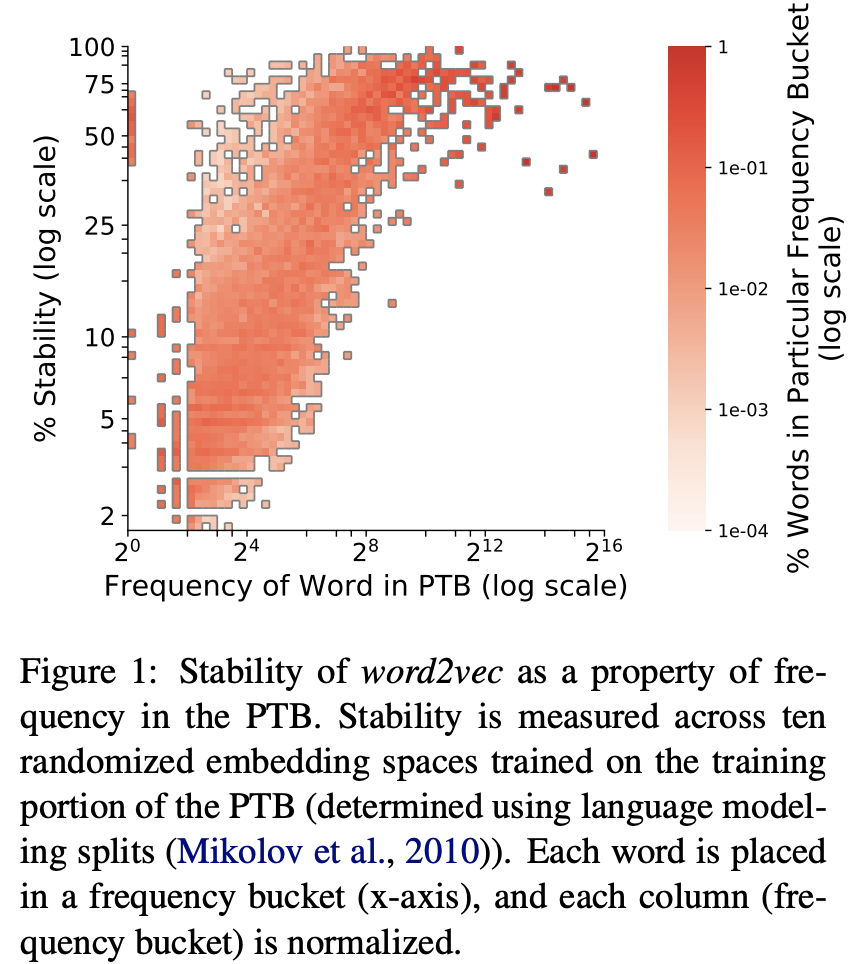

In [70]:
from IPython.display import Image
Image("fig1.png", width = 500 , height = 500)

In [ ]:
#in markdown file this creates the same image as above
#![title](fig1.png)

## Conclusion.  
Biased word embeddings are a product of a society that promotes and retains these biases. While we attempt here to mitigate the bias artificially, it is only a small step towards creating a more equitable world where tasks like these should not even be needed to be done. 